In [8]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns

In [71]:
DATA_FOLDER="tmp/"
SCHEDULER="123.122.8.24:8786"
DATABASES_GLOB = "data/hg19-tss-centered-10kb-7species.mc9nr.feather"
MOTIF_ANNOTATIONS_FNAME = "data/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"
MM_TFS_FNAME = "data/hs_hgnc_tfs.txt"
SC_EXP_FNAME = os.path.join("GSE153697_filtered_raw_expression_matrix.txt")
#Download the raw expression matrix here : https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE153697&format=file&file=GSE153697%5Ffiltered%5Fraw%5Fexpression%5Fmatrix%2Etsv%2Egz
#output files
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")
ADJAC_FNAME = os.path.join(DATA_FOLDER, "expr_mat.adjacencies.csv")
R_REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.tsv")
AUCMTX_FNAME = os.path.join(DATA_FOLDER, "auc_mtx.csv")

    
    
#Download list of curated human transcription factors from: Lambert SA et al. The Human Transcription Factors. Cell 2018 https://dx.doi.org/10.1016/j.cell.2018.01.029
#https://github.com/aertslab/pySCENIC/blob/master/notebooks/pySCENIC%20-%20List%20of%20Transcription%20Factors.ipynb
#All files are available here : https://github.com/aertslab/pySCENIC/tree/master/resources

In [17]:
ex_matrix = pd.read_csv(SC_EXP_FNAME, sep='\t', header=0, index_col=0).T
ex_matrix.shape

(2919, 19288)

In [24]:
tf_names = load_tf_names(MM_TFS_FNAME)

In [25]:
db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs

[FeatherRankingDatabase(name="hg19-tss-centered-10kb-7species.mc9nr")]

In [26]:
#Phase I: Inference of co-expression modules

In [27]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster
finished


In [68]:
adjacencies.to_csv(ADJAC_FNAME)

In [28]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))


2020-01-16 13:46:14,639 - pyscenic.utils - INFO - Calculating Pearson correlations.

2020-01-16 13:46:14,640 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2020-01-16 13:47:23,853 - pyscenic.utils - INFO - Creating modules.


In [31]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

# Create regulons from this table of enriched motifs.
regulons = df2regulons(df)

# Save the enriched motifs and the discovered regulons to disk.
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)

[                                        ] | 0% Completed |  4.2s


2020-01-16 14:12:28,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ABL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  4.7s


2020-01-16 14:12:28,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ACO1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:28,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADARB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  4.8s


2020-01-16 14:12:28,743 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  4.9s


2020-01-16 14:12:28,883 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  5.1s


2020-01-16 14:12:29,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AEBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  5.6s


2020-01-16 14:12:29,536 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGAP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  5.9s


2020-01-16 14:12:29,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGMAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  6.4s


2020-01-16 14:12:30,264 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHRR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  6.5s


2020-01-16 14:12:30,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AIRE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  7.5s


2020-01-16 14:12:31,357 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  9.4s


2020-01-16 14:12:33,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  9.8s


2020-01-16 14:12:33,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  9.9s


2020-01-16 14:12:33,908 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 10.2s


2020-01-16 14:12:34,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETFB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 10.5s


2020-01-16 14:12:34,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 10.7s


2020-01-16 14:12:34,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 10.8s


2020-01-16 14:12:34,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 10.9s


2020-01-16 14:12:34,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CHURC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:34,779 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:34,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CIC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 11.3s


2020-01-16 14:12:35,284 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 11.5s


2020-01-16 14:12:35,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 12.2s


2020-01-16 14:12:36,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:36,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CLOCK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:36,216 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 12.4s


2020-01-16 14:12:36,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASAP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 12.6s


2020-01-16 14:12:36,480 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 12.8s


2020-01-16 14:12:36,674 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:36,699 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 12.9s


2020-01-16 14:12:36,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPSF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:36,815 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:36,918 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPTP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 13.3s


2020-01-16 14:12:37,148 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 13.4s


2020-01-16 14:12:37,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASH2L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 13.6s


2020-01-16 14:12:37,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:37,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASPSCR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:37,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HESX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 13.7s


2020-01-16 14:12:37,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 14.0s


2020-01-16 14:12:37,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEYL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:37,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 14.2s


2020-01-16 14:12:38,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHEX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 14.4s


2020-01-16 14:12:38,276 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 14.5s


2020-01-16 14:12:38,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 14.6s


2020-01-16 14:12:38,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 14.8s


2020-01-16 14:12:38,632 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 15.4s


2020-01-16 14:12:39,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HINFP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:39,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 15.6s


2020-01-16 14:12:39,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:39,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 15.9s


2020-01-16 14:12:39,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:39,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIST1H2BN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 16.1s


2020-01-16 14:12:39,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:40,053 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 16.3s


2020-01-16 14:12:40,185 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 16.4s


2020-01-16 14:12:40,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIST2H2BE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 16.6s


2020-01-16 14:12:40,478 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 16.7s


2020-01-16 14:12:40,581 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3L2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 17.5s


2020-01-16 14:12:41,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 17.6s


2020-01-16 14:12:41,495 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 17.8s


2020-01-16 14:12:41,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.0s


2020-01-16 14:12:41,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLCS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.1s


2020-01-16 14:12:41,911 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:41,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.3s


2020-01-16 14:12:42,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBZF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.8s


2020-01-16 14:12:42,710 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:42,743 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 18.9s


2020-01-16 14:12:42,872 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.1s


2020-01-16 14:12:42,972 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:43,058 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:43,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRTC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.3s


2020-01-16 14:12:43,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.5s


2020-01-16 14:12:43,362 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 19.7s


2020-01-16 14:12:43,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSTF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 20.1s


2020-01-16 14:12:44,022 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 20.3s


2020-01-16 14:12:44,215 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXO5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 22.6s


2020-01-16 14:12:46,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCFL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 23.1s


2020-01-16 14:12:47,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:47,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 23.2s


2020-01-16 14:12:47,183 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 23.4s


2020-01-16 14:12:47,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYEF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 23.6s


2020-01-16 14:12:47,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM5D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:47,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYLK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:47,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CUX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 23.7s


2020-01-16 14:12:47,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:47,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYNN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:47,837 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYPOP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 24.0s


2020-01-16 14:12:47,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FAAP24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:47,967 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 24.2s


2020-01-16 14:12:48,095 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:48,106 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FANK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 24.4s


2020-01-16 14:12:48,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CYB5R1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:48,210 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NAGS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:48,302 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PGAM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 24.6s


2020-01-16 14:12:48,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:48,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:48,493 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:48,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 24.8s


2020-01-16 14:12:48,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF21A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:48,773 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AVEN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 25.0s


2020-01-16 14:12:48,969 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 25.3s


2020-01-16 14:12:49,273 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FGF19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 25.5s


2020-01-16 14:12:49,433 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DAB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 25.7s


2020-01-16 14:12:49,590 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 25.8s


2020-01-16 14:12:49,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BACH1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 26.1s


2020-01-16 14:12:49,935 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NCALD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:49,949 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:50,013 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:50,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BACH2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:50,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 26.2s


2020-01-16 14:12:50,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PICK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 26.6s


2020-01-16 14:12:50,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PIK3C3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:50,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BANP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 26.7s


2020-01-16 14:12:50,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PIR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 26.8s


2020-01-16 14:12:50,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NCOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 27.0s


2020-01-16 14:12:50,908 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NCOR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 27.5s


2020-01-16 14:12:51,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NELFB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:51,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 27.7s


2020-01-16 14:12:51,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 27.8s


2020-01-16 14:12:51,732 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 28.5s


2020-01-16 14:12:52,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF13 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 28.6s


2020-01-16 14:12:52,482 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PKNOX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:52,632 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 29.0s


2020-01-16 14:12:52,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 29.5s


2020-01-16 14:12:53,324 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:53,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:53,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL11B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 29.6s


2020-01-16 14:12:53,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:53,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DEAF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 29.8s


2020-01-16 14:12:53,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DGCR8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:53,852 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 30.4s


2020-01-16 14:12:54,360 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 30.6s


2020-01-16 14:12:54,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DIS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:54,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:54,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 30.8s


2020-01-16 14:12:54,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:54,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:54,779 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 31.0s


2020-01-16 14:12:55,100 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:55,107 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PML could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:55,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 31.3s


2020-01-16 14:12:55,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPLL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 31.6s


2020-01-16 14:12:55,458 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOMEZ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:55,514 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:55,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 31.7s


2020-01-16 14:12:55,672 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:55,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL6B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 31.9s


2020-01-16 14:12:55,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 32.6s


2020-01-16 14:12:56,523 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 32.7s


2020-01-16 14:12:56,605 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:56,707 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:56,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 32.9s


2020-01-16 14:12:56,817 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:56,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 33.2s


2020-01-16 14:12:57,048 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 33.3s


2020-01-16 14:12:57,248 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 33.5s


2020-01-16 14:12:57,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 33.6s


2020-01-16 14:12:57,542 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:57,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 33.8s


2020-01-16 14:12:57,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 33.9s


2020-01-16 14:12:57,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 34.0s


2020-01-16 14:12:57,924 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:58,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DNTTIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 34.2s


2020-01-16 14:12:58,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 34.3s


2020-01-16 14:12:58,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LARP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 34.5s


2020-01-16 14:12:58,386 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 34.7s


2020-01-16 14:12:58,518 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPS10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 34.8s


2020-01-16 14:12:58,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LARP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 35.2s


2020-01-16 14:12:59,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 35.3s


2020-01-16 14:12:59,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:59,230 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 35.4s


2020-01-16 14:12:59,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:59,369 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 35.6s


2020-01-16 14:12:59,506 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:12:59,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 35.8s


2020-01-16 14:12:59,717 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 36.0s


2020-01-16 14:12:59,920 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUSP22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 36.1s


2020-01-16 14:12:59,998 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:00,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 36.2s


2020-01-16 14:13:00,106 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUSP26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:00,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LIN28A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:00,192 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 36.4s


2020-01-16 14:13:00,282 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 36.5s


2020-01-16 14:13:00,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:00,398 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMO2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 36.6s


2020-01-16 14:13:00,549 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 37.0s


2020-01-16 14:13:00,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPS6KA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 37.1s


2020-01-16 14:13:00,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 37.2s


2020-01-16 14:13:01,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RREB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 37.3s


2020-01-16 14:13:01,172 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 37.5s


2020-01-16 14:13:01,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RTL8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 37.6s


2020-01-16 14:13:01,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 37.7s


2020-01-16 14:13:01,639 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT5B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 38.2s


2020-01-16 14:13:02,151 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 38.3s


2020-01-16 14:13:02,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAU2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 38.5s


2020-01-16 14:13:02,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLI could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 38.6s


2020-01-16 14:13:02,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STUB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:02,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUNX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:02,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFKB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 38.7s


2020-01-16 14:13:02,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 38.9s


2020-01-16 14:13:02,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LUZP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 39.0s


2020-01-16 14:13:02,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 39.1s


2020-01-16 14:13:03,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LYL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:03,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 39.4s


2020-01-16 14:13:03,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 39.6s


2020-01-16 14:13:03,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSPA1L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 39.8s


2020-01-16 14:13:03,668 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUNX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:03,674 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VDR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 39.9s


2020-01-16 14:13:03,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFKB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.0s


2020-01-16 14:13:03,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.1s


2020-01-16 14:13:04,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.3s


2020-01-16 14:13:04,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.4s


2020-01-16 14:13:04,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.7s


2020-01-16 14:13:04,487 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HTATIP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 41.1s


2020-01-16 14:13:04,899 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 41.5s


2020-01-16 14:13:05,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 41.9s


2020-01-16 14:13:05,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WDR83 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 42.0s


2020-01-16 14:13:05,796 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 42.1s


2020-01-16 14:13:05,947 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 42.2s


2020-01-16 14:13:06,022 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WRNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 42.4s


2020-01-16 14:13:06,268 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 42.9s


2020-01-16 14:13:06,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 43.2s


2020-01-16 14:13:07,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:07,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 43.3s


2020-01-16 14:13:07,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 43.4s


2020-01-16 14:13:07,229 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 43.5s


2020-01-16 14:13:07,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:07,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:07,387 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 43.7s


2020-01-16 14:13:07,537 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 43.8s


2020-01-16 14:13:07,627 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF285 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:07,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SUZ12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:07,677 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XRCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.0s


2020-01-16 14:13:07,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.2s


2020-01-16 14:13:08,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:08,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.3s


2020-01-16 14:13:08,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:08,217 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF287 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.4s


2020-01-16 14:13:08,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BNC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.5s


2020-01-16 14:13:08,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF296 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.6s


2020-01-16 14:13:08,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:08,471 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BORCS8-MEF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.7s


2020-01-16 14:13:08,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 44.9s


2020-01-16 14:13:08,791 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.0s


2020-01-16 14:13:08,887 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.1s


2020-01-16 14:13:08,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:09,053 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XRCC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.2s


2020-01-16 14:13:09,131 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.3s


2020-01-16 14:13:09,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF302 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.5s


2020-01-16 14:13:09,433 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF304 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.6s


2020-01-16 14:13:09,471 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.7s


2020-01-16 14:13:09,626 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 45.9s


2020-01-16 14:13:09,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:09,805 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF316 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 46.0s


2020-01-16 14:13:09,910 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 46.1s


2020-01-16 14:13:10,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF317 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 46.2s


2020-01-16 14:13:10,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 46.3s


2020-01-16 14:13:10,264 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF101 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 46.5s


2020-01-16 14:13:10,308 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 46.7s


2020-01-16 14:13:10,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:10,559 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF32 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 46.9s


2020-01-16 14:13:10,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF114 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:10,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 47.1s


2020-01-16 14:13:10,915 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:10,956 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF117 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 47.3s


2020-01-16 14:13:11,129 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF322 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 47.4s


2020-01-16 14:13:11,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:11,210 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:11,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:11,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETDB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 47.5s


2020-01-16 14:13:11,307 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:11,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 47.6s


2020-01-16 14:13:11,466 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 47.7s


2020-01-16 14:13:11,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF121 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 47.8s


2020-01-16 14:13:11,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 48.0s


2020-01-16 14:13:11,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF124 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:11,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF1L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 48.1s


2020-01-16 14:13:11,895 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 48.3s


2020-01-16 14:13:12,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 48.4s


2020-01-16 14:13:12,264 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 48.6s


2020-01-16 14:13:12,426 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF133 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:12,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF329 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 48.7s


2020-01-16 14:13:12,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 48.8s


2020-01-16 14:13:12,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:12,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF134 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:12,712 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF331 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 48.9s


2020-01-16 14:13:12,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:12,821 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 49.1s


2020-01-16 14:13:12,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF135 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:12,982 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF333 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 49.2s


2020-01-16 14:13:13,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAGEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:13,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 49.3s


2020-01-16 14:13:13,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF136 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 49.4s


2020-01-16 14:13:13,256 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF334 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 49.7s


2020-01-16 14:13:13,589 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF335 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:13,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF138 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 49.9s


2020-01-16 14:13:13,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF337 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 50.0s


2020-01-16 14:13:13,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 50.2s


2020-01-16 14:13:14,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF140 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 50.4s


2020-01-16 14:13:14,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:14,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF33A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 50.5s


2020-01-16 14:13:14,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:14,372 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF141 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 50.6s


2020-01-16 14:13:14,475 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:14,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF33B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 50.9s


2020-01-16 14:13:14,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.0s


2020-01-16 14:13:14,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:14,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.1s


2020-01-16 14:13:14,988 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF341 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.2s


2020-01-16 14:13:15,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPDC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.3s


2020-01-16 14:13:15,192 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF343 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.4s


2020-01-16 14:13:15,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:15,309 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAP4K2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.6s


2020-01-16 14:13:15,471 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF345 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.7s


2020-01-16 14:13:15,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.8s


2020-01-16 14:13:15,680 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 52.0s


2020-01-16 14:13:15,902 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:15,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:15,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EBF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 52.1s


2020-01-16 14:13:15,978 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 52.2s


2020-01-16 14:13:16,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EBF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 52.3s


2020-01-16 14:13:16,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:16,220 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 52.5s


2020-01-16 14:13:16,438 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:16,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:16,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 52.6s


2020-01-16 14:13:16,487 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 52.7s


2020-01-16 14:13:16,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:16,633 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EDN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 53.0s


2020-01-16 14:13:16,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EEF1AKMT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 53.6s


2020-01-16 14:13:17,462 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 53.9s


2020-01-16 14:13:17,725 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.0s


2020-01-16 14:13:17,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF358 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:17,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.2s


2020-01-16 14:13:18,043 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF362 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.3s


2020-01-16 14:13:18,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.4s


2020-01-16 14:13:18,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF367 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.5s


2020-01-16 14:13:18,368 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.7s


2020-01-16 14:13:18,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF37A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.8s


2020-01-16 14:13:18,624 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:18,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 54.9s


2020-01-16 14:13:18,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF382 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 55.0s


2020-01-16 14:13:18,815 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF155 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 55.1s


2020-01-16 14:13:18,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF383 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 55.4s


2020-01-16 14:13:19,215 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF384 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:19,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:19,261 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 55.7s


2020-01-16 14:13:19,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF160 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:19,571 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 55.9s


2020-01-16 14:13:19,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF165 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 56.0s


2020-01-16 14:13:19,888 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 56.1s


2020-01-16 14:13:19,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF169 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:19,995 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 56.2s


2020-01-16 14:13:20,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:20,067 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:20,075 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 56.4s


2020-01-16 14:13:20,218 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:20,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CARF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:20,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF391 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 56.6s


2020-01-16 14:13:20,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:20,493 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 56.7s


2020-01-16 14:13:20,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:20,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF174 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 56.9s


2020-01-16 14:13:20,795 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF175 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.0s


2020-01-16 14:13:20,917 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.1s


2020-01-16 14:13:20,998 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF177 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.2s


2020-01-16 14:13:21,100 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.3s


2020-01-16 14:13:21,129 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.4s


2020-01-16 14:13:21,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:21,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.5s


2020-01-16 14:13:21,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:21,362 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBFA2T2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:21,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARGC1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:21,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF398 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.7s


2020-01-16 14:13:21,544 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF180 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:21,633 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.9s


2020-01-16 14:13:21,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:21,802 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF181 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.0s


2020-01-16 14:13:21,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF407 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.2s


2020-01-16 14:13:22,062 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF408 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:22,084 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:22,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.3s


2020-01-16 14:13:22,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.4s


2020-01-16 14:13:22,234 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP1R10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.5s


2020-01-16 14:13:22,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:22,356 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:22,433 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.6s


2020-01-16 14:13:22,456 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP2R3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:22,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF184 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.7s


2020-01-16 14:13:22,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:22,606 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.8s


2020-01-16 14:13:22,664 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF410 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:22,699 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF189 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 58.9s


2020-01-16 14:13:22,801 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR6A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:22,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 59.0s


2020-01-16 14:13:22,906 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:22,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF414 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 59.2s


2020-01-16 14:13:23,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 59.3s


2020-01-16 14:13:23,170 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:23,241 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF195 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 59.4s


2020-01-16 14:13:23,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 59.5s


2020-01-16 14:13:23,379 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF416 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:23,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUAK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:23,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 59.6s


2020-01-16 14:13:23,483 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:23,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 59.7s


2020-01-16 14:13:23,591 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF417 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 59.8s


2020-01-16 14:13:23,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUAK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:23,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 59.9s


2020-01-16 14:13:23,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:23,831 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:23,832 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF418 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.0s


2020-01-16 14:13:23,915 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.2s


2020-01-16 14:13:24,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.3s


2020-01-16 14:13:24,106 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EIF5A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:24,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:24,116 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:24,135 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.4s


2020-01-16 14:13:24,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.5s


2020-01-16 14:13:24,316 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF200 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:24,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF420 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.6s


2020-01-16 14:13:24,436 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GADD45A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.7s


2020-01-16 14:13:24,498 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.8s


2020-01-16 14:13:24,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF202 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:24,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF423 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  0.9s


2020-01-16 14:13:24,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  1.0s


2020-01-16 14:13:24,804 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CD59 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:24,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  1.2s


2020-01-16 14:13:25,010 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:25,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF426 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  1.3s


2020-01-16 14:13:25,076 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBNL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:25,126 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  1.4s


2020-01-16 14:13:25,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  1.6s


2020-01-16 14:13:25,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  1.7s


2020-01-16 14:13:25,498 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBTPS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:25,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:25,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NXPH3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.0s


2020-01-16 14:13:25,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:25,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDK2AP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:25,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ODC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.1s


2020-01-16 14:13:25,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MCTP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.2s


2020-01-16 14:13:26,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:26,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.3s


2020-01-16 14:13:26,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCFL5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:26,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF431 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:26,201 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.4s


2020-01-16 14:13:26,248 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:26,276 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.5s


2020-01-16 14:13:26,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:26,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.6s


2020-01-16 14:13:26,438 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ONECUT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:26,442 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF432 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.7s


2020-01-16 14:13:26,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF215 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:26,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MECOM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:26,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF433 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.8s


2020-01-16 14:13:26,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OSR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.9s


2020-01-16 14:13:26,816 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF217 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  3.0s


2020-01-16 14:13:26,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:26,903 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTUD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:26,920 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MECP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  3.2s


2020-01-16 14:13:27,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:27,059 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF438 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:27,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  3.4s


2020-01-16 14:13:27,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  3.7s


2020-01-16 14:13:27,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  3.9s


2020-01-16 14:13:27,756 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:27,837 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.1s


2020-01-16 14:13:28,037 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF441 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.3s


2020-01-16 14:13:28,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.5s


2020-01-16 14:13:28,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF443 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.7s


2020-01-16 14:13:28,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF221 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:28,606 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIRT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:28,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.8s


2020-01-16 14:13:28,699 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF444 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.9s


2020-01-16 14:13:28,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF222 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.0s


2020-01-16 14:13:28,862 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:28,882 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.1s


2020-01-16 14:13:28,997 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:29,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF445 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.2s


2020-01-16 14:13:29,088 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.3s


2020-01-16 14:13:29,192 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.4s


2020-01-16 14:13:29,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TERF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:29,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.5s


2020-01-16 14:13:29,470 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF45 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.6s


2020-01-16 14:13:29,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF225 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.8s


2020-01-16 14:13:29,596 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TERF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.9s


2020-01-16 14:13:29,746 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF226 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.0s


2020-01-16 14:13:29,818 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:29,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:29,862 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TET1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.3s


2020-01-16 14:13:30,170 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF460 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.4s


2020-01-16 14:13:30,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:30,247 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF229 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.5s


2020-01-16 14:13:30,343 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.6s


2020-01-16 14:13:30,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.7s


2020-01-16 14:13:30,535 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:30,534 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF23 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:30,561 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF467 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.8s


2020-01-16 14:13:30,646 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTCD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:30,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.9s


2020-01-16 14:13:30,713 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:30,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF468 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.0s


2020-01-16 14:13:30,813 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF230 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.1s


2020-01-16 14:13:30,910 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:30,984 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF470 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.2s


2020-01-16 14:13:31,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.3s


2020-01-16 14:13:31,158 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF232 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.4s


2020-01-16 14:13:31,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:31,287 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.6s


2020-01-16 14:13:31,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.7s


2020-01-16 14:13:31,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:31,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PURA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.8s


2020-01-16 14:13:31,635 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF234 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  7.9s


2020-01-16 14:13:31,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:31,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:31,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.0s


2020-01-16 14:13:31,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for R3HDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:31,885 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF235 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.1s


2020-01-16 14:13:31,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.2s


2020-01-16 14:13:32,011 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF471 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.3s


2020-01-16 14:13:32,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF236 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,192 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.4s


2020-01-16 14:13:32,279 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF48 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.5s


2020-01-16 14:13:32,372 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,378 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF239 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.6s


2020-01-16 14:13:32,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.7s


2020-01-16 14:13:32,565 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,591 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF480 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.8s


2020-01-16 14:13:32,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,736 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMARCA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.9s


2020-01-16 14:13:32,734 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,804 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF483 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  9.0s


2020-01-16 14:13:32,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,911 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEX3C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  9.1s


2020-01-16 14:13:32,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:32,977 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF484 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  9.2s


2020-01-16 14:13:33,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:33,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAXIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:33,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF248 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:33,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  9.4s


2020-01-16 14:13:33,251 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  9.5s


2020-01-16 14:13:33,381 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:33,422 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  9.7s


2020-01-16 14:13:33,578 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  9.8s


2020-01-16 14:13:33,693 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  9.9s


2020-01-16 14:13:33,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF250 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:33,815 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIOS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 10.1s


2020-01-16 14:13:34,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 10.2s


2020-01-16 14:13:34,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YOD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 10.3s


2020-01-16 14:13:34,180 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:34,237 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 10.4s


2020-01-16 14:13:34,302 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF253 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 10.5s


2020-01-16 14:13:34,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 10.7s


2020-01-16 14:13:34,515 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF254 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 10.8s


2020-01-16 14:13:34,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:34,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 10.9s


2020-01-16 14:13:34,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF256 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 11.0s


2020-01-16 14:13:34,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPAM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:34,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF257 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 11.2s


2020-01-16 14:13:35,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MITF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:35,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPANK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:35,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 11.4s


2020-01-16 14:13:35,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 11.5s


2020-01-16 14:13:35,349 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:35,427 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:35,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 11.6s


2020-01-16 14:13:35,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 11.8s


2020-01-16 14:13:35,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:35,801 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHPR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 12.1s


2020-01-16 14:13:35,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GSC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:36,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 12.3s


2020-01-16 14:13:36,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 12.5s


2020-01-16 14:13:36,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 12.7s


2020-01-16 14:13:36,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:36,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF263 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 12.9s


2020-01-16 14:13:36,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:36,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 13.1s


2020-01-16 14:13:37,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EMX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:37,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:37,051 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF491 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 13.2s


2020-01-16 14:13:37,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF266 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 13.3s


2020-01-16 14:13:37,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF492 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 13.5s


2020-01-16 14:13:37,316 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CENPB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 13.6s


2020-01-16 14:13:37,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF267 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 13.7s


2020-01-16 14:13:37,523 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF493 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 13.8s


2020-01-16 14:13:37,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF273 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  1min 13.9s


2020-01-16 14:13:37,738 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:37,772 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF496 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 14.1s


2020-01-16 14:13:37,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF274 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 14.2s


2020-01-16 14:13:38,007 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:38,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF497 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 14.3s


2020-01-16 14:13:38,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:38,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 14.4s


2020-01-16 14:13:38,290 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF500 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 14.5s


2020-01-16 14:13:38,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:38,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:38,490 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF501 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 14.8s


2020-01-16 14:13:38,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:38,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 15.0s


2020-01-16 14:13:38,867 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFE3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:38,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF503 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:38,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 15.2s


2020-01-16 14:13:39,125 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF506 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 15.3s


2020-01-16 14:13:39,217 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:39,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFEB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 15.5s


2020-01-16 14:13:39,386 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 15.8s


2020-01-16 14:13:39,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF510 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:39,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 15.9s


2020-01-16 14:13:39,734 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 16.0s


2020-01-16 14:13:39,802 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 16.1s


2020-01-16 14:13:39,910 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF513 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:40,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 16.3s


2020-01-16 14:13:40,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 16.4s


2020-01-16 14:13:40,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MORN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:40,433 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF516 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:40,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF281 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:40,614 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF517 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:40,739 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF282 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:40,870 - pyscenic.transform - WARNING - Less tha

[                                        ] | 2% Completed |  1min 17.2s


2020-01-16 14:13:41,037 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 17.3s


2020-01-16 14:13:41,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF521 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 17.4s


2020-01-16 14:13:41,295 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  1min 17.5s


2020-01-16 14:13:41,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  1min 17.8s


2020-01-16 14:13:41,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF525 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  1min 17.9s


2020-01-16 14:13:41,735 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  1min 18.0s


2020-01-16 14:13:41,831 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF628 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:41,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF526 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 18.2s


2020-01-16 14:13:42,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:42,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF527 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 18.4s


2020-01-16 14:13:42,299 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:42,323 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:42,369 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 18.6s


2020-01-16 14:13:42,456 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:42,498 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF639 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 18.7s


2020-01-16 14:13:42,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF529 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:42,627 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSRB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:42,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 18.9s


2020-01-16 14:13:42,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF641 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:42,790 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF530 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:42,842 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:42,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 19.0s


2020-01-16 14:13:42,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF646 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 19.1s


2020-01-16 14:13:43,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:43,095 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:43,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 19.3s


2020-01-16 14:13:43,212 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF649 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:43,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF534 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 19.4s


2020-01-16 14:13:43,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:43,371 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF536 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:43,408 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF652 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 19.6s


2020-01-16 14:13:43,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF540 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:43,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 19.7s


2020-01-16 14:13:43,586 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 19.9s


2020-01-16 14:13:43,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 20.0s


2020-01-16 14:13:43,889 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EP300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:43,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:43,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 20.2s


2020-01-16 14:13:44,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF655 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:44,058 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EPAS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 20.3s


2020-01-16 14:13:44,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF544 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:44,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:44,236 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMUG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:44,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF658 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:44,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ERF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 20.6s


2020-01-16 14:13:44,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:44,502 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 20.7s


2020-01-16 14:13:44,693 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:44,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 20.8s


2020-01-16 14:13:44,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:44,841 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  1min 21.0s


2020-01-16 14:13:44,903 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,011 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,020 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 21.3s


2020-01-16 14:13:45,172 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,190 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF664 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF550 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,236 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 21.5s


2020-01-16 14:13:45,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,452 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF799 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,470 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF665 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 21.6s


2020-01-16 14:13:45,461 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,500 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF551 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,503 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 21.7s


2020-01-16 14:13:45,597 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,654 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 21.9s


2020-01-16 14:13:45,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,726 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF552 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 22.0s


2020-01-16 14:13:45,881 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 22.1s


2020-01-16 14:13:45,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF668 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF80 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:45,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF554 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 22.2s


2020-01-16 14:13:46,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 22.3s


2020-01-16 14:13:46,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:46,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 22.4s


2020-01-16 14:13:46,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF669 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:46,278 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 22.6s


2020-01-16 14:13:46,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF670 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:46,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 22.7s


2020-01-16 14:13:46,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB38 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:46,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF805 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 22.8s


2020-01-16 14:13:46,701 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF671 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 22.9s


2020-01-16 14:13:46,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF557 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:46,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:46,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 23.0s


2020-01-16 14:13:46,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF808 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 23.2s


2020-01-16 14:13:47,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF672 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:47,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 23.3s


2020-01-16 14:13:47,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF558 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:47,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF81 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 23.4s


2020-01-16 14:13:47,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF674 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 23.5s


2020-01-16 14:13:47,381 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:47,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF813 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:47,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 23.6s


2020-01-16 14:13:47,497 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF675 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 23.7s


2020-01-16 14:13:47,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 23.8s


2020-01-16 14:13:47,657 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF561 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:47,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF814 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:47,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF677 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 24.0s


2020-01-16 14:13:47,891 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF816 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 24.1s


2020-01-16 14:13:47,973 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF562 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:47,995 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF678 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 24.2s


2020-01-16 14:13:48,125 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOCS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 24.3s


2020-01-16 14:13:48,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF821 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:48,234 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF563 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 24.4s


2020-01-16 14:13:48,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF680 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 24.6s


2020-01-16 14:13:48,456 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:48,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF823 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:48,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 24.7s


2020-01-16 14:13:48,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF681 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 24.8s


2020-01-16 14:13:48,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF829 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:48,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB45 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 24.9s


2020-01-16 14:13:48,739 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF565 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:48,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF682 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 25.1s


2020-01-16 14:13:48,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB46 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:48,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF683 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 25.3s


2020-01-16 14:13:49,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB47 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 25.4s


2020-01-16 14:13:49,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF567 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:49,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF830 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:49,324 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF684 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 25.6s


2020-01-16 14:13:49,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF568 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 25.7s


2020-01-16 14:13:49,612 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF687 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 25.9s


2020-01-16 14:13:49,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF569 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:49,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF688 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 26.1s


2020-01-16 14:13:49,987 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:49,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF57 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:50,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 26.2s


2020-01-16 14:13:50,100 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:50,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF689 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 26.3s


2020-01-16 14:13:50,215 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF570 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:50,244 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 26.4s


2020-01-16 14:13:50,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 26.5s


2020-01-16 14:13:50,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:50,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:50,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 26.6s


2020-01-16 14:13:50,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF831 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:50,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 26.7s


2020-01-16 14:13:50,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF691 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 26.8s


2020-01-16 14:13:50,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBBP9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:50,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:50,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF835 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:50,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 27.0s


2020-01-16 14:13:50,888 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBFOX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 27.1s


2020-01-16 14:13:50,902 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:50,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF692 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 27.2s


2020-01-16 14:13:51,073 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 27.3s


2020-01-16 14:13:51,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF695 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 27.4s


2020-01-16 14:13:51,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF575 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:51,303 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 27.5s


2020-01-16 14:13:51,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF84 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:51,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF696 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 27.6s


2020-01-16 14:13:51,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF577 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 27.8s


2020-01-16 14:13:51,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF697 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 27.9s


2020-01-16 14:13:51,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TMEM33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:51,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTPBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:51,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF578 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 28.0s


2020-01-16 14:13:51,836 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF844 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:51,875 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF699 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 28.1s


2020-01-16 14:13:51,910 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYBL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:51,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF579 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:51,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTPBP6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 28.2s


2020-01-16 14:13:52,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF845 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:52,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 28.3s


2020-01-16 14:13:52,198 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF70 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:52,205 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF580 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:52,213 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 28.4s


2020-01-16 14:13:52,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 28.5s


2020-01-16 14:13:52,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF846 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:52,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF700 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 28.6s


2020-01-16 14:13:52,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TOPORS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 28.7s


2020-01-16 14:13:52,633 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:52,632 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF85 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 28.8s


2020-01-16 14:13:52,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for H1FX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 28.9s


2020-01-16 14:13:52,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF582 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:52,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:52,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZC3H7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:52,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF860 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:52,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP53 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 29.1s


2020-01-16 14:13:52,921 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF704 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:52,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF583 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 29.2s


2020-01-16 14:13:53,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZCCHC14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF878 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,071 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP63 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,121 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF705D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 29.3s


2020-01-16 14:13:53,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF879 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 29.4s


2020-01-16 14:13:53,295 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,292 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP73 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 29.6s


2020-01-16 14:13:53,415 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,493 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF880 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 29.7s


2020-01-16 14:13:53,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,586 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 29.8s


2020-01-16 14:13:53,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF883 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 29.9s


2020-01-16 14:13:53,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF586 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,800 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 30.0s


2020-01-16 14:13:53,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,899 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  1min 30.1s


2020-01-16 14:13:53,997 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF707 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:53,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:54,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF90 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 30.3s


2020-01-16 14:13:54,199 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:54,202 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF589 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 30.4s


2020-01-16 14:13:54,291 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF708 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 30.5s


2020-01-16 14:13:54,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:54,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:54,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:54,476 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF592 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 30.6s


2020-01-16 14:13:54,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF709 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 30.8s


2020-01-16 14:13:54,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF594 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:54,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 30.9s


2020-01-16 14:13:54,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF92 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:54,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPPP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:54,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF71 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 31.0s


2020-01-16 14:13:54,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF595 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 31.1s


2020-01-16 14:13:55,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF710 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 31.2s


2020-01-16 14:13:55,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRAF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:55,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF93 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 31.3s


2020-01-16 14:13:55,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 31.4s


2020-01-16 14:13:55,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:55,305 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF711 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:55,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF597 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:55,335 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF99 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 31.5s


2020-01-16 14:13:55,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 31.7s


2020-01-16 14:13:55,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUND could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 31.8s


2020-01-16 14:13:55,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF598 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 31.9s


2020-01-16 14:13:55,773 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KAT2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 32.0s


2020-01-16 14:13:55,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:55,899 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:55,908 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF599 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 32.1s


2020-01-16 14:13:56,003 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KCNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 32.2s


2020-01-16 14:13:56,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BACH1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,107 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,116 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 32.3s


2020-01-16 14:13:56,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF717 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 32.4s


2020-01-16 14:13:56,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF605 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 32.5s


2020-01-16 14:13:56,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF718 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 32.7s


2020-01-16 14:13:56,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF606 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 32.8s


2020-01-16 14:13:56,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 32.9s


2020-01-16 14:13:56,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BANP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 33.0s


2020-01-16 14:13:56,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:56,913 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIP10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 33.1s


2020-01-16 14:13:56,930 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 33.2s


2020-01-16 14:13:57,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:57,095 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:57,097 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF721 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:57,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF610 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:57,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMO could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 33.4s


2020-01-16 14:13:57,278 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 33.5s


2020-01-16 14:13:57,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF726 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:57,371 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF611 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 33.6s


2020-01-16 14:13:57,485 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:57,508 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 33.7s


2020-01-16 14:13:57,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF613 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:57,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF730 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 33.9s


2020-01-16 14:13:57,707 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:57,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:57,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RCOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 34.0s


2020-01-16 14:13:57,854 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF614 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 34.1s


2020-01-16 14:13:57,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:57,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF736 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 34.2s


2020-01-16 14:13:58,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP37 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:58,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRPS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:58,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF615 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:58,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 34.4s


2020-01-16 14:13:58,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF616 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 34.5s


2020-01-16 14:13:58,394 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:58,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP62 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:58,479 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF619 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  1min 34.7s


2020-01-16 14:13:58,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN29 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:58,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF620 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 34.9s


2020-01-16 14:13:58,838 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:58,841 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 35.1s


2020-01-16 14:13:58,899 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:58,966 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 35.2s


2020-01-16 14:13:59,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 35.3s


2020-01-16 14:13:59,148 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 35.4s


2020-01-16 14:13:59,224 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF622 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP82 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 35.5s


2020-01-16 14:13:59,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN32 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 35.6s


2020-01-16 14:13:59,402 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF740 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,476 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF623 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 35.7s


2020-01-16 14:13:59,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP90 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF746 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 35.8s


2020-01-16 14:13:59,645 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF624 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 35.9s


2020-01-16 14:13:59,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,778 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSNAX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,814 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 36.1s


2020-01-16 14:13:59,895 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,902 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:13:59,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 36.2s


2020-01-16 14:14:00,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:00,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:00,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF626 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:00,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSWIM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 36.3s


2020-01-16 14:14:00,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for U2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 36.4s


2020-01-16 14:14:00,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:00,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  1min 36.6s


2020-01-16 14:14:00,330 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF627 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:00,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HCFC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:00,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:00,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 36.7s


2020-01-16 14:14:00,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF76 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 36.8s


2020-01-16 14:14:00,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:00,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFY could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 37.0s


2020-01-16 14:14:00,807 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF761 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:00,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ABL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 37.1s


2020-01-16 14:14:00,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPATS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:01,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:01,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 37.2s


2020-01-16 14:14:01,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF764 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:01,282 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ACO1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 37.4s


2020-01-16 14:14:01,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF765 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:01,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADARB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 37.6s


2020-01-16 14:14:01,470 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:01,501 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL6B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 37.8s


2020-01-16 14:14:01,643 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:01,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:01,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF766 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 37.9s


2020-01-16 14:14:01,818 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:01,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF768 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 38.0s


2020-01-16 14:14:01,990 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AEBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:02,056 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 38.3s


2020-01-16 14:14:02,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBE2V1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 38.4s


2020-01-16 14:14:02,348 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:02,378 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUSP22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 38.6s


2020-01-16 14:14:02,513 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:02,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:02,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUSP26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:02,594 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF771 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 38.8s


2020-01-16 14:14:02,702 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:02,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:02,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGGF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 39.0s


2020-01-16 14:14:02,805 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:02,907 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHCTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 39.1s


2020-01-16 14:14:03,004 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF773 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 39.4s


2020-01-16 14:14:03,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RELB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:03,316 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHRR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 39.6s


2020-01-16 14:14:03,483 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AIRE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:03,550 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  1min 39.9s


2020-01-16 14:14:03,739 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF777 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  1min 40.1s


2020-01-16 14:14:03,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF778 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 40.2s


2020-01-16 14:14:04,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 40.5s


2020-01-16 14:14:04,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF780B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 40.6s


2020-01-16 14:14:04,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF781 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 40.8s


2020-01-16 14:14:04,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:04,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 40.9s


2020-01-16 14:14:04,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF784 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 41.2s


2020-01-16 14:14:05,097 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 41.4s


2020-01-16 14:14:05,342 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF786 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:05,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ANXA11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 41.7s


2020-01-16 14:14:05,578 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 41.9s


2020-01-16 14:14:05,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF789 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 42.0s


2020-01-16 14:14:05,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF79 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 42.2s


2020-01-16 14:14:06,125 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF790 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 42.5s


2020-01-16 14:14:06,387 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 42.7s


2020-01-16 14:14:06,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF791 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:06,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF792 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 42.8s


2020-01-16 14:14:06,820 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF793 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 43.0s


2020-01-16 14:14:06,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for APEX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  1min 43.9s


2020-01-16 14:14:07,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 44.2s


2020-01-16 14:14:08,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPIB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 44.4s


2020-01-16 14:14:08,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 44.5s


2020-01-16 14:14:08,370 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:08,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BHLHE40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 44.7s


2020-01-16 14:14:08,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 44.8s


2020-01-16 14:14:08,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BORCS8-MEF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 45.1s


2020-01-16 14:14:09,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 45.2s


2020-01-16 14:14:09,076 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 45.4s


2020-01-16 14:14:09,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 45.5s


2020-01-16 14:14:09,390 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 45.7s


2020-01-16 14:14:09,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:09,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 45.8s


2020-01-16 14:14:09,802 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  1min 46.1s


2020-01-16 14:14:09,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 46.8s


2020-01-16 14:14:10,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:10,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 47.3s


2020-01-16 14:14:11,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:11,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 47.4s


2020-01-16 14:14:11,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASAP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:11,293 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 47.6s


2020-01-16 14:14:11,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:11,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:11,462 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 47.7s


2020-01-16 14:14:11,596 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:11,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:11,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 47.8s


2020-01-16 14:14:11,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASH2L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 48.1s


2020-01-16 14:14:12,112 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 48.7s


2020-01-16 14:14:12,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:12,627 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SSBP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:12,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 48.9s


2020-01-16 14:14:12,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:12,848 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:12,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  1min 49.0s


2020-01-16 14:14:12,981 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:13,003 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  1min 49.2s


2020-01-16 14:14:13,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  1min 49.9s


2020-01-16 14:14:13,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXAP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  1min 50.0s


2020-01-16 14:14:13,920 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDAC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:13,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:14,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDAC6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  1min 50.3s


2020-01-16 14:14:14,140 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  1min 50.4s


2020-01-16 14:14:14,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:14,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  1min 50.6s


2020-01-16 14:14:14,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:14,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CARF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  1min 51.2s


2020-01-16 14:14:15,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HTATIP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  1min 51.4s


2020-01-16 14:14:15,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:15,354 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CBFB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  1min 52.0s


2020-01-16 14:14:15,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  1min 52.3s


2020-01-16 14:14:16,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 52.9s


2020-01-16 14:14:16,849 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 53.2s


2020-01-16 14:14:17,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:17,172 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 53.4s


2020-01-16 14:14:17,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 53.5s


2020-01-16 14:14:17,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDK2AP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:17,415 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 53.7s


2020-01-16 14:14:17,531 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:17,573 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:17,680 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 53.8s


2020-01-16 14:14:17,760 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 54.0s


2020-01-16 14:14:17,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:17,976 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 54.2s


2020-01-16 14:14:18,062 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EDN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 54.3s


2020-01-16 14:14:18,215 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EEF1AKMT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:18,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 54.7s


2020-01-16 14:14:18,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 54.8s


2020-01-16 14:14:18,746 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 55.0s


2020-01-16 14:14:18,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:18,930 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 55.2s


2020-01-16 14:14:19,037 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 55.4s


2020-01-16 14:14:19,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  1min 55.6s


2020-01-16 14:14:19,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 56.2s


2020-01-16 14:14:20,039 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 56.3s


2020-01-16 14:14:20,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:20,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPDC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 56.4s


2020-01-16 14:14:20,295 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:20,325 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:20,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 56.6s


2020-01-16 14:14:20,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 56.7s


2020-01-16 14:14:20,586 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 56.8s


2020-01-16 14:14:20,704 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 57.0s


2020-01-16 14:14:20,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPANK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 57.1s


2020-01-16 14:14:21,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:21,025 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 57.3s


2020-01-16 14:14:21,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 57.6s


2020-01-16 14:14:21,535 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 57.7s


2020-01-16 14:14:21,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 58.0s


2020-01-16 14:14:21,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 58.2s


2020-01-16 14:14:22,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHPR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 58.4s


2020-01-16 14:14:22,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GSC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  1min 59.7s


2020-01-16 14:14:23,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTCD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  1min 60.0s


2020-01-16 14:14:23,837 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  0.1s


2020-01-16 14:14:23,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  0.3s


2020-01-16 14:14:24,160 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  0.4s


2020-01-16 14:14:24,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:24,368 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MBNL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:24,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  0.8s


2020-01-16 14:14:24,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  1.0s


2020-01-16 14:14:24,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:24,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMARCA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  1.1s


2020-01-16 14:14:24,977 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:24,983 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PURA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:25,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:25,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MECOM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  1.3s


2020-01-16 14:14:25,183 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for R3HDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:25,303 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MECP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:25,323 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  2.0s


2020-01-16 14:14:25,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  2.1s


2020-01-16 14:14:26,105 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:26,109 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  2.3s


2020-01-16 14:14:26,121 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EIF5A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  3.2s


2020-01-16 14:14:27,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  2min  3.3s


2020-01-16 14:14:27,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  3.5s


2020-01-16 14:14:27,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  3.7s


2020-01-16 14:14:27,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  3.9s


2020-01-16 14:14:27,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:27,828 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:27,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CENPB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  4.0s


2020-01-16 14:14:28,125 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:28,139 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:28,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  4.4s


2020-01-16 14:14:28,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  4.9s


2020-01-16 14:14:28,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  5.2s


2020-01-16 14:14:29,141 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR6A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  5.3s


2020-01-16 14:14:29,312 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  5.5s


2020-01-16 14:14:29,466 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  5.8s


2020-01-16 14:14:29,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUAK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  6.2s


2020-01-16 14:14:30,081 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  6.5s


2020-01-16 14:14:30,425 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  2min  6.7s


2020-01-16 14:14:30,671 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NXPH3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  6.9s


2020-01-16 14:14:30,841 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMUG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:30,855 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ODC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  7.0s


2020-01-16 14:14:31,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  7.4s


2020-01-16 14:14:31,237 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  7.5s


2020-01-16 14:14:31,324 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ONECUT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:31,415 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:31,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  7.7s


2020-01-16 14:14:31,620 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:31,668 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTUD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  7.9s


2020-01-16 14:14:31,853 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEX3C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  8.3s


2020-01-16 14:14:32,208 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  8.6s


2020-01-16 14:14:32,578 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MITF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  8.8s


2020-01-16 14:14:32,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOCS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:32,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:32,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  9.2s


2020-01-16 14:14:33,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  9.5s


2020-01-16 14:14:33,430 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTPBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  2min  9.6s


2020-01-16 14:14:33,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:33,685 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min  9.9s


2020-01-16 14:14:33,734 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:33,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:33,809 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:33,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 10.0s


2020-01-16 14:14:33,865 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:33,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:33,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:34,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 10.2s


2020-01-16 14:14:34,003 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for H1FX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:34,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:34,149 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 10.4s


2020-01-16 14:14:34,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 10.5s


2020-01-16 14:14:34,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:34,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 10.6s


2020-01-16 14:14:34,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB42 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 11.1s


2020-01-16 14:14:34,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 11.2s


2020-01-16 14:14:35,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:35,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB45 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 11.3s


2020-01-16 14:14:35,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:35,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB46 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:35,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 11.5s


2020-01-16 14:14:35,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:35,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB47 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 11.6s


2020-01-16 14:14:35,485 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 11.7s


2020-01-16 14:14:35,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  2min 11.8s


2020-01-16 14:14:35,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:35,820 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:35,831 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 12.0s


2020-01-16 14:14:35,959 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 12.1s


2020-01-16 14:14:36,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:36,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 12.3s


2020-01-16 14:14:36,153 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 12.4s


2020-01-16 14:14:36,232 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:36,251 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 12.5s


2020-01-16 14:14:36,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF202 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:36,319 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:36,356 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CHURC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 12.6s


2020-01-16 14:14:36,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MORN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 12.7s


2020-01-16 14:14:36,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:36,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CIC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:36,606 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EMX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 13.1s


2020-01-16 14:14:36,954 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:37,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 13.2s


2020-01-16 14:14:37,150 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFE3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:37,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:37,169 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 13.5s


2020-01-16 14:14:37,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAXIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 13.6s


2020-01-16 14:14:37,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFEB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:37,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 13.7s


2020-01-16 14:14:37,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 13.8s


2020-01-16 14:14:37,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 13.9s


2020-01-16 14:14:37,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSRB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 14.1s


2020-01-16 14:14:37,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZC3H7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 14.2s


2020-01-16 14:14:38,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZCCHC14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 14.4s


2020-01-16 14:14:38,302 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 14.5s


2020-01-16 14:14:38,399 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 14.6s


2020-01-16 14:14:38,485 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF398 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 14.7s


2020-01-16 14:14:38,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 15.0s


2020-01-16 14:14:38,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 15.1s


2020-01-16 14:14:39,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF408 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:39,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPSF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 15.2s


2020-01-16 14:14:39,075 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 15.3s


2020-01-16 14:14:39,236 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 15.5s


2020-01-16 14:14:39,435 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF410 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 15.6s


2020-01-16 14:14:39,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 15.7s


2020-01-16 14:14:39,624 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF414 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 15.8s


2020-01-16 14:14:39,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF212 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 15.9s


2020-01-16 14:14:39,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:39,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 16.0s


2020-01-16 14:14:39,921 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:39,984 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF417 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 16.3s


2020-01-16 14:14:40,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:40,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF418 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:40,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 16.4s


2020-01-16 14:14:40,224 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF217 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:40,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF21A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 16.5s


2020-01-16 14:14:40,330 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 16.6s


2020-01-16 14:14:40,433 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:40,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF420 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 16.7s


2020-01-16 14:14:40,513 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 16.8s


2020-01-16 14:14:40,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF423 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 16.9s


2020-01-16 14:14:40,715 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 17.0s


2020-01-16 14:14:40,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 17.1s


2020-01-16 14:14:40,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 17.2s


2020-01-16 14:14:41,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTERF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 17.3s


2020-01-16 14:14:41,209 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 17.4s


2020-01-16 14:14:41,249 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 17.5s


2020-01-16 14:14:41,392 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:41,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF221 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 17.7s


2020-01-16 14:14:41,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:41,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF222 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 17.8s


2020-01-16 14:14:41,713 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 17.9s


2020-01-16 14:14:41,798 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:41,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF431 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 18.0s


2020-01-16 14:14:41,872 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EP300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:41,882 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 18.1s


2020-01-16 14:14:42,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF432 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 18.2s


2020-01-16 14:14:42,085 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,084 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EPAS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,148 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF433 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 18.3s


2020-01-16 14:14:42,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPATS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 18.4s


2020-01-16 14:14:42,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ERF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,276 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RCOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,334 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF225 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,330 - pyscenic.transform - WARNING - Less than 80

[#######                                 ] | 17% Completed |  2min 18.5s


2020-01-16 14:14:42,435 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 18.6s


2020-01-16 14:14:42,523 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF226 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 18.7s


2020-01-16 14:14:42,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF438 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 18.8s


2020-01-16 14:14:42,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PIK3C3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,700 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:42,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 18.9s


2020-01-16 14:14:42,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF439 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 19.0s


2020-01-16 14:14:42,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF229 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 19.1s


2020-01-16 14:14:42,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:43,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 19.2s


2020-01-16 14:14:43,138 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF23 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 19.3s


2020-01-16 14:14:43,247 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 19.4s


2020-01-16 14:14:43,315 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF230 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 19.5s


2020-01-16 14:14:43,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF441 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 20.0s


2020-01-16 14:14:43,807 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF234 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 20.1s


2020-01-16 14:14:43,914 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:43,973 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF444 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 20.2s


2020-01-16 14:14:43,982 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF235 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 20.3s


2020-01-16 14:14:44,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:44,179 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF445 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:44,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF236 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 20.5s


2020-01-16 14:14:44,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:44,334 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RELB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:44,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 20.6s


2020-01-16 14:14:44,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF239 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 20.8s


2020-01-16 14:14:44,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 20.9s


2020-01-16 14:14:44,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 21.1s


2020-01-16 14:14:44,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF460 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 21.4s


2020-01-16 14:14:45,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF250 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 21.6s


2020-01-16 14:14:45,465 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 21.7s


2020-01-16 14:14:45,582 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF470 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 21.8s


2020-01-16 14:14:45,683 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF253 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 21.9s


2020-01-16 14:14:45,751 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF471 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 22.0s


2020-01-16 14:14:45,867 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF254 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 22.2s


2020-01-16 14:14:46,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:46,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF480 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 22.4s


2020-01-16 14:14:46,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP37 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:46,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF483 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 22.8s


2020-01-16 14:14:46,660 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 23.0s


2020-01-16 14:14:46,849 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 23.2s


2020-01-16 14:14:47,097 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF256 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 23.3s


2020-01-16 14:14:47,125 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 23.4s


2020-01-16 14:14:47,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIMM44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:47,338 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF257 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 23.5s


2020-01-16 14:14:47,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF492 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:47,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 23.7s


2020-01-16 14:14:47,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 23.8s


2020-01-16 14:14:47,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 23.9s


2020-01-16 14:14:47,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP64 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:47,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF496 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:47,814 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 24.0s


2020-01-16 14:14:47,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:47,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 24.1s


2020-01-16 14:14:47,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF497 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 24.2s


2020-01-16 14:14:48,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 24.3s


2020-01-16 14:14:48,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 24.4s


2020-01-16 14:14:48,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAGL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 24.5s


2020-01-16 14:14:48,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPIB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:48,421 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP82 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 24.7s


2020-01-16 14:14:48,585 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:48,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP90 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:48,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF503 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 24.8s


2020-01-16 14:14:48,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 24.9s


2020-01-16 14:14:48,859 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 25.1s


2020-01-16 14:14:48,889 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:48,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF506 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:48,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF263 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:48,971 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TMEM33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 25.3s


2020-01-16 14:14:49,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 25.4s


2020-01-16 14:14:49,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYBL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:49,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF510 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 25.6s


2020-01-16 14:14:49,458 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:49,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF513 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 25.7s


2020-01-16 14:14:49,519 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF267 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 25.8s


2020-01-16 14:14:49,653 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 25.9s


2020-01-16 14:14:49,713 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFY could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:49,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF273 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 26.0s


2020-01-16 14:14:49,794 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP63 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:49,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF516 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 26.1s


2020-01-16 14:14:49,969 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP73 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:49,984 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF274 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 26.2s


2020-01-16 14:14:49,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF517 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:50,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 26.3s


2020-01-16 14:14:50,115 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 26.4s


2020-01-16 14:14:50,241 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:50,249 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF519 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 26.5s


2020-01-16 14:14:50,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:50,336 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLI could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 26.6s


2020-01-16 14:14:50,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 26.7s


2020-01-16 14:14:50,518 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 27.0s


2020-01-16 14:14:50,824 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 27.1s


2020-01-16 14:14:50,924 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRTC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:50,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPPP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:50,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF525 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 27.2s


2020-01-16 14:14:51,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,092 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,104 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 27.3s


2020-01-16 14:14:51,135 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRAF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 27.4s


2020-01-16 14:14:51,218 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF526 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF281 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 27.5s


2020-01-16 14:14:51,392 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 27.6s


2020-01-16 14:14:51,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF527 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSTF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF282 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,499 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 27.7s


2020-01-16 14:14:51,514 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUND could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 27.8s


2020-01-16 14:14:51,668 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLR2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 27.9s


2020-01-16 14:14:51,821 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 28.0s


2020-01-16 14:14:51,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF529 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KCNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 28.1s


2020-01-16 14:14:51,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:51,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF530 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 28.3s


2020-01-16 14:14:52,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF285 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,211 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDAC6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 28.5s


2020-01-16 14:14:52,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,356 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF534 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 28.6s


2020-01-16 14:14:52,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 28.7s


2020-01-16 14:14:52,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,616 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 28.8s


2020-01-16 14:14:52,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF536 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 28.9s


2020-01-16 14:14:52,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIP10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF296 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,816 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF540 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 29.0s


2020-01-16 14:14:52,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLR3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 29.1s


2020-01-16 14:14:52,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMO could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:52,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:53,022 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 29.2s


2020-01-16 14:14:53,075 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:53,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 29.3s


2020-01-16 14:14:53,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:53,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:53,273 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 29.4s


2020-01-16 14:14:53,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 29.5s


2020-01-16 14:14:53,394 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF544 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:53,457 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 29.9s


2020-01-16 14:14:53,726 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRPS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 30.0s


2020-01-16 14:14:53,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXAP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 30.2s


2020-01-16 14:14:54,020 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:54,051 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 30.4s


2020-01-16 14:14:54,212 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 30.6s


2020-01-16 14:14:54,405 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF302 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:54,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF551 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 30.7s


2020-01-16 14:14:54,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:54,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF552 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 30.8s


2020-01-16 14:14:54,608 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF304 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 30.9s


2020-01-16 14:14:54,732 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSNAX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:54,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HESX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 31.0s


2020-01-16 14:14:54,806 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF316 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 31.1s


2020-01-16 14:14:54,917 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:54,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:54,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF317 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:54,997 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 31.3s


2020-01-16 14:14:55,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for U2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:55,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEYL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 31.5s


2020-01-16 14:14:55,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 31.6s


2020-01-16 14:14:55,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF557 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:55,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 31.7s


2020-01-16 14:14:55,591 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RNF138 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 31.8s


2020-01-16 14:14:55,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHEX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:55,626 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF558 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:55,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF322 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 31.9s


2020-01-16 14:14:55,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:55,775 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 32.0s


2020-01-16 14:14:55,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:55,841 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:55,856 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:55,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 32.1s


2020-01-16 14:14:55,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCFL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 32.2s


2020-01-16 14:14:56,020 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,042 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF561 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,029 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,111 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 32.3s


2020-01-16 14:14:56,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF101 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,180 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF562 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 32.4s


2020-01-16 14:14:56,312 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 32.5s


2020-01-16 14:14:56,379 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF563 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 32.6s


2020-01-16 14:14:56,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF329 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 32.7s


2020-01-16 14:14:56,572 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,614 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF114 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 32.8s


2020-01-16 14:14:56,683 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF331 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 32.9s


2020-01-16 14:14:56,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF117 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF565 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 33.0s


2020-01-16 14:14:56,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF333 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:56,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CUX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 33.1s


2020-01-16 14:14:56,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:57,002 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 33.2s


2020-01-16 14:14:57,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYNN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 33.3s


2020-01-16 14:14:57,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF335 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 17% Completed |  2min 33.4s


2020-01-16 14:14:57,303 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:57,310 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF124 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:57,315 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYPOP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 33.6s


2020-01-16 14:14:57,515 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 33.7s


2020-01-16 14:14:57,574 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF33A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:57,653 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF133 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 34.0s


2020-01-16 14:14:57,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF33B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:57,824 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF134 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 34.1s


2020-01-16 14:14:57,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 34.2s


2020-01-16 14:14:57,998 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF135 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:58,039 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HINFP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 34.4s


2020-01-16 14:14:58,220 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF136 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:58,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF343 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 34.6s


2020-01-16 14:14:58,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF138 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 34.7s


2020-01-16 14:14:58,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 35.1s


2020-01-16 14:14:59,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF141 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:59,067 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIST2H2BE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 35.6s


2020-01-16 14:14:59,493 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 35.7s


2020-01-16 14:14:59,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:59,561 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 35.8s


2020-01-16 14:14:59,686 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DBP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:14:59,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 36.1s


2020-01-16 14:15:00,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 36.2s


2020-01-16 14:15:00,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF569 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:00,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NAGS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:00,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 36.3s


2020-01-16 14:15:00,185 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 36.4s


2020-01-16 14:15:00,351 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 36.5s


2020-01-16 14:15:00,435 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF570 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 36.6s


2020-01-16 14:15:00,578 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 36.9s


2020-01-16 14:15:00,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 37.1s


2020-01-16 14:15:00,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF575 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:00,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HKR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 37.3s


2020-01-16 14:15:01,100 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RREB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:01,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF577 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:01,200 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLCS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 37.4s


2020-01-16 14:15:01,292 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RTL8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 37.5s


2020-01-16 14:15:01,400 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF578 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 37.6s


2020-01-16 14:15:01,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 37.7s


2020-01-16 14:15:01,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:01,588 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF579 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 37.9s


2020-01-16 14:15:01,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF580 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 38.0s


2020-01-16 14:15:01,872 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXO5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 38.1s


2020-01-16 14:15:01,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:01,951 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF581 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:01,967 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RUNX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 38.3s


2020-01-16 14:15:02,185 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF582 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:02,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 38.5s


2020-01-16 14:15:02,396 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF583 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 38.8s


2020-01-16 14:15:02,660 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 38.9s


2020-01-16 14:15:02,773 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:02,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:02,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 39.0s


2020-01-16 14:15:02,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF155 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 39.1s


2020-01-16 14:15:02,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 39.2s


2020-01-16 14:15:03,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:03,083 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NCALD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 39.3s


2020-01-16 14:15:03,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF586 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 39.4s


2020-01-16 14:15:03,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:03,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF362 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 39.5s


2020-01-16 14:15:03,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF587 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:03,406 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 39.6s


2020-01-16 14:15:03,448 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF367 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:03,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMG20B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 39.7s


2020-01-16 14:15:03,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 39.8s


2020-01-16 14:15:03,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF37A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:03,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NCOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 39.9s


2020-01-16 14:15:03,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF592 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:03,821 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 40.0s


2020-01-16 14:15:03,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF382 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:03,897 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NCOR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 40.1s


2020-01-16 14:15:03,987 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF595 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:04,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VDR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 40.2s


2020-01-16 14:15:04,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF383 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 40.3s


2020-01-16 14:15:04,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 40.4s


2020-01-16 14:15:04,261 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 40.5s


2020-01-16 14:15:04,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF384 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 40.6s


2020-01-16 14:15:04,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DIS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 40.9s


2020-01-16 14:15:04,820 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 41.4s


2020-01-16 14:15:05,284 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WDR83 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 41.5s


2020-01-16 14:15:05,406 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF597 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 41.6s


2020-01-16 14:15:05,480 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WRNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 41.8s


2020-01-16 14:15:05,699 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  2min 41.9s


2020-01-16 14:15:05,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF599 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 42.2s


2020-01-16 14:15:06,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:06,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF160 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 42.3s


2020-01-16 14:15:06,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FAAP24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 42.4s


2020-01-16 14:15:06,208 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF605 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:06,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF169 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 42.5s


2020-01-16 14:15:06,394 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF606 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 42.6s


2020-01-16 14:15:06,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:06,500 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FBXL19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 42.7s


2020-01-16 14:15:06,566 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 42.8s


2020-01-16 14:15:06,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF174 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 42.9s


2020-01-16 14:15:06,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF610 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:06,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 43.0s


2020-01-16 14:15:06,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF175 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:06,953 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF611 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 43.1s


2020-01-16 14:15:07,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF177 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 43.4s


2020-01-16 14:15:07,247 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:07,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARGC1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:07,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF614 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 43.5s


2020-01-16 14:15:07,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:07,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF615 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 43.6s


2020-01-16 14:15:07,550 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 43.7s


2020-01-16 14:15:07,646 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:07,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF616 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 43.9s


2020-01-16 14:15:07,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP1R10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:07,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 44.0s


2020-01-16 14:15:07,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:07,914 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP2R3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 44.1s


2020-01-16 14:15:07,984 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF184 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:08,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF622 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 44.4s


2020-01-16 14:15:08,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 44.5s


2020-01-16 14:15:08,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF624 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:08,403 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT5B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 44.7s


2020-01-16 14:15:08,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF721 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:08,595 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 44.8s


2020-01-16 14:15:08,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:08,725 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF726 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 44.9s


2020-01-16 14:15:08,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:08,794 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF626 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 45.0s


2020-01-16 14:15:08,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF730 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  2min 45.1s


2020-01-16 14:15:08,973 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 45.2s


2020-01-16 14:15:09,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:09,153 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 45.4s


2020-01-16 14:15:09,185 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF736 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 45.5s


2020-01-16 14:15:09,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETDB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 45.7s


2020-01-16 14:15:09,536 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF740 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:09,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:09,651 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNF1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 45.8s


2020-01-16 14:15:09,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF746 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 46.0s


2020-01-16 14:15:09,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF641 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:09,957 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 46.2s


2020-01-16 14:15:10,033 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF646 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 46.3s


2020-01-16 14:15:10,207 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF649 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:10,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF76 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:10,357 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF652 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 46.5s


2020-01-16 14:15:10,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:10,513 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 46.7s


2020-01-16 14:15:10,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:10,645 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:10,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:10,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF764 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  2min 46.9s


2020-01-16 14:15:10,862 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XRCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 47.1s


2020-01-16 14:15:10,920 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF765 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:11,014 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF658 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 47.2s


2020-01-16 14:15:11,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADARB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:11,104 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF766 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 47.3s


2020-01-16 14:15:11,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:11,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:11,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 47.5s


2020-01-16 14:15:11,381 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:11,461 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STUB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 47.7s


2020-01-16 14:15:11,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF662 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 47.8s


2020-01-16 14:15:11,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF771 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 47.9s


2020-01-16 14:15:11,736 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:11,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF664 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:11,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 48.1s


2020-01-16 14:15:11,917 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF665 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:11,955 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:11,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF773 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 48.2s


2020-01-16 14:15:12,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 48.3s


2020-01-16 14:15:12,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AGMAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 48.5s


2020-01-16 14:15:12,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHCTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:12,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 48.7s


2020-01-16 14:15:12,616 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF670 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:12,620 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF777 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  2min 48.9s


2020-01-16 14:15:12,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AHRR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:12,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF778 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 49.0s


2020-01-16 14:15:12,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AIRE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 49.1s


2020-01-16 14:15:12,997 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SUPT20H could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 49.4s


2020-01-16 14:15:13,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF674 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:13,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 49.5s


2020-01-16 14:15:13,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SUZ12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:13,337 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF781 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 49.6s


2020-01-16 14:15:13,413 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:13,427 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 49.7s


2020-01-16 14:15:13,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF677 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:13,608 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 49.8s


2020-01-16 14:15:13,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 49.9s


2020-01-16 14:15:13,805 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF678 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:13,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPLL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 50.0s


2020-01-16 14:15:13,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for APEX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 50.2s


2020-01-16 14:15:14,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF680 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 50.3s


2020-01-16 14:15:14,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:14,139 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 50.4s


2020-01-16 14:15:14,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CLOCK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:14,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF681 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:14,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 50.6s


2020-01-16 14:15:14,438 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF682 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:14,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 50.7s


2020-01-16 14:15:14,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CNOT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:14,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF683 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 50.8s


2020-01-16 14:15:14,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF784 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:14,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARG2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 50.9s


2020-01-16 14:15:14,842 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 51.2s


2020-01-16 14:15:15,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF786 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 51.3s


2020-01-16 14:15:15,148 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF688 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 51.4s


2020-01-16 14:15:15,229 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:15,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 51.7s


2020-01-16 14:15:15,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF789 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:15,571 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 51.8s


2020-01-16 14:15:15,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF79 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 52.0s


2020-01-16 14:15:15,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPSF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 52.1s


2020-01-16 14:15:15,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF692 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:16,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF791 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 52.2s


2020-01-16 14:15:16,011 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 52.3s


2020-01-16 14:15:16,149 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF695 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:16,198 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 52.4s


2020-01-16 14:15:16,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF792 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 52.5s


2020-01-16 14:15:16,321 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF696 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:16,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARID5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 52.7s


2020-01-16 14:15:16,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:16,601 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF799 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 52.9s


2020-01-16 14:15:16,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF699 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:16,773 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:16,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 53.1s


2020-01-16 14:15:16,951 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF70 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:16,978 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF80 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:17,005 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF1L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:17,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 53.2s


2020-01-16 14:15:17,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF700 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 53.3s


2020-01-16 14:15:17,196 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF800 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  2min 53.4s


2020-01-16 14:15:17,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:17,324 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  2min 53.5s


2020-01-16 14:15:17,379 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF805 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:17,407 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:17,446 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  2min 53.6s


2020-01-16 14:15:17,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF704 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:17,537 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:17,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  2min 53.7s


2020-01-16 14:15:17,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF808 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:17,632 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASAP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  2min 53.8s


2020-01-16 14:15:17,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF705D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  2min 53.9s


2020-01-16 14:15:17,791 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF81 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 54.0s


2020-01-16 14:15:17,872 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 54.1s


2020-01-16 14:15:18,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF813 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 54.4s


2020-01-16 14:15:18,211 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF814 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 54.5s


2020-01-16 14:15:18,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF816 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:18,408 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF709 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 54.6s


2020-01-16 14:15:18,491 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFKB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 54.7s


2020-01-16 14:15:18,571 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF821 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:18,607 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF71 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 54.9s


2020-01-16 14:15:18,790 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF710 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:18,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF823 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 55.0s


2020-01-16 14:15:18,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF711 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 55.2s


2020-01-16 14:15:18,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF829 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 55.5s


2020-01-16 14:15:19,312 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:19,345 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF714 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 55.6s


2020-01-16 14:15:19,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF830 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 55.7s


2020-01-16 14:15:19,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF717 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 55.9s


2020-01-16 14:15:19,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF718 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:19,812 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFKB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 56.1s


2020-01-16 14:15:19,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF720 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:20,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  2min 56.2s


2020-01-16 14:15:20,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREB3L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 56.7s


2020-01-16 14:15:20,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:20,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF831 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 56.8s


2020-01-16 14:15:20,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF835 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 57.0s


2020-01-16 14:15:20,827 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CREBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:20,871 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 57.1s


2020-01-16 14:15:20,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIRT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 57.2s


2020-01-16 14:15:21,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 57.4s


2020-01-16 14:15:21,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:21,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASH2L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:21,293 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF84 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 57.5s


2020-01-16 14:15:21,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF841 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 57.6s


2020-01-16 14:15:21,463 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 57.7s


2020-01-16 14:15:21,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:21,624 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF844 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 57.8s


2020-01-16 14:15:21,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 58.0s


2020-01-16 14:15:21,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF845 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 58.4s


2020-01-16 14:15:22,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HESX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 58.5s


2020-01-16 14:15:22,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 58.6s


2020-01-16 14:15:22,514 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 58.7s


2020-01-16 14:15:22,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 58.9s


2020-01-16 14:15:22,701 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEYL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 59.0s


2020-01-16 14:15:22,856 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LARP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 59.1s


2020-01-16 14:15:22,881 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 59.2s


2020-01-16 14:15:22,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF846 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:23,027 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOSL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:23,085 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HHEX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 59.4s


2020-01-16 14:15:23,192 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LAS1L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:23,269 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 59.5s


2020-01-16 14:15:23,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 59.6s


2020-01-16 14:15:23,399 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF860 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:23,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 59.7s


2020-01-16 14:15:23,510 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:23,548 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 59.8s


2020-01-16 14:15:23,617 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF878 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  2min 60.0s


2020-01-16 14:15:23,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF879 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:23,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRTC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min  0.2s


2020-01-16 14:15:24,007 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF880 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  3min  0.5s


2020-01-16 14:15:24,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LIN28A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:24,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  0.7s


2020-01-16 14:15:24,571 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMO2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  0.9s


2020-01-16 14:15:24,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  1.0s


2020-01-16 14:15:24,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  1.5s


2020-01-16 14:15:25,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF93 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:25,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSTF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  1.9s


2020-01-16 14:15:25,751 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBPL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:25,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZRSR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  2.1s


2020-01-16 14:15:25,954 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:26,000 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  2.2s


2020-01-16 14:15:26,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  2.4s


2020-01-16 14:15:26,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:26,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EXO5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  2.7s


2020-01-16 14:15:26,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HINFP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:26,586 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  2.8s


2020-01-16 14:15:26,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  2.9s


2020-01-16 14:15:26,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  3.0s


2020-01-16 14:15:26,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  3.1s


2020-01-16 14:15:26,930 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:26,998 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  3min  3.2s


2020-01-16 14:15:27,059 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LYL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 27% Completed |  3min  3.3s


2020-01-16 14:15:27,138 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:27,195 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 27% Completed |  3min  3.4s


2020-01-16 14:15:27,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  3.5s


2020-01-16 14:15:27,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYNN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  3.6s


2020-01-16 14:15:27,449 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:27,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  3.7s


2020-01-16 14:15:27,584 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:27,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYPOP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  3.8s


2020-01-16 14:15:27,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  3.9s


2020-01-16 14:15:27,831 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:27,849 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:27,901 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  4.2s


2020-01-16 14:15:28,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN29 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  4.3s


2020-01-16 14:15:28,230 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NAGS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  4.4s


2020-01-16 14:15:28,313 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  4.5s


2020-01-16 14:15:28,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CTCFL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  4.6s


2020-01-16 14:15:28,526 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  4.8s


2020-01-16 14:15:28,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN32 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:28,746 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  5.1s


2020-01-16 14:15:28,918 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  5.2s


2020-01-16 14:15:29,022 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  5.3s


2020-01-16 14:15:29,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CXXC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  5.5s


2020-01-16 14:15:29,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  5.6s


2020-01-16 14:15:29,458 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  5.7s


2020-01-16 14:15:29,527 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSWIM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  5.9s


2020-01-16 14:15:29,711 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  6.0s


2020-01-16 14:15:29,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NCALD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:29,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FAAP24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:29,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  6.2s


2020-01-16 14:15:30,011 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NCBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  6.3s


2020-01-16 14:15:30,100 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FANK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:30,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  6.5s


2020-01-16 14:15:30,356 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ABL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  6.7s


2020-01-16 14:15:30,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:30,581 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NELFA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  6.9s


2020-01-16 14:15:30,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ACO1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  3min  7.0s


2020-01-16 14:15:30,803 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  7.1s


2020-01-16 14:15:31,001 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF21A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  7.2s


2020-01-16 14:15:31,085 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:31,097 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLCS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  7.4s


2020-01-16 14:15:31,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:31,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FIZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  8.3s


2020-01-16 14:15:32,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  8.5s


2020-01-16 14:15:32,351 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:32,360 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HLF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  8.7s


2020-01-16 14:15:32,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  8.9s


2020-01-16 14:15:32,729 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PHTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  9.2s


2020-01-16 14:15:33,094 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PIK3C3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  9.4s


2020-01-16 14:15:33,263 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  9.6s


2020-01-16 14:15:33,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min  9.8s


2020-01-16 14:15:33,702 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMGA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:33,725 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 10.0s


2020-01-16 14:15:33,882 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 10.2s


2020-01-16 14:15:34,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:34,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCFL5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:34,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 10.4s


2020-01-16 14:15:34,247 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:34,278 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for AVEN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:34,325 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 10.5s


2020-01-16 14:15:34,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 10.6s


2020-01-16 14:15:34,540 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 10.7s


2020-01-16 14:15:34,626 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 10.9s


2020-01-16 14:15:34,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:34,797 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 11.0s


2020-01-16 14:15:34,857 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 11.1s


2020-01-16 14:15:35,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 11.3s


2020-01-16 14:15:35,197 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 11.4s


2020-01-16 14:15:35,297 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RPP25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:35,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  3min 11.5s


2020-01-16 14:15:35,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 11.8s


2020-01-16 14:15:35,691 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 12.1s


2020-01-16 14:15:35,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 12.2s


2020-01-16 14:15:36,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DDX43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 12.3s


2020-01-16 14:15:36,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RTL8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 12.4s


2020-01-16 14:15:36,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DEAF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 12.7s


2020-01-16 14:15:36,527 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:36,585 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PLAG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 12.9s


2020-01-16 14:15:36,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DIS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 13.0s


2020-01-16 14:15:36,930 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 13.1s


2020-01-16 14:15:36,998 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 13.2s


2020-01-16 14:15:37,136 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 13.3s


2020-01-16 14:15:37,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 13.4s


2020-01-16 14:15:37,294 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 13.5s


2020-01-16 14:15:37,399 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BAD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 13.6s


2020-01-16 14:15:37,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BANP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 13.9s


2020-01-16 14:15:37,807 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TERF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 14.0s


2020-01-16 14:15:37,932 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 14.2s


2020-01-16 14:15:38,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TET1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 14.3s


2020-01-16 14:15:38,117 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 14.4s


2020-01-16 14:15:38,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HNRNPLL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:38,311 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 14.5s


2020-01-16 14:15:38,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 14.6s


2020-01-16 14:15:38,485 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:38,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 14.7s


2020-01-16 14:15:38,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 15.0s


2020-01-16 14:15:38,854 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:38,874 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DMC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 15.5s


2020-01-16 14:15:39,319 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 15.8s


2020-01-16 14:15:39,707 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:39,725 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFE2L3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 15.9s


2020-01-16 14:15:39,850 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:39,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:39,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  3min 16.0s


2020-01-16 14:15:39,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:40,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2E could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:40,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  3min 16.3s


2020-01-16 14:15:40,233 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  3min 16.6s


2020-01-16 14:15:40,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLE4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:40,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:40,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  3min 16.7s


2020-01-16 14:15:40,581 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUSP26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:40,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POLI could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  3min 16.8s


2020-01-16 14:15:40,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STUB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  3min 16.9s


2020-01-16 14:15:40,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DUX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  3min 17.2s


2020-01-16 14:15:41,058 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SUPT20H could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  3min 17.3s


2020-01-16 14:15:41,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SUZ12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  3min 17.7s


2020-01-16 14:15:41,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  3min 18.0s


2020-01-16 14:15:41,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXA9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############                            ] | 32% Completed |  3min 18.6s


2020-01-16 14:15:42,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  3min 19.7s


2020-01-16 14:15:43,565 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:43,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  3min 19.8s


2020-01-16 14:15:43,767 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:43,871 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  3min 20.3s


2020-01-16 14:15:44,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF1L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:44,306 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  3min 20.7s


2020-01-16 14:15:44,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TAF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  3min 21.8s


2020-01-16 14:15:45,794 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VDR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  3min 22.0s


2020-01-16 14:15:45,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for VENTX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  3min 22.6s


2020-01-16 14:15:46,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WDR83 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:46,521 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:46,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  3min 22.7s


2020-01-16 14:15:46,624 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WRNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  3min 22.8s


2020-01-16 14:15:46,683 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:46,850 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  3min 23.0s


2020-01-16 14:15:46,967 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  3min 23.3s


2020-01-16 14:15:47,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SEMA4A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 23.4s


2020-01-16 14:15:47,246 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BCL6B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:47,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 23.5s


2020-01-16 14:15:47,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 23.6s


2020-01-16 14:15:47,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETDB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 23.7s


2020-01-16 14:15:47,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 23.9s


2020-01-16 14:15:47,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for WT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:47,813 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 24.0s


2020-01-16 14:15:47,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF101 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 24.2s


2020-01-16 14:15:48,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF107 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 24.3s


2020-01-16 14:15:48,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF114 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:48,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 24.6s


2020-01-16 14:15:48,438 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HTATIP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:48,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF117 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 24.7s


2020-01-16 14:15:48,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:48,610 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:48,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 25.0s


2020-01-16 14:15:48,883 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 25.1s


2020-01-16 14:15:48,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:49,081 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ID4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 25.2s


2020-01-16 14:15:49,114 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for XG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 25.5s


2020-01-16 14:15:49,293 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LARP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:49,294 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF133 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 25.6s


2020-01-16 14:15:49,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LARP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 25.8s


2020-01-16 14:15:49,613 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LAS1L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:49,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF135 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:49,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU2F3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 25.9s


2020-01-16 14:15:49,768 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF287 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 26.0s


2020-01-16 14:15:49,772 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LBX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:49,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF136 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 26.1s


2020-01-16 14:15:49,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF296 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 26.2s


2020-01-16 14:15:50,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF138 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 26.3s


2020-01-16 14:15:50,116 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:50,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 26.4s


2020-01-16 14:15:50,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 26.6s


2020-01-16 14:15:50,472 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 26.8s


2020-01-16 14:15:50,697 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF141 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 26.9s


2020-01-16 14:15:50,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 27.6s


2020-01-16 14:15:51,485 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 27.7s


2020-01-16 14:15:51,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E2F6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 27.8s


2020-01-16 14:15:51,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 27.9s


2020-01-16 14:15:51,816 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 28.1s


2020-01-16 14:15:51,982 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 28.2s


2020-01-16 14:15:52,126 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:52,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF304 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 28.4s


2020-01-16 14:15:52,304 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF311 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:52,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 28.6s


2020-01-16 14:15:52,461 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF316 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:52,495 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 29.1s


2020-01-16 14:15:52,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ING3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 29.2s


2020-01-16 14:15:53,169 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LIN28A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 29.4s


2020-01-16 14:15:53,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LMO2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 29.5s


2020-01-16 14:15:53,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:53,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BORCS8-MEF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 29.8s


2020-01-16 14:15:53,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF317 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:53,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBED1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:53,674 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 29.9s


2020-01-16 14:15:53,707 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU6F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 30.1s


2020-01-16 14:15:53,996 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIRT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 30.2s


2020-01-16 14:15:54,025 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 30.3s


2020-01-16 14:15:54,170 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LYL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 30.4s


2020-01-16 14:15:54,198 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 30.5s


2020-01-16 14:15:54,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:54,397 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 30.6s


2020-01-16 14:15:54,426 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:54,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SIX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 30.7s


2020-01-16 14:15:54,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF155 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 30.8s


2020-01-16 14:15:54,653 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SKOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 30.9s


2020-01-16 14:15:54,708 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 31.1s


2020-01-16 14:15:54,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:54,936 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 31.3s


2020-01-16 14:15:55,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:55,134 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 31.4s


2020-01-16 14:15:55,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 31.6s


2020-01-16 14:15:55,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCEAL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:55,476 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 32.3s


2020-01-16 14:15:56,211 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 32.5s


2020-01-16 14:15:56,409 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF160 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 32.6s


2020-01-16 14:15:56,481 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 32.7s


2020-01-16 14:15:56,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF165 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 32.8s


2020-01-16 14:15:56,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 32.9s


2020-01-16 14:15:56,756 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF169 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 33.0s


2020-01-16 14:15:56,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF322 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 33.1s


2020-01-16 14:15:56,954 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:57,021 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMAD5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 33.2s


2020-01-16 14:15:57,112 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 33.3s


2020-01-16 14:15:57,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF174 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 33.4s


2020-01-16 14:15:57,315 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 33.6s


2020-01-16 14:15:57,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF177 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 33.8s


2020-01-16 14:15:57,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:57,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF329 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 33.9s


2020-01-16 14:15:57,790 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for E4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:57,818 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 34.1s


2020-01-16 14:15:57,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMARCA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:58,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF180 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 34.2s


2020-01-16 14:15:58,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX2-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:58,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF333 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:58,133 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EBF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 34.4s


2020-01-16 14:15:58,327 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF334 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:58,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:58,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 34.5s


2020-01-16 14:15:58,417 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 34.7s


2020-01-16 14:15:58,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 34.8s


2020-01-16 14:15:58,606 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF184 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:58,671 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 34.9s


2020-01-16 14:15:58,714 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF337 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 35.0s


2020-01-16 14:15:58,838 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EDN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:58,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 35.1s


2020-01-16 14:15:58,989 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 35.2s


2020-01-16 14:15:59,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EEF1AKMT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 35.3s


2020-01-16 14:15:59,091 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:59,098 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF33B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 35.4s


2020-01-16 14:15:59,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 35.5s


2020-01-16 14:15:59,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:59,362 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 35.6s


2020-01-16 14:15:59,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:59,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 35.7s


2020-01-16 14:15:59,502 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:59,565 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARGC1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 35.8s


2020-01-16 14:15:59,609 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:59,627 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:59,636 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF343 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:15:59,685 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 35.9s


2020-01-16 14:15:59,775 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP1R10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 36.1s


2020-01-16 14:15:59,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:00,006 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPP2R3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 36.2s


2020-01-16 14:16:00,025 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 36.3s


2020-01-16 14:16:00,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPDC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 36.4s


2020-01-16 14:16:00,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:00,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF202 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 36.7s


2020-01-16 14:16:00,553 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB39 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:00,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 36.8s


2020-01-16 14:16:00,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF207 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:00,732 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 36.9s


2020-01-16 14:16:00,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 37.1s


2020-01-16 14:16:00,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:00,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 37.2s


2020-01-16 14:16:01,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF362 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 37.3s


2020-01-16 14:16:01,170 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:01,157 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CARF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:01,180 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 37.4s


2020-01-16 14:16:01,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF367 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 37.5s


2020-01-16 14:16:01,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 37.6s


2020-01-16 14:16:01,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF37A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 37.7s


2020-01-16 14:16:01,594 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 37.8s


2020-01-16 14:16:01,713 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF382 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 38.0s


2020-01-16 14:16:01,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:01,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF383 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:01,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB45 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 38.2s


2020-01-16 14:16:02,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRKAA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:02,172 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB46 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:02,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF384 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 38.5s


2020-01-16 14:16:02,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB47 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 38.9s


2020-01-16 14:16:02,704 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:02,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCFL5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 39.0s


2020-01-16 14:16:02,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:02,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDK2AP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 39.1s


2020-01-16 14:16:02,921 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF394 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:02,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:02,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MAFG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 39.2s


2020-01-16 14:16:03,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CDX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 39.3s


2020-01-16 14:16:03,115 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PTCD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:03,145 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 39.4s


2020-01-16 14:16:03,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 39.5s


2020-01-16 14:16:03,339 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF397 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 39.6s


2020-01-16 14:16:03,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GABPB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:03,463 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 39.7s


2020-01-16 14:16:03,563 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF398 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 39.8s


2020-01-16 14:16:03,651 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PURA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 40.0s


2020-01-16 14:16:03,833 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF211 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:03,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for R3HDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 40.1s


2020-01-16 14:16:03,949 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF407 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:03,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 40.3s


2020-01-16 14:16:04,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF408 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 40.4s


2020-01-16 14:16:04,248 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:04,292 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 40.7s


2020-01-16 14:16:04,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 40.8s


2020-01-16 14:16:04,656 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:04,674 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF414 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:04,684 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 40.9s


2020-01-16 14:16:04,738 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:04,813 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 41.0s


2020-01-16 14:16:04,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1H3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:04,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:04,908 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 41.1s


2020-01-16 14:16:05,011 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 41.2s


2020-01-16 14:16:05,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF416 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:05,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EIF5A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:05,089 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SMUG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 41.3s


2020-01-16 14:16:05,175 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF221 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:05,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF417 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 41.5s


2020-01-16 14:16:05,361 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF222 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:05,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:05,411 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF418 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 41.6s


2020-01-16 14:16:05,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RARB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:05,460 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:05,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 41.7s


2020-01-16 14:16:05,606 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:05,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 41.8s


2020-01-16 14:16:05,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAPC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 41.9s


2020-01-16 14:16:05,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF420 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 42.0s


2020-01-16 14:16:05,880 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZDHHC5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 42.1s


2020-01-16 14:16:06,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBAK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 42.2s


2020-01-16 14:16:06,058 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF423 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:06,146 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TET1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 42.4s


2020-01-16 14:16:06,317 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 42.5s


2020-01-16 14:16:06,471 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 42.6s


2020-01-16 14:16:06,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOCS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:06,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF229 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 42.7s


2020-01-16 14:16:06,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFAP2E could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 42.8s


2020-01-16 14:16:06,756 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 42.9s


2020-01-16 14:16:06,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF23 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:06,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 43.0s


2020-01-16 14:16:06,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF230 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:06,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 43.1s


2020-01-16 14:16:06,986 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:07,016 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 43.2s


2020-01-16 14:16:07,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF232 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 43.4s


2020-01-16 14:16:07,278 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 43.6s


2020-01-16 14:16:07,459 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFDP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 43.7s


2020-01-16 14:16:07,531 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF234 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 43.8s


2020-01-16 14:16:07,608 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF432 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:07,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFE3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 43.9s


2020-01-16 14:16:07,717 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF235 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 44.0s


2020-01-16 14:16:07,815 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFEB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:07,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF433 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 44.1s


2020-01-16 14:16:07,920 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF236 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 44.3s


2020-01-16 14:16:08,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:08,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF239 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:08,183 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 44.5s


2020-01-16 14:16:08,330 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:08,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 44.6s


2020-01-16 14:16:08,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 44.7s


2020-01-16 14:16:08,511 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:08,512 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:08,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TGIF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 44.8s


2020-01-16 14:16:08,650 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:08,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 45.0s


2020-01-16 14:16:08,848 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:08,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF440 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 45.2s


2020-01-16 14:16:09,062 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF441 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 45.3s


2020-01-16 14:16:09,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF251 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 45.4s


2020-01-16 14:16:09,244 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF442 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 45.5s


2020-01-16 14:16:09,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF253 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 45.6s


2020-01-16 14:16:09,460 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF443 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 45.7s


2020-01-16 14:16:09,549 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF254 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 45.8s


2020-01-16 14:16:09,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:09,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF444 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:09,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 45.9s


2020-01-16 14:16:09,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF445 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:09,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 46.0s


2020-01-16 14:16:09,875 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 46.1s


2020-01-16 14:16:09,973 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:10,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBM7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 46.2s


2020-01-16 14:16:10,063 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:10,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CEBPE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 46.3s


2020-01-16 14:16:10,201 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:10,261 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 46.4s


2020-01-16 14:16:10,292 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF260 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 46.5s


2020-01-16 14:16:10,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:10,462 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 46.6s


2020-01-16 14:16:10,490 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:10,507 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RBPJ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 46.7s


2020-01-16 14:16:10,592 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:10,596 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:10,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MCTP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 46.8s


2020-01-16 14:16:10,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP37 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 46.9s


2020-01-16 14:16:10,821 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:10,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GLI4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 47.0s


2020-01-16 14:16:10,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MECOM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 47.3s


2020-01-16 14:16:11,113 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MECP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 47.5s


2020-01-16 14:16:11,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 47.6s


2020-01-16 14:16:11,409 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF470 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:11,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF263 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 47.8s


2020-01-16 14:16:11,668 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 47.9s


2020-01-16 14:16:11,791 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR2F6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 48.0s


2020-01-16 14:16:11,808 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF48 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:11,852 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 48.1s


2020-01-16 14:16:11,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 48.2s


2020-01-16 14:16:12,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF480 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:12,058 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF267 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:12,047 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 48.4s


2020-01-16 14:16:12,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP64 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:12,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF483 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:12,244 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF273 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:12,292 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 48.5s


2020-01-16 14:16:12,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 48.6s


2020-01-16 14:16:12,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF484 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:12,516 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP69B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 48.7s


2020-01-16 14:16:12,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:12,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 48.8s


2020-01-16 14:16:12,709 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP82 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:12,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GMEB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 48.9s


2020-01-16 14:16:12,758 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:12,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 49.1s


2020-01-16 14:16:13,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 49.2s


2020-01-16 14:16:13,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:13,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR3C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 49.4s


2020-01-16 14:16:13,252 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF491 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 49.5s


2020-01-16 14:16:13,329 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPANK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:13,430 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF274 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 49.6s


2020-01-16 14:16:13,453 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:13,515 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GPD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 49.7s


2020-01-16 14:16:13,590 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:13,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 49.8s


2020-01-16 14:16:13,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CELF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 49.9s


2020-01-16 14:16:13,749 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF276 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:13,818 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFY could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  3min 50.0s


2020-01-16 14:16:13,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CENPB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 50.2s


2020-01-16 14:16:14,104 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 50.4s


2020-01-16 14:16:14,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 50.5s


2020-01-16 14:16:14,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF280D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:14,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:14,346 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 50.6s


2020-01-16 14:16:14,416 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CERS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:14,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF281 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 50.7s


2020-01-16 14:16:14,527 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZIK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:14,565 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TMEM33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 50.8s


2020-01-16 14:16:14,677 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF282 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 50.9s


2020-01-16 14:16:14,777 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:14,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 51.0s


2020-01-16 14:16:14,900 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:14,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 51.1s


2020-01-16 14:16:15,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for REL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 51.2s


2020-01-16 14:16:15,110 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:15,129 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 51.3s


2020-01-16 14:16:15,153 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GSC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:15,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR6A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 51.4s


2020-01-16 14:16:15,289 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF285 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:15,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 51.5s


2020-01-16 14:16:15,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:15,463 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 51.8s


2020-01-16 14:16:15,615 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELK4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:15,654 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NRL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:15,706 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 51.9s


2020-01-16 14:16:15,832 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUAK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 52.0s


2020-01-16 14:16:15,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EMX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:16,015 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NUAK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  3min 52.7s


2020-01-16 14:16:16,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:16,323 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RELB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:16,591 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  3min 52.8s


2020-01-16 14:16:16,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:16,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ODC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 53.0s


2020-01-16 14:16:16,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF496 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 53.1s


2020-01-16 14:16:16,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:16,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF497 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 53.2s


2020-01-16 14:16:17,108 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MESP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 53.4s


2020-01-16 14:16:17,229 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ONECUT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 53.7s


2020-01-16 14:16:17,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OTUD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 53.8s


2020-01-16 14:16:17,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF503 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:17,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TP73 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 54.0s


2020-01-16 14:16:17,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CHURC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 54.1s


2020-01-16 14:16:17,999 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:18,009 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CIC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:18,101 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:18,102 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TPPP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 54.3s


2020-01-16 14:16:18,170 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF510 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 54.4s


2020-01-16 14:16:18,261 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for METTL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:18,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRAF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:18,314 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF513 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 54.5s


2020-01-16 14:16:18,441 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:18,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEX3C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  3min 54.6s


2020-01-16 14:16:18,498 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 54.8s


2020-01-16 14:16:18,671 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF516 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 54.9s


2020-01-16 14:16:18,779 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:18,832 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF517 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 55.1s


2020-01-16 14:16:18,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF519 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:18,990 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF641 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 55.2s


2020-01-16 14:16:19,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF521 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 55.5s


2020-01-16 14:16:19,426 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF525 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 55.6s


2020-01-16 14:16:19,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF652 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 55.7s


2020-01-16 14:16:19,585 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF526 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:19,668 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 55.8s


2020-01-16 14:16:19,755 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF527 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:19,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 56.0s


2020-01-16 14:16:19,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:19,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF655 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 56.1s


2020-01-16 14:16:20,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MITF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:20,104 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF529 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 56.3s


2020-01-16 14:16:20,158 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF658 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:20,212 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MIXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 56.4s


2020-01-16 14:16:20,325 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:20,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 56.6s


2020-01-16 14:16:20,510 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 56.8s


2020-01-16 14:16:20,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF534 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 56.9s


2020-01-16 14:16:20,698 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF662 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 57.0s


2020-01-16 14:16:20,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF664 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:20,886 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:20,904 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SP7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 57.1s


2020-01-16 14:16:20,966 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF536 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:20,971 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF805 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 57.2s


2020-01-16 14:16:21,064 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MORN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:21,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF665 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:21,084 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OVOL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  3min 57.3s


2020-01-16 14:16:21,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF808 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 57.4s


2020-01-16 14:16:21,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:21,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF540 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:21,278 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPATS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 57.5s


2020-01-16 14:16:21,422 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF668 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 57.7s


2020-01-16 14:16:21,546 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:21,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:21,625 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 57.8s


2020-01-16 14:16:21,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF670 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 57.9s


2020-01-16 14:16:21,760 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIM69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:21,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF544 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:21,862 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTPBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 58.0s


2020-01-16 14:16:21,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRIP10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 58.3s


2020-01-16 14:16:22,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:22,139 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRMO could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 58.4s


2020-01-16 14:16:22,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:22,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF674 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 58.5s


2020-01-16 14:16:22,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:22,379 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 58.6s


2020-01-16 14:16:22,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for H1FX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:22,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EP300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:22,484 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF675 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:22,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF81 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 58.7s


2020-01-16 14:16:22,585 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 58.8s


2020-01-16 14:16:22,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EPAS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:22,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TRPS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 58.9s


2020-01-16 14:16:22,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF678 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 59.0s


2020-01-16 14:16:22,909 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF814 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 59.1s


2020-01-16 14:16:22,996 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF551 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 59.3s


2020-01-16 14:16:23,084 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF680 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:23,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF816 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 59.4s


2020-01-16 14:16:23,203 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF552 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:23,210 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:23,287 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF681 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:23,288 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSNAX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:23,298 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF821 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 59.5s


2020-01-16 14:16:23,409 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 59.6s


2020-01-16 14:16:23,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF823 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:23,515 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TWIST2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 59.7s


2020-01-16 14:16:23,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF682 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:23,604 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:23,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JUND could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 59.8s


2020-01-16 14:16:23,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF829 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  3min 59.9s


2020-01-16 14:16:23,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for U2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:23,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF683 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  0.2s


2020-01-16 14:16:24,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF830 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  0.4s


2020-01-16 14:16:24,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF688 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  0.5s


2020-01-16 14:16:24,336 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF831 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:24,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:24,360 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  0.6s


2020-01-16 14:16:24,396 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  0.7s


2020-01-16 14:16:24,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF561 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:24,576 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF835 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  0.8s


2020-01-16 14:16:24,602 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for UBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:24,597 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:24,637 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KDM4A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  0.9s


2020-01-16 14:16:24,722 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF562 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  1.0s


2020-01-16 14:16:24,855 - pyscenic.transform - WARNING - Less than 80% of the genes in BBX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  1.1s


2020-01-16 14:16:24,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF563 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  1.3s


2020-01-16 14:16:25,124 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  1.4s


2020-01-16 14:16:25,301 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF695 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  1.6s


2020-01-16 14:16:25,505 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF696 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  1.7s


2020-01-16 14:16:25,561 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SPIB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  1.8s


2020-01-16 14:16:25,703 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF697 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  1.9s


2020-01-16 14:16:25,852 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  4min  2.0s


2020-01-16 14:16:25,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF699 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:25,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF568 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  2.1s


2020-01-16 14:16:26,038 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  2.2s


2020-01-16 14:16:26,177 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF70 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  2.4s


2020-01-16 14:16:26,202 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:26,214 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF84 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  2.5s


2020-01-16 14:16:26,302 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PCK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:26,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF700 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  2.6s


2020-01-16 14:16:26,415 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF841 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:26,517 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF570 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  2.8s


2020-01-16 14:16:26,639 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:26,712 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  2.9s


2020-01-16 14:16:26,762 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF704 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:26,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for USP39 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  3.0s


2020-01-16 14:16:26,919 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF845 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:26,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF705D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  3.2s


2020-01-16 14:16:27,100 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,116 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF846 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  3.4s


2020-01-16 14:16:27,206 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,296 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF85 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  3.5s


2020-01-16 14:16:27,362 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,390 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SREBF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF575 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,464 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF860 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  3.6s


2020-01-16 14:16:27,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXANK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,558 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,589 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF577 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,593 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF709 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF878 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  3.8s


2020-01-16 14:16:27,720 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RFXAP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,724 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,754 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF578 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,796 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF879 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  3.9s


2020-01-16 14:16:27,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF880 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,932 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF579 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:27,942 - pyscenic.transform - WARNING - Less than 80% of the genes in BCLAF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  4.2s


2020-01-16 14:16:27,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF710 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF580 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  4min  4.3s


2020-01-16 14:16:28,179 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,222 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,237 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF581 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,274 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  4min  4.5s


2020-01-16 14:16:28,410 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF582 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,439 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF714 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################                        ] | 42% Completed |  4min  4.7s


2020-01-16 14:16:28,504 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,546 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,507 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 42% Completed |  4min  4.8s


2020-01-16 14:16:28,589 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF583 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,608 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF717 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,672 - pyscenic.transform - WARNING - Less than 80% of the genes in ECSIT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 42% Completed |  4min  4.9s


2020-01-16 14:16:28,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,804 - pyscenic.transform - WARNING - Less than 80% of the genes in EDN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,764 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF718 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 42% Completed |  4min  5.0s


2020-01-16 14:16:28,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF93 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:28,919 - pyscenic.transform - WARNING - Less than 80% of the genes in EEF1AKMT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 42% Completed |  4min  5.1s


2020-01-16 14:16:28,965 - pyscenic.transform - WARNING - Less than 80% of the genes in BDP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,078 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF721 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,108 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 42% Completed |  4min  5.3s


2020-01-16 14:16:29,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZRSR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF730 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF726 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 42% Completed |  4min  5.5s


2020-01-16 14:16:29,257 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,299 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,424 - pyscenic.transform - WARNING - Less than 80% of the genes in BPTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 42% Completed |  4min  5.8s


2020-01-16 14:16:29,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDAC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HDAC6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,568 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,748 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF740 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,811 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,876 - pyscenic.transform - WARNING - Less tha

[#################                       ] | 42% Completed |  4min  6.1s


2020-01-16 14:16:29,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,912 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF746 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:29,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 42% Completed |  4min  6.4s


2020-01-16 14:16:30,039 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF586 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:30,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:30,094 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:30,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:30,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:30,275 - pyscenic.transform - WARNING - Less than 80% of the g

[#################                       ] | 43% Completed |  4min  6.6s


2020-01-16 14:16:30,468 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF592 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:30,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:30,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF76 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  4min  6.7s


2020-01-16 14:16:30,664 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:30,696 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  4min  7.0s


2020-01-16 14:16:30,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF763 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:30,839 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN29 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  4min  7.1s


2020-01-16 14:16:30,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  4min  7.3s


2020-01-16 14:16:31,006 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:31,074 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF765 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  4min  7.5s


2020-01-16 14:16:31,096 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:31,212 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN32 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  4min  7.8s


2020-01-16 14:16:31,224 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF766 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:31,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF768 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:31,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  4min  8.0s


2020-01-16 14:16:31,426 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:31,562 - pyscenic.transform - WARNING - Less than 80% of the genes in C19orf25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:31,574 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF594 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:31,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSWIM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:31,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF595 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:31,792 - pyscenic.transform - WARNING - Less than 80% of the genes in R

[#################                       ] | 43% Completed |  4min  8.3s


2020-01-16 14:16:32,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF599 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,177 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFA2T2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,257 - pyscenic.transform - WARNING - Less than 80% of the genes in EIF5A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,264 - pyscenic.transform - WARNING - Less than 80% of the genes in ABL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,311 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  8.5s


2020-01-16 14:16:32,336 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,423 - pyscenic.transform - WARNING - Less than 80% of the genes in ACAA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,425 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  8.6s


2020-01-16 14:16:32,578 - pyscenic.transform - WARNING - Less than 80% of the genes in ADARB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,598 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  8.7s


2020-01-16 14:16:32,638 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF606 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF777 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  8.9s


2020-01-16 14:16:32,738 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,751 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,771 - pyscenic.transform - WARNING - Less than 80% of the genes in CCNT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF778 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,882 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:32,884 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM7A could be mapped to hg19-

[#################                       ] | 44% Completed |  4min  9.2s


2020-01-16 14:16:33,070 - pyscenic.transform - WARNING - Less than 80% of the genes in CDC5L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,084 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF611 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  9.4s


2020-01-16 14:16:33,202 - pyscenic.transform - WARNING - Less than 80% of the genes in CDK2AP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,230 - pyscenic.transform - WARNING - Less than 80% of the genes in AFF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF613 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,271 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF781 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  9.5s


2020-01-16 14:16:33,371 - pyscenic.transform - WARNING - Less than 80% of the genes in AGAP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,395 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF614 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,432 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,439 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF782 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  9.7s


2020-01-16 14:16:33,525 - pyscenic.transform - WARNING - Less than 80% of the genes in AGGF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,530 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  9.8s


2020-01-16 14:16:33,598 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF784 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,686 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,709 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF616 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min  9.9s


2020-01-16 14:16:33,746 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  4min 10.0s


2020-01-16 14:16:33,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF619 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:33,914 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF786 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 10.3s


2020-01-16 14:16:33,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF620 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,073 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,097 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,126 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,164 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,262 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC

[##################                      ] | 45% Completed |  4min 10.4s


2020-01-16 14:16:34,395 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,405 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF79 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,437 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 10.6s


2020-01-16 14:16:34,495 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,516 - pyscenic.transform - WARNING - Less than 80% of the genes in AHCTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 10.7s


2020-01-16 14:16:34,566 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF790 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,624 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF624 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,640 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 10.8s


2020-01-16 14:16:34,724 - pyscenic.transform - WARNING - Less than 80% of the genes in AHR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,733 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 10.9s


2020-01-16 14:16:34,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:34,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 11.2s


2020-01-16 14:16:35,081 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF793 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 11.3s


2020-01-16 14:16:35,234 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF799 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 11.5s


2020-01-16 14:16:35,337 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF628 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:35,405 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 11.6s


2020-01-16 14:16:35,531 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 11.7s


2020-01-16 14:16:35,589 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF80 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 11.8s


2020-01-16 14:16:35,679 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 12.0s


2020-01-16 14:16:35,684 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:35,688 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 12.1s


2020-01-16 14:16:35,819 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:35,912 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 12.4s


2020-01-16 14:16:35,992 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:36,011 - pyscenic.transform - WARNING - Less than 80% of the genes in AIRE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  4min 12.6s


2020-01-16 14:16:36,307 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:36,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  4min 12.8s


2020-01-16 14:16:36,560 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF13 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:36,705 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  4min 13.0s


2020-01-16 14:16:36,733 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:36,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:36,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  4min 13.1s


2020-01-16 14:16:36,934 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  4min 13.4s


2020-01-16 14:16:37,339 - pyscenic.transform - WARNING - Less than 80% of the genes in APEX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  4min 13.7s


2020-01-16 14:16:37,577 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:37,631 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  4min 13.9s


2020-01-16 14:16:37,697 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMD12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:37,832 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:37,839 - pyscenic.transform - WARNING - Less than 80% of the genes in PTCD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  4min 14.0s


2020-01-16 14:16:37,872 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:37,933 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:37,964 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  4min 14.3s


2020-01-16 14:16:37,995 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,036 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,107 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,124 - pyscenic.transform - WARNING - Less than 80% of the genes in HHAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,167 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,283 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg19-tss-centered-10kb-

[##################                      ] | 46% Completed |  4min 14.5s


2020-01-16 14:16:38,375 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,437 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,568 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 14.7s


2020-01-16 14:16:38,596 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,697 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 14.9s


2020-01-16 14:16:38,833 - pyscenic.transform - WARNING - Less than 80% of the genes in PUM3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,847 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 15.1s


2020-01-16 14:16:38,947 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:38,974 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:39,000 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 15.2s


2020-01-16 14:16:39,124 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:39,133 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:39,148 - pyscenic.transform - WARNING - Less than 80% of the genes in HIRIP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 15.4s


2020-01-16 14:16:39,267 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:39,321 - pyscenic.transform - WARNING - Less than 80% of the genes in HIST1H2BN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:39,445 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 15.6s


2020-01-16 14:16:39,500 - pyscenic.transform - WARNING - Less than 80% of the genes in HIST2H2AB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 15.8s


2020-01-16 14:16:39,683 - pyscenic.transform - WARNING - Less than 80% of the genes in HIST2H2BE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:39,690 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 15.9s


2020-01-16 14:16:39,738 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:39,847 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:39,863 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:39,907 - pyscenic.transform - WARNING - Less than 80% of the genes in NME1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:39,940 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 16.1s


2020-01-16 14:16:40,008 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,008 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  4min 16.2s


2020-01-16 14:16:40,076 - pyscenic.transform - WARNING - Less than 80% of the genes in NMI could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,089 - pyscenic.transform - WARNING - Less than 80% of the genes in R3HDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,124 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,178 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,242 - pyscenic.transform - WARNING - Less than 80% of the genes in NMRAL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,195 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg19-tss-centere

[###################                     ] | 48% Completed |  4min 16.4s


2020-01-16 14:16:40,240 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,280 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,341 - pyscenic.transform - WARNING - Less than 80% of the genes in HKR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,368 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,393 - pyscenic.transform - WARNING - Less than 80% of the genes in NNT could be mapped to hg19-tss-centered-10kb

[###################                     ] | 48% Completed |  4min 16.6s


2020-01-16 14:16:40,468 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,468 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,499 - pyscenic.transform - WARNING - Less than 80% of the genes in HLCS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,499 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,522 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,565 - pyscenic.transform - WARNING - Less than 80% of the genes in NOC2L could be mapped to hg19-tss-centered-10k

[###################                     ] | 49% Completed |  4min 16.8s


2020-01-16 14:16:40,640 - pyscenic.transform - WARNING - Less than 80% of the genes in SP100 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 16.9s


2020-01-16 14:16:40,753 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2V1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,787 - pyscenic.transform - WARNING - Less than 80% of the genes in HLTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,806 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,801 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 17.0s


2020-01-16 14:16:40,926 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,964 - pyscenic.transform - WARNING - Less than 80% of the genes in HLX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:40,969 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 17.2s


2020-01-16 14:16:41,080 - pyscenic.transform - WARNING - Less than 80% of the genes in NPDC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,084 - pyscenic.transform - WARNING - Less than 80% of the genes in UBTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,115 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,122 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 17.3s


2020-01-16 14:16:41,241 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,287 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 17.4s


2020-01-16 14:16:41,262 - pyscenic.transform - WARNING - Less than 80% of the genes in UBXN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,294 - pyscenic.transform - WARNING - Less than 80% of the genes in LAS1L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,414 - pyscenic.transform - WARNING - Less than 80% of the genes in UGP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,441 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 17.6s


2020-01-16 14:16:41,461 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,496 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 17.7s


2020-01-16 14:16:41,575 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,645 - pyscenic.transform - WARNING - Less than 80% of the genes in ASAP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,672 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,655 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 17.8s


2020-01-16 14:16:41,684 - pyscenic.transform - WARNING - Less than 80% of the genes in UQCRB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,834 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,845 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,843 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:41,898 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF5 could be mapped to hg19-tss-centered-10

[###################                     ] | 49% Completed |  4min 18.1s


2020-01-16 14:16:42,022 - pyscenic.transform - WARNING - Less than 80% of the genes in SP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,028 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 18.2s


2020-01-16 14:16:42,051 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,163 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,202 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,186 - pyscenic.transform - WARNING - Less than 80% of the genes in USP39 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 18.3s


2020-01-16 14:16:42,275 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  4min 18.5s


2020-01-16 14:16:42,333 - pyscenic.transform - WARNING - Less than 80% of the genes in UTP18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,349 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,423 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,503 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,506 - pyscenic.transform - WARNING - Less than 80% of the genes in VAMP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 18.7s


2020-01-16 14:16:42,518 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,618 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 18.8s


2020-01-16 14:16:42,685 - pyscenic.transform - WARNING - Less than 80% of the genes in LMO2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,707 - pyscenic.transform - WARNING - Less than 80% of the genes in CFL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 18.9s


2020-01-16 14:16:42,773 - pyscenic.transform - WARNING - Less than 80% of the genes in RAD21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,869 - pyscenic.transform - WARNING - Less than 80% of the genes in LRRFIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:42,896 - pyscenic.transform - WARNING - Less than 80% of the genes in CHD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 19.1s


2020-01-16 14:16:43,045 - pyscenic.transform - WARNING - Less than 80% of the genes in LSM6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,095 - pyscenic.transform - WARNING - Less than 80% of the genes in CHD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH2L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 19.3s


2020-01-16 14:16:43,165 - pyscenic.transform - WARNING - Less than 80% of the genes in ASPSCR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,189 - pyscenic.transform - WARNING - Less than 80% of the genes in SP7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,238 - pyscenic.transform - WARNING - Less than 80% of the genes in LTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,268 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 19.5s


2020-01-16 14:16:43,324 - pyscenic.transform - WARNING - Less than 80% of the genes in SPAG7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 19.6s


2020-01-16 14:16:43,441 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,488 - pyscenic.transform - WARNING - Less than 80% of the genes in SPATS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,496 - pyscenic.transform - WARNING - Less than 80% of the genes in CLK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,520 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 19.8s


2020-01-16 14:16:43,593 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,597 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,643 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,660 - pyscenic.transform - WARNING - Less than 80% of the genes in EP300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,668 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 19.9s


2020-01-16 14:16:43,706 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,745 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,749 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,820 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,824 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF148 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 20.0s


2020-01-16 14:16:43,897 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPA0 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,911 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS4B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:43,977 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 20.2s


2020-01-16 14:16:44,089 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS72 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:44,125 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 20.3s


2020-01-16 14:16:44,186 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:44,236 - pyscenic.transform - WARNING - Less than 80% of the genes in WRNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:44,274 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 20.5s


2020-01-16 14:16:44,389 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 20.6s


2020-01-16 14:16:44,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 50% Completed |  4min 20.7s


2020-01-16 14:16:44,560 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:44,632 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 20.8s


2020-01-16 14:16:44,719 - pyscenic.transform - WARNING - Less than 80% of the genes in XG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:44,727 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 20.9s


2020-01-16 14:16:44,760 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF418 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:44,817 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:44,840 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPH3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 21.0s


2020-01-16 14:16:44,885 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:44,938 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 21.1s


2020-01-16 14:16:45,000 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,000 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPLL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,056 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 21.3s


2020-01-16 14:16:45,075 - pyscenic.transform - WARNING - Less than 80% of the genes in XRCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,109 - pyscenic.transform - WARNING - Less than 80% of the genes in CPSF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,156 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF177 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 21.4s


2020-01-16 14:16:45,247 - pyscenic.transform - WARNING - Less than 80% of the genes in XRCC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,269 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 21.5s


2020-01-16 14:16:45,293 - pyscenic.transform - WARNING - Less than 80% of the genes in CPTP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,317 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,342 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,372 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 21.6s


2020-01-16 14:16:45,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,429 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,493 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,488 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,504 - pyscenic.transform - WARNING - Less than 80% of the genes in RB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 21.7s


2020-01-16 14:16:45,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,610 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 21.8s


2020-01-16 14:16:45,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,684 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 21.9s


2020-01-16 14:16:45,778 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,825 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,815 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 22.0s


2020-01-16 14:16:45,872 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:45,960 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 22.1s


2020-01-16 14:16:46,002 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,018 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,045 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 22.3s


2020-01-16 14:16:46,188 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 22.4s


2020-01-16 14:16:46,215 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,256 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,315 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 22.5s


2020-01-16 14:16:46,361 - pyscenic.transform - WARNING - Less than 80% of the genes in YEATS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,352 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 22.6s


2020-01-16 14:16:46,438 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,458 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,491 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 22.7s


2020-01-16 14:16:46,542 - pyscenic.transform - WARNING - Less than 80% of the genes in NUAK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,601 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 22.8s


2020-01-16 14:16:46,667 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,756 - pyscenic.transform - WARNING - Less than 80% of the genes in NUCB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 22.9s


2020-01-16 14:16:46,826 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,829 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 23.0s


2020-01-16 14:16:46,870 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,895 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM42 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:46,954 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP107 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 23.1s


2020-01-16 14:16:46,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,022 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 23.2s


2020-01-16 14:16:47,107 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,132 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,167 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 23.3s


2020-01-16 14:16:47,214 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,248 - pyscenic.transform - WARNING - Less than 80% of the genes in YY1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,237 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 23.4s


2020-01-16 14:16:47,285 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,333 - pyscenic.transform - WARNING - Less than 80% of the genes in RBMS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF207 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 23.5s


2020-01-16 14:16:47,403 - pyscenic.transform - WARNING - Less than 80% of the genes in SPR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,462 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF660 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 23.6s


2020-01-16 14:16:47,510 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF444 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 23.7s


2020-01-16 14:16:47,628 - pyscenic.transform - WARNING - Less than 80% of the genes in SRBD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 23.9s


2020-01-16 14:16:47,724 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:47,739 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 24.0s


2020-01-16 14:16:47,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 24.1s


2020-01-16 14:16:47,974 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 24.2s


2020-01-16 14:16:47,996 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,066 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF217 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 24.3s


2020-01-16 14:16:48,121 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 24.4s


2020-01-16 14:16:48,197 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,199 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF451 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,230 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP133 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,278 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 24.5s


2020-01-16 14:16:48,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 24.6s


2020-01-16 14:16:48,423 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,427 - pyscenic.transform - WARNING - Less than 80% of the genes in NXPH3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,444 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 24.7s


2020-01-16 14:16:48,507 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,562 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,581 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 24.8s


2020-01-16 14:16:48,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ODC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 24.9s


2020-01-16 14:16:48,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 25.0s


2020-01-16 14:16:48,817 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,833 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,861 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:48,877 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 25.1s


2020-01-16 14:16:48,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,008 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 25.2s


2020-01-16 14:16:49,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,056 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 25.3s


2020-01-16 14:16:49,122 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,164 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 25.4s


2020-01-16 14:16:49,198 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,220 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,229 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,260 - pyscenic.transform - WARNING - Less than 80% of the genes in BAD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 25.5s


2020-01-16 14:16:49,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,397 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 25.6s


2020-01-16 14:16:49,432 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,430 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,499 - pyscenic.transform - WARNING - Less than 80% of the genes in BANP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 25.7s


2020-01-16 14:16:49,569 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 51% Completed |  4min 25.8s


2020-01-16 14:16:49,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF678 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,645 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 25.9s


2020-01-16 14:16:49,755 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,835 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:49,836 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.0s


2020-01-16 14:16:49,918 - pyscenic.transform - WARNING - Less than 80% of the genes in REL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.1s


2020-01-16 14:16:49,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,014 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.2s


2020-01-16 14:16:50,085 - pyscenic.transform - WARNING - Less than 80% of the genes in SSBP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,109 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,109 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.3s


2020-01-16 14:16:50,154 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,250 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,280 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.4s


2020-01-16 14:16:50,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,314 - pyscenic.transform - WARNING - Less than 80% of the genes in SSRP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.6s


2020-01-16 14:16:50,445 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,451 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,512 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.7s


2020-01-16 14:16:50,572 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,604 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,607 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,647 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.8s


2020-01-16 14:16:50,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,684 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,718 - pyscenic.transform - WARNING - Less than 80% of the genes in OTUD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 26.9s


2020-01-16 14:16:50,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,803 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,865 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,885 - pyscenic.transform - WARNING - Less than 80% of the genes in OTX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 27.1s


2020-01-16 14:16:50,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ETFB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:50,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,001 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 27.2s


2020-01-16 14:16:51,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,119 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,130 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 27.3s


2020-01-16 14:16:51,163 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,188 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,218 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,223 - pyscenic.transform - WARNING - Less than 80% of the genes in HP1BP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 27.4s


2020-01-16 14:16:51,293 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,366 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,370 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 27.5s


2020-01-16 14:16:51,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,409 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,418 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 27.7s


2020-01-16 14:16:51,480 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,522 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,564 - pyscenic.transform - WARNING - Less than 80% of the genes in REST could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,603 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 27.8s


2020-01-16 14:16:51,616 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,709 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 27.9s


2020-01-16 14:16:51,723 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,805 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,816 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.0s


2020-01-16 14:16:51,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF700 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,926 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.1s


2020-01-16 14:16:51,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:51,984 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,044 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.2s


2020-01-16 14:16:52,083 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,131 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,149 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.3s


2020-01-16 14:16:52,178 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,190 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,261 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,273 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.4s


2020-01-16 14:16:52,294 - pyscenic.transform - WARNING - Less than 80% of the genes in MAP4K2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,316 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,382 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.6s


2020-01-16 14:16:52,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,488 - pyscenic.transform - WARNING - Less than 80% of the genes in MAX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,472 - pyscenic.transform - WARNING - Less than 80% of the genes in P4HB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF705D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.7s


2020-01-16 14:16:52,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,602 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,609 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.8s


2020-01-16 14:16:52,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF706 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 28.9s


2020-01-16 14:16:52,725 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.0s


2020-01-16 14:16:52,874 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:52,920 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.1s


2020-01-16 14:16:52,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,050 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.2s


2020-01-16 14:16:53,096 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,098 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,148 - pyscenic.transform - WARNING - Less than 80% of the genes in HSPA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,153 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.3s


2020-01-16 14:16:53,185 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,242 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.4s


2020-01-16 14:16:53,263 - pyscenic.transform - WARNING - Less than 80% of the genes in CREM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,273 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,347 - pyscenic.transform - WARNING - Less than 80% of the genes in HTATIP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.5s


2020-01-16 14:16:53,368 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.6s


2020-01-16 14:16:53,509 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,547 - pyscenic.transform - WARNING - Less than 80% of the genes in ID1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,557 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.7s


2020-01-16 14:16:53,574 - pyscenic.transform - WARNING - Less than 80% of the genes in CRTC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,639 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.8s


2020-01-16 14:16:53,687 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,736 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,763 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,768 - pyscenic.transform - WARNING - Less than 80% of the genes in ID2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 29.9s


2020-01-16 14:16:53,794 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,849 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,866 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.1s


2020-01-16 14:16:53,887 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,913 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF514 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,928 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:53,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ID4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.2s


2020-01-16 14:16:54,005 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,011 - pyscenic.transform - WARNING - Less than 80% of the genes in CSTF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF718 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,063 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,055 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.3s


2020-01-16 14:16:54,080 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.4s


2020-01-16 14:16:54,185 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSWIM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,213 - pyscenic.transform - WARNING - Less than 80% of the genes in CTBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,265 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF720 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,270 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.5s


2020-01-16 14:16:54,325 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.6s


2020-01-16 14:16:54,405 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,393 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,429 - pyscenic.transform - WARNING - Less than 80% of the genes in CTBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.7s


2020-01-16 14:16:54,506 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,581 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.8s


2020-01-16 14:16:54,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ABL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,641 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,654 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF263 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 30.9s


2020-01-16 14:16:54,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,703 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.0s


2020-01-16 14:16:54,842 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF266 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ACAA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,887 - pyscenic.transform - WARNING - Less than 80% of the genes in CTNNB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:54,877 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.1s


2020-01-16 14:16:54,907 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF730 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.2s


2020-01-16 14:16:55,001 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,029 - pyscenic.transform - WARNING - Less than 80% of the genes in ACO1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,069 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,084 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,076 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.3s


2020-01-16 14:16:55,110 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF736 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,190 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.4s


2020-01-16 14:16:55,217 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,246 - pyscenic.transform - WARNING - Less than 80% of the genes in ADARB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,260 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,288 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,293 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.5s


2020-01-16 14:16:55,317 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,310 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,319 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,415 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.6s


2020-01-16 14:16:55,430 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,468 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H11A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,463 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,514 - pyscenic.transform - WARNING - Less than 80% of the genes in MBTPS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,485 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.7s


2020-01-16 14:16:55,514 - pyscenic.transform - WARNING - Less than 80% of the genes in STUB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,582 - pyscenic.transform - WARNING - Less than 80% of the genes in CYB5R1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,583 - pyscenic.transform - WARNING - Less than 80% of the genes in PAXIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 31.8s


2020-01-16 14:16:55,625 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,629 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,668 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,669 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H7A could be mapped to hg19-tss-centered-

[####################                    ] | 52% Completed |  4min 31.9s


2020-01-16 14:16:55,749 - pyscenic.transform - WARNING - Less than 80% of the genes in SUCLG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,824 - pyscenic.transform - WARNING - Less than 80% of the genes in CYCS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 32.0s


2020-01-16 14:16:55,839 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,842 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,841 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,860 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,895 - pyscenic.transform - WARNING - Less than 80% of the genes in MDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:55,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC14 could be mapped to hg19-tss-centere

[####################                    ] | 52% Completed |  4min 32.1s


2020-01-16 14:16:56,009 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 32.2s


2020-01-16 14:16:56,028 - pyscenic.transform - WARNING - Less than 80% of the genes in DAB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,047 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,090 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,108 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,108 - pyscenic.transform - WARNING - Less than 80% of the genes in ILF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 32.3s


2020-01-16 14:16:56,166 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,190 - pyscenic.transform - WARNING - Less than 80% of the genes in EXO5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,232 - pyscenic.transform - WARNING - Less than 80% of the genes in AFF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 32.4s


2020-01-16 14:16:56,267 - pyscenic.transform - WARNING - Less than 80% of the genes in MECP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,297 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,311 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 32.5s


2020-01-16 14:16:56,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ING3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,406 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXANK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 32.6s


2020-01-16 14:16:56,448 - pyscenic.transform - WARNING - Less than 80% of the genes in AGAP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,444 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,460 - pyscenic.transform - WARNING - Less than 80% of the genes in MED30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,490 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ING4 could be mapped to hg19-tss-center

[####################                    ] | 52% Completed |  4min 32.7s


2020-01-16 14:16:56,583 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXAP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 32.8s


2020-01-16 14:16:56,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,664 - pyscenic.transform - WARNING - Less than 80% of the genes in AGGF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,688 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,744 - pyscenic.transform - WARNING - Less than 80% of the genes in RIOK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.0s


2020-01-16 14:16:56,851 - pyscenic.transform - WARNING - Less than 80% of the genes in AGMAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,884 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.1s


2020-01-16 14:16:56,934 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,950 - pyscenic.transform - WARNING - Less than 80% of the genes in RLF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:56,954 - pyscenic.transform - WARNING - Less than 80% of the genes in SUPT20H could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,009 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.2s


2020-01-16 14:16:57,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,078 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,084 - pyscenic.transform - WARNING - Less than 80% of the genes in AHCTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,147 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.3s


2020-01-16 14:16:57,170 - pyscenic.transform - WARNING - Less than 80% of the genes in SUZ12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,216 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,218 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.4s


2020-01-16 14:16:57,312 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,334 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,321 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.5s


2020-01-16 14:16:57,351 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,382 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF114 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,388 - pyscenic.transform - WARNING - Less than 80% of the genes in EZH2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,386 - pyscenic.transform - WARNING - Less than 80% of the genes in AHR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,418 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.6s


2020-01-16 14:16:57,496 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,514 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,511 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.7s


2020-01-16 14:16:57,576 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF138 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,576 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,636 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,642 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.8s


2020-01-16 14:16:57,670 - pyscenic.transform - WARNING - Less than 80% of the genes in EZR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,706 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,738 - pyscenic.transform - WARNING - Less than 80% of the genes in PCK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,741 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 33.9s


2020-01-16 14:16:57,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,819 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,847 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.0s


2020-01-16 14:16:57,874 - pyscenic.transform - WARNING - Less than 80% of the genes in FAAP24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,881 - pyscenic.transform - WARNING - Less than 80% of the genes in AIRE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,931 - pyscenic.transform - WARNING - Less than 80% of the genes in PDCD11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:57,932 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.1s


2020-01-16 14:16:57,981 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,000 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,058 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.2s


2020-01-16 14:16:58,078 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,091 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,134 - pyscenic.transform - WARNING - Less than 80% of the genes in PDE6H could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,165 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.3s


2020-01-16 14:16:58,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.4s


2020-01-16 14:16:58,287 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,309 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,338 - pyscenic.transform - WARNING - Less than 80% of the genes in PDLIM5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.5s


2020-01-16 14:16:58,380 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,385 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,428 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,461 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.6s


2020-01-16 14:16:58,518 - pyscenic.transform - WARNING - Less than 80% of the genes in PDS5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,538 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.7s


2020-01-16 14:16:58,579 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,586 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,617 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 34.8s


2020-01-16 14:16:58,683 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,705 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,737 - pyscenic.transform - WARNING - Less than 80% of the genes in PGAM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,747 - pyscenic.transform - WARNING - Less than 80% of the genes in FIP1L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.0s


2020-01-16 14:16:58,785 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,815 - pyscenic.transform - WARNING - Less than 80% of the genes in MEX3C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,850 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.1s


2020-01-16 14:16:58,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,892 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,937 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,955 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:58,971 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.2s


2020-01-16 14:16:58,980 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,041 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,045 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF781 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.3s


2020-01-16 14:16:59,096 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,121 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,157 - pyscenic.transform - WARNING - Less than 80% of the genes in FLI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,164 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.4s


2020-01-16 14:16:59,226 - pyscenic.transform - WARNING - Less than 80% of the genes in MIEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,270 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,285 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF534 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.5s


2020-01-16 14:16:59,284 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,311 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,313 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,320 - pyscenic.transform - WARNING - Less than 80% of the genes in DEAF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.6s


2020-01-16 14:16:59,381 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,460 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF536 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.7s


2020-01-16 14:16:59,485 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,504 - pyscenic.transform - WARNING - Less than 80% of the genes in MIOS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,503 - pyscenic.transform - WARNING - Less than 80% of the genes in DGCR8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,533 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS6KA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.8s


2020-01-16 14:16:59,603 - pyscenic.transform - WARNING - Less than 80% of the genes in PHLDA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,603 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,656 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF541 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 35.9s


2020-01-16 14:16:59,730 - pyscenic.transform - WARNING - Less than 80% of the genes in DHX36 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,781 - pyscenic.transform - WARNING - Less than 80% of the genes in PHTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,786 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.0s


2020-01-16 14:16:59,842 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.1s


2020-01-16 14:16:59,941 - pyscenic.transform - WARNING - Less than 80% of the genes in DIS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,973 - pyscenic.transform - WARNING - Less than 80% of the genes in PIK3C3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:16:59,992 - pyscenic.transform - WARNING - Less than 80% of the genes in RTL8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.2s


2020-01-16 14:17:00,014 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.3s


2020-01-16 14:17:00,135 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,163 - pyscenic.transform - WARNING - Less than 80% of the genes in PIR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,162 - pyscenic.transform - WARNING - Less than 80% of the genes in RUFY3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,198 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.4s


2020-01-16 14:17:00,250 - pyscenic.transform - WARNING - Less than 80% of the genes in APEX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,273 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.5s


2020-01-16 14:17:00,319 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,371 - pyscenic.transform - WARNING - Less than 80% of the genes in FOS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,383 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,383 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF549 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.6s


2020-01-16 14:17:00,485 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,534 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.7s


2020-01-16 14:17:00,546 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,602 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,605 - pyscenic.transform - WARNING - Less than 80% of the genes in DMAP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.8s


2020-01-16 14:17:00,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 36.9s


2020-01-16 14:17:00,753 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,789 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,811 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,823 - pyscenic.transform - WARNING - Less than 80% of the genes in DMC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.0s


2020-01-16 14:17:00,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,885 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF317 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,891 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.1s


2020-01-16 14:17:00,944 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:00,968 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,026 - pyscenic.transform - WARNING - Less than 80% of the genes in RUVBL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,028 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF789 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.2s


2020-01-16 14:17:01,062 - pyscenic.transform - WARNING - Less than 80% of the genes in DNAJC21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,074 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,132 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.3s


2020-01-16 14:17:01,148 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.4s


2020-01-16 14:17:01,262 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF320 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,315 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.5s


2020-01-16 14:17:01,367 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,371 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,399 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,438 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.6s


2020-01-16 14:17:01,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,536 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.7s


2020-01-16 14:17:01,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ARFGAP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,596 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,614 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,630 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.8s


2020-01-16 14:17:01,660 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,707 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,729 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 37.9s


2020-01-16 14:17:01,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,771 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,806 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,850 - pyscenic.transform - WARNING - Less than 80% of the genes in DNTTIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,850 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.0s


2020-01-16 14:17:01,868 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF326 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF800 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,913 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:01,942 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.1s


2020-01-16 14:17:02,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ARG2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,043 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,050 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.2s


2020-01-16 14:17:02,064 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,152 - pyscenic.transform - WARNING - Less than 80% of the genes in MLX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.3s


2020-01-16 14:17:02,175 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,212 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,244 - pyscenic.transform - WARNING - Less than 80% of the genes in DR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.4s


2020-01-16 14:17:02,251 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,271 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,340 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,344 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,362 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.6s


2020-01-16 14:17:02,409 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,431 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,474 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.7s


2020-01-16 14:17:02,502 - pyscenic.transform - WARNING - Less than 80% of the genes in MORN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,541 - pyscenic.transform - WARNING - Less than 80% of the genes in PML could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.8s


2020-01-16 14:17:02,594 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,607 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,648 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 38.9s


2020-01-16 14:17:02,706 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,683 - pyscenic.transform - WARNING - Less than 80% of the genes in TBL1XR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,728 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,787 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,790 - pyscenic.transform - WARNING - Less than 80% of the genes in POLD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMIZ1 could be mapped to hg19-tss-cent

[####################                    ] | 52% Completed |  4min 39.0s


2020-01-16 14:17:02,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,829 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,823 - pyscenic.transform - WARNING - Less than 80% of the genes in SAP30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,862 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPS25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 39.1s


2020-01-16 14:17:02,931 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:02,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 39.2s


2020-01-16 14:17:02,994 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,006 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,016 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,040 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,055 - pyscenic.transform - WARNING - Less than 80% of the genes in MSI2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,088 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB1 could be mapped to hg19-tss-centere

[####################                    ] | 52% Completed |  4min 39.3s


2020-01-16 14:17:03,146 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF100 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 39.4s


2020-01-16 14:17:03,203 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,247 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,268 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 39.5s


2020-01-16 14:17:03,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,400 - pyscenic.transform - WARNING - Less than 80% of the genes in POLI could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 39.6s


2020-01-16 14:17:03,417 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,451 - pyscenic.transform - WARNING - Less than 80% of the genes in MTA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 39.7s


2020-01-16 14:17:03,495 - pyscenic.transform - WARNING - Less than 80% of the genes in SEMA4A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,557 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,573 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF114 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 39.8s


2020-01-16 14:17:03,612 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 39.9s


2020-01-16 14:17:03,704 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,728 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,730 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,720 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.0s


2020-01-16 14:17:03,819 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,870 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.1s


2020-01-16 14:17:03,923 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,913 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,960 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:03,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,000 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.2s


2020-01-16 14:17:04,073 - pyscenic.transform - WARNING - Less than 80% of the genes in MTHFD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,090 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.3s


2020-01-16 14:17:04,119 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,130 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,160 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,181 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.4s


2020-01-16 14:17:04,213 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,262 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,319 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,306 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.5s


2020-01-16 14:17:04,355 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,398 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,413 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.6s


2020-01-16 14:17:04,433 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.7s


2020-01-16 14:17:04,539 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,556 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.8s


2020-01-16 14:17:04,649 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,641 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,669 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 40.9s


2020-01-16 14:17:04,754 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.0s


2020-01-16 14:17:04,845 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,905 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,896 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.1s


2020-01-16 14:17:04,939 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:04,998 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.2s


2020-01-16 14:17:05,023 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3G could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,096 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,109 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.3s


2020-01-16 14:17:05,144 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,203 - pyscenic.transform - WARNING - Less than 80% of the genes in ASAP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.4s


2020-01-16 14:17:05,284 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.5s


2020-01-16 14:17:05,356 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,415 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.6s


2020-01-16 14:17:05,452 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,497 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.7s


2020-01-16 14:17:05,565 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,617 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,645 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.8s


2020-01-16 14:17:05,699 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 41.9s


2020-01-16 14:17:05,783 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,808 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,844 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,831 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:05,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH2L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.0s


2020-01-16 14:17:05,946 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.1s


2020-01-16 14:17:05,974 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,024 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.2s


2020-01-16 14:17:06,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ASPSCR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.3s


2020-01-16 14:17:06,188 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF610 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,188 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,230 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.5s


2020-01-16 14:17:06,370 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,380 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,400 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,459 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.6s


2020-01-16 14:17:06,486 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,548 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,537 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.7s


2020-01-16 14:17:06,603 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 42.8s


2020-01-16 14:17:06,691 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,728 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.0s


2020-01-16 14:17:06,784 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,817 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.1s


2020-01-16 14:17:06,882 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:06,933 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF622 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.2s


2020-01-16 14:17:07,006 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF831 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,010 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.3s


2020-01-16 14:17:07,104 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,121 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,139 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.4s


2020-01-16 14:17:07,181 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,197 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,251 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.5s


2020-01-16 14:17:07,300 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,304 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,335 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,361 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg19-tss-centered-10k

[####################                    ] | 52% Completed |  4min 43.6s


2020-01-16 14:17:07,497 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.7s


2020-01-16 14:17:07,505 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,531 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF625 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,562 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.8s


2020-01-16 14:17:07,650 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,639 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 43.9s


2020-01-16 14:17:07,723 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,739 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,754 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 44.0s


2020-01-16 14:17:07,808 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,866 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,887 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,906 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 44.1s


2020-01-16 14:17:07,914 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,974 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:07,983 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################                    ] | 52% Completed |  4min 44.2s


2020-01-16 14:17:08,047 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,087 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,077 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF860 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,112 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 44.3s


2020-01-16 14:17:08,180 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 44.4s


2020-01-16 14:17:08,220 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,247 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,310 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,329 - pyscenic.transform - WARNING - Less than 80% of the genes in SFT2D1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 44.5s


2020-01-16 14:17:08,351 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 44.6s


2020-01-16 14:17:08,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,528 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,507 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 44.7s


2020-01-16 14:17:08,542 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,588 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,618 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,620 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 44.8s


2020-01-16 14:17:08,686 - pyscenic.transform - WARNING - Less than 80% of the genes in IVD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,688 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,765 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,763 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 44.9s


2020-01-16 14:17:08,781 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,800 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,808 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,833 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 45.1s


2020-01-16 14:17:08,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:08,958 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 45.2s


2020-01-16 14:17:08,970 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,047 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,061 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,066 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 45.3s


2020-01-16 14:17:09,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,149 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 45.4s


2020-01-16 14:17:09,237 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,248 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,307 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,343 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,317 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 45.5s


2020-01-16 14:17:09,398 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,410 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,416 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,459 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF99 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,464 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 45.6s


2020-01-16 14:17:09,504 - pyscenic.transform - WARNING - Less than 80% of the genes in MYEF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,574 - pyscenic.transform - WARNING - Less than 80% of the genes in SIN3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 45.8s


2020-01-16 14:17:09,627 - pyscenic.transform - WARNING - Less than 80% of the genes in ZRSR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,644 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,640 - pyscenic.transform - WARNING - Less than 80% of the genes in MYLK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,713 - pyscenic.transform - WARNING - Less than 80% of the genes in SIRT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,722 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,786 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN1 could be mapped to hg19-tss-centered

[#####################                   ] | 53% Completed |  4min 45.9s


2020-01-16 14:17:09,768 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,794 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,905 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,906 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 46.1s


2020-01-16 14:17:09,908 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:09,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,044 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 46.3s


2020-01-16 14:17:10,079 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,083 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 46.5s


2020-01-16 14:17:10,132 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,176 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,201 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,269 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed |  4min 46.7s


2020-01-16 14:17:10,296 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,437 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,532 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,560 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg19-tss-ce

[######################                  ] | 55% Completed |  4min 47.0s


2020-01-16 14:17:10,942 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:10,978 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP1R10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,026 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 56% Completed |  4min 47.1s


2020-01-16 14:17:11,129 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,066 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 56% Completed |  4min 47.5s


2020-01-16 14:17:11,115 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP2R3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,145 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,148 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,197 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,224 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,261 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS5 could be mapped to hg19-tss-cente

[######################                  ] | 56% Completed |  4min 47.7s


2020-01-16 14:17:11,386 - pyscenic.transform - WARNING - Less than 80% of the genes in PQBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,438 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,497 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 56% Completed |  4min 48.0s


2020-01-16 14:17:11,499 - pyscenic.transform - WARNING - Less than 80% of the genes in NCALD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,527 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,608 - pyscenic.transform - WARNING - Less than 80% of the genes in CFL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 56% Completed |  4min 48.3s


2020-01-16 14:17:11,620 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,625 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,635 - pyscenic.transform - WARNING - Less than 80% of the genes in NCBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,654 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,736 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:11,759 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg19-tss-centere

[######################                  ] | 56% Completed |  4min 48.6s


2020-01-16 14:17:12,095 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,125 - pyscenic.transform - WARNING - Less than 80% of the genes in BANP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,163 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,204 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,234 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,308 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg19-tss-centere

[######################                  ] | 56% Completed |  4min 48.9s


2020-01-16 14:17:12,313 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,366 - pyscenic.transform - WARNING - Less than 80% of the genes in PRNP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,368 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  4min 49.2s


2020-01-16 14:17:12,478 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,488 - pyscenic.transform - WARNING - Less than 80% of the genes in GADD45A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,620 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,622 - pyscenic.transform - WARNING - Less than 80% of the genes in GAR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,630 - pyscenic.transform - WARNING - Less than 80% of the genes in BAX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,825 - pyscenic.transform - WARNING - Less than 80% of the genes in BBX could be mapped to hg19-tss-centered-10kb

[######################                  ] | 57% Completed |  4min 49.4s


2020-01-16 14:17:12,943 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:12,977 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,023 - pyscenic.transform - WARNING - Less than 80% of the genes in CHD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  4min 49.6s


2020-01-16 14:17:13,090 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,151 - pyscenic.transform - WARNING - Less than 80% of the genes in CHURC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,268 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  4min 49.8s


2020-01-16 14:17:13,323 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,393 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,549 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  4min 50.0s


2020-01-16 14:17:13,637 - pyscenic.transform - WARNING - Less than 80% of the genes in CLK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,702 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,744 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  4min 50.3s


2020-01-16 14:17:13,765 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,868 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,909 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,928 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  4min 50.5s


2020-01-16 14:17:13,969 - pyscenic.transform - WARNING - Less than 80% of the genes in EP300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:13,972 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:14,045 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:14,081 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:14,093 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  4min 50.8s


2020-01-16 14:17:14,094 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:14,165 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:14,199 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:14,430 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:14,577 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:14,604 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCC1 could be mapped to hg19-tss-cent

[######################                  ] | 57% Completed |  4min 51.0s


2020-01-16 14:17:14,890 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  4min 51.1s


2020-01-16 14:17:15,040 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,079 - pyscenic.transform - WARNING - Less than 80% of the genes in CPSF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################                  ] | 57% Completed |  4min 51.3s


2020-01-16 14:17:15,151 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  4min 51.5s


2020-01-16 14:17:15,213 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,244 - pyscenic.transform - WARNING - Less than 80% of the genes in CPTP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,365 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  4min 51.6s


2020-01-16 14:17:15,425 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,522 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,522 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  4min 51.7s


2020-01-16 14:17:15,556 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,592 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,658 - pyscenic.transform - WARNING - Less than 80% of the genes in NF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,666 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,686 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,770 - pyscenic.transform - WARNING - Less than 80% of the genes in SMC3 could be mapped to hg19-tss-centered-1

[#######################                 ] | 57% Completed |  4min 52.0s


2020-01-16 14:17:15,929 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,972 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:15,967 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  4min 52.1s


2020-01-16 14:17:16,023 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,123 - pyscenic.transform - WARNING - Less than 80% of the genes in GIT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,182 - pyscenic.transform - WARNING - Less than 80% of the genes in SND1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,233 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,246 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  4min 52.4s


2020-01-16 14:17:16,373 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRNP70 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,383 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,394 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,443 - pyscenic.transform - WARNING - Less than 80% of the genes in JUND could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,524 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRPB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,529 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI3 could be mapped to hg19-tss-centered

[#######################                 ] | 57% Completed |  4min 52.7s


2020-01-16 14:17:16,587 - pyscenic.transform - WARNING - Less than 80% of the genes in KCNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,588 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,679 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,690 - pyscenic.transform - WARNING - Less than 80% of the genes in SOCS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  4min 52.9s


2020-01-16 14:17:16,750 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  4min 53.1s


2020-01-16 14:17:16,755 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,815 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,881 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,896 - pyscenic.transform - WARNING - Less than 80% of the genes in SOD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,903 - pyscenic.transform - WARNING - Less than 80% of the genes in HES2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:16,969 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC3 could be mapped to hg19-tss-center

[#######################                 ] | 57% Completed |  4min 53.2s


2020-01-16 14:17:17,007 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:17,079 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:17,116 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:17,139 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  4min 53.3s


2020-01-16 14:17:17,236 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:17,241 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  4min 53.4s


2020-01-16 14:17:17,300 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:17,304 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed |  4min 53.6s


2020-01-16 14:17:17,496 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 53.8s


2020-01-16 14:17:17,658 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:17,667 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 53.9s


2020-01-16 14:17:17,816 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:17,831 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:17,865 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 54.1s


2020-01-16 14:17:17,865 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:17,998 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:17,984 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:18,149 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:18,151 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 54.2s


2020-01-16 14:17:18,250 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:18,318 - pyscenic.transform - WARNING - Less than 80% of the genes in GOT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:18,304 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 54.5s


2020-01-16 14:17:18,433 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 54.7s


2020-01-16 14:17:18,481 - pyscenic.transform - WARNING - Less than 80% of the genes in GPANK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 54.9s


2020-01-16 14:17:18,487 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:18,606 - pyscenic.transform - WARNING - Less than 80% of the genes in HHAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 55.1s


2020-01-16 14:17:18,639 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHPR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:18,710 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:18,745 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:18,752 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:18,756 - pyscenic.transform - WARNING - Less than 80% of the genes in BCLAF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:18,760 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg19-tss-centered-

[#######################                 ] | 58% Completed |  4min 55.2s


2020-01-16 14:17:19,037 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,073 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,103 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,135 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,144 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 55.4s


2020-01-16 14:17:19,210 - pyscenic.transform - WARNING - Less than 80% of the genes in THOC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,326 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,336 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,405 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 55.5s


2020-01-16 14:17:19,433 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2H3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,475 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,536 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,569 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2I could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,613 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 55.8s


2020-01-16 14:17:19,664 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,690 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,680 - pyscenic.transform - WARNING - Less than 80% of the genes in HIRIP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed |  4min 55.9s


2020-01-16 14:17:19,762 - pyscenic.transform - WARNING - Less than 80% of the genes in ETFB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 56.0s


2020-01-16 14:17:19,864 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,888 - pyscenic.transform - WARNING - Less than 80% of the genes in HIST1H2BN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:19,955 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 56.1s


2020-01-16 14:17:20,027 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,036 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,063 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,107 - pyscenic.transform - WARNING - Less than 80% of the genes in HIST2H2AB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,114 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,163 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP1 could be mapped to hg19-tss-cen

[########################                ] | 61% Completed |  4min 56.3s


2020-01-16 14:17:20,214 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 56.6s


2020-01-16 14:17:20,260 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,271 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,286 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,307 - pyscenic.transform - WARNING - Less than 80% of the genes in HIST2H2BE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,346 - pyscenic.transform - WARNING - Less than 80% of the genes in CREM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,405 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg19-tss

[########################                ] | 61% Completed |  4min 56.8s


2020-01-16 14:17:20,622 - pyscenic.transform - WARNING - Less than 80% of the genes in BPTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 56.9s


2020-01-16 14:17:20,659 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,676 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,739 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,778 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,760 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 57.0s


2020-01-16 14:17:20,840 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,850 - pyscenic.transform - WARNING - Less than 80% of the genes in CSNK2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 57.2s


2020-01-16 14:17:20,861 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,937 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:20,999 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF13 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:21,011 - pyscenic.transform - WARNING - Less than 80% of the genes in HKR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:21,012 - pyscenic.transform - WARNING - Less than 80% of the genes in CSTF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:21,097 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg19-tss-centered-10

[########################                ] | 61% Completed |  4min 57.4s


2020-01-16 14:17:21,232 - pyscenic.transform - WARNING - Less than 80% of the genes in NAGS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:21,237 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:21,333 - pyscenic.transform - WARNING - Less than 80% of the genes in HLF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 57.5s


2020-01-16 14:17:21,377 - pyscenic.transform - WARNING - Less than 80% of the genes in CTBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 57.7s


2020-01-16 14:17:21,534 - pyscenic.transform - WARNING - Less than 80% of the genes in HLTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 57.8s


2020-01-16 14:17:21,685 - pyscenic.transform - WARNING - Less than 80% of the genes in HLX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:21,756 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:21,786 - pyscenic.transform - WARNING - Less than 80% of the genes in BRCA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 57.9s


2020-01-16 14:17:21,772 - pyscenic.transform - WARNING - Less than 80% of the genes in TIA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:21,865 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 58.1s


2020-01-16 14:17:21,924 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:21,901 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:21,907 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMELESS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:22,021 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:22,059 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 58.2s


2020-01-16 14:17:22,137 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 58.4s


2020-01-16 14:17:22,157 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:22,216 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 58.6s


2020-01-16 14:17:22,293 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:22,314 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 58.8s


2020-01-16 14:17:22,362 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:22,420 - pyscenic.transform - WARNING - Less than 80% of the genes in EXO5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:22,588 - pyscenic.transform - WARNING - Less than 80% of the genes in EXOSC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 59.0s


2020-01-16 14:17:22,703 - pyscenic.transform - WARNING - Less than 80% of the genes in PGAM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:22,834 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:22,858 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:22,935 - pyscenic.transform - WARNING - Less than 80% of the genes in NCALD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 59.1s


2020-01-16 14:17:23,033 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,131 - pyscenic.transform - WARNING - Less than 80% of the genes in NCBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 59.3s


2020-01-16 14:17:23,164 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,235 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,325 - pyscenic.transform - WARNING - Less than 80% of the genes in TMEM33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,311 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 59.5s


2020-01-16 14:17:23,377 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCFL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,453 - pyscenic.transform - WARNING - Less than 80% of the genes in PHLDA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 59.6s


2020-01-16 14:17:23,499 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,511 - pyscenic.transform - WARNING - Less than 80% of the genes in TOB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,514 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,549 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,590 - pyscenic.transform - WARNING - Less than 80% of the genes in CTNNB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,625 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg19-tss-centered-1

[########################                ] | 61% Completed |  4min 59.8s


2020-01-16 14:17:23,675 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,750 - pyscenic.transform - WARNING - Less than 80% of the genes in EZH2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,786 - pyscenic.transform - WARNING - Less than 80% of the genes in PICK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  4min 60.0s


2020-01-16 14:17:23,851 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:23,894 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  5min  0.1s


2020-01-16 14:17:23,997 - pyscenic.transform - WARNING - Less than 80% of the genes in PIK3C3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,044 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,127 - pyscenic.transform - WARNING - Less than 80% of the genes in EZR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  5min  0.3s


2020-01-16 14:17:24,180 - pyscenic.transform - WARNING - Less than 80% of the genes in PIR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,212 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  5min  0.9s


2020-01-16 14:17:24,280 - pyscenic.transform - WARNING - Less than 80% of the genes in FAAP24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,386 - pyscenic.transform - WARNING - Less than 80% of the genes in CYB5R1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  5min  1.1s


2020-01-16 14:17:24,440 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,467 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,493 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,578 - pyscenic.transform - WARNING - Less than 80% of the genes in CYCS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################                ] | 61% Completed |  5min  1.2s


2020-01-16 14:17:24,621 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,702 - pyscenic.transform - WARNING - Less than 80% of the genes in FGF19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,747 - pyscenic.transform - WARNING - Less than 80% of the genes in DAB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,758 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,771 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFA2T2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:24,913 - pyscenic.transform - WARNING - Less than 80% of the genes in DAZAP1 could be mapped to hg19-tss-centered

[#########################               ] | 62% Completed |  5min  1.4s


2020-01-16 14:17:25,233 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:25,293 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:25,314 - pyscenic.transform - WARNING - Less than 80% of the genes in TPPP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  1.5s


2020-01-16 14:17:25,359 - pyscenic.transform - WARNING - Less than 80% of the genes in CBX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:25,475 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  1.6s


2020-01-16 14:17:25,569 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:25,579 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  1.8s


2020-01-16 14:17:25,720 - pyscenic.transform - WARNING - Less than 80% of the genes in CCNT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  1.9s


2020-01-16 14:17:25,808 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:25,878 - pyscenic.transform - WARNING - Less than 80% of the genes in CD59 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:25,825 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  2.1s


2020-01-16 14:17:25,930 - pyscenic.transform - WARNING - Less than 80% of the genes in KLRG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:25,953 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  2.2s


2020-01-16 14:17:26,035 - pyscenic.transform - WARNING - Less than 80% of the genes in CDC5L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,045 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS6KA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,110 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,165 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,125 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  2.3s


2020-01-16 14:17:26,219 - pyscenic.transform - WARNING - Less than 80% of the genes in CDK2AP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,238 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,280 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,297 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  2.5s


2020-01-16 14:17:26,335 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,355 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPA0 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,389 - pyscenic.transform - WARNING - Less than 80% of the genes in FLI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  2.6s


2020-01-16 14:17:26,388 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,424 - pyscenic.transform - WARNING - Less than 80% of the genes in RTL8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,448 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,465 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,493 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,534 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM24 could be mapped to hg19-tss-center

[#########################               ] | 62% Completed |  5min  2.8s


2020-01-16 14:17:26,659 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,778 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,810 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,828 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIP10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,836 - pyscenic.transform - WARNING - Less than 80% of the genes in DEAF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  3.0s


2020-01-16 14:17:26,884 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  3.1s


2020-01-16 14:17:26,952 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,956 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,972 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMO could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:26,997 - pyscenic.transform - WARNING - Less than 80% of the genes in DGCR8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,052 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,096 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMT1 could be mapped to hg19-tss-centere

[#########################               ] | 62% Completed |  5min  3.3s


2020-01-16 14:17:27,133 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,188 - pyscenic.transform - WARNING - Less than 80% of the genes in DHX36 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  3.4s


2020-01-16 14:17:27,136 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,227 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,246 - pyscenic.transform - WARNING - Less than 80% of the genes in TROVE2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,308 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,361 - pyscenic.transform - WARNING - Less than 80% of the genes in DIS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 62% Completed |  5min  3.5s


2020-01-16 14:17:27,422 - pyscenic.transform - WARNING - Less than 80% of the genes in PML could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,449 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  3.8s


2020-01-16 14:17:27,645 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,657 - pyscenic.transform - WARNING - Less than 80% of the genes in POLD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,669 - pyscenic.transform - WARNING - Less than 80% of the genes in FOS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  3.9s


2020-01-16 14:17:27,781 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  4.0s


2020-01-16 14:17:27,824 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  4.1s


2020-01-16 14:17:27,967 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPH3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:27,997 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:28,012 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  4.2s


2020-01-16 14:17:28,033 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  4.3s


2020-01-16 14:17:28,145 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:28,154 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPLL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  4.4s


2020-01-16 14:17:28,315 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  4.5s


2020-01-16 14:17:28,356 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:28,358 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  4.7s


2020-01-16 14:17:28,487 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:28,511 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:28,551 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  4.8s


2020-01-16 14:17:28,661 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  4.9s


2020-01-16 14:17:28,772 - pyscenic.transform - WARNING - Less than 80% of the genes in TSN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  5.0s


2020-01-16 14:17:28,853 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  5.1s


2020-01-16 14:17:28,940 - pyscenic.transform - WARNING - Less than 80% of the genes in TSNAX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  5.2s


2020-01-16 14:17:29,043 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,055 - pyscenic.transform - WARNING - Less than 80% of the genes in DMAP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,064 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,084 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,087 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  5.3s


2020-01-16 14:17:29,223 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  5.4s


2020-01-16 14:17:29,247 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,251 - pyscenic.transform - WARNING - Less than 80% of the genes in DMC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,272 - pyscenic.transform - WARNING - Less than 80% of the genes in U2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,289 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  5.5s


2020-01-16 14:17:29,367 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,445 - pyscenic.transform - WARNING - Less than 80% of the genes in DNAJC21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,448 - pyscenic.transform - WARNING - Less than 80% of the genes in RUVBL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  5.8s


2020-01-16 14:17:29,605 - pyscenic.transform - WARNING - Less than 80% of the genes in LMO2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,675 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,689 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2K could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  5.9s


2020-01-16 14:17:29,787 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 63% Completed |  5min  6.0s


2020-01-16 14:17:29,869 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,906 - pyscenic.transform - WARNING - Less than 80% of the genes in LRRFIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:29,908 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  6.2s


2020-01-16 14:17:30,002 - pyscenic.transform - WARNING - Less than 80% of the genes in TBL1XR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,091 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,112 - pyscenic.transform - WARNING - Less than 80% of the genes in LSM6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  6.3s


2020-01-16 14:17:30,154 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,181 - pyscenic.transform - WARNING - Less than 80% of the genes in XG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,228 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  6.4s


2020-01-16 14:17:30,291 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,310 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  6.5s


2020-01-16 14:17:30,345 - pyscenic.transform - WARNING - Less than 80% of the genes in LTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,358 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,362 - pyscenic.transform - WARNING - Less than 80% of the genes in DNTTIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,405 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,437 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  6.6s


2020-01-16 14:17:30,495 - pyscenic.transform - WARNING - Less than 80% of the genes in POLI could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,549 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,551 - pyscenic.transform - WARNING - Less than 80% of the genes in XRCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  6.7s


2020-01-16 14:17:30,590 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,610 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,638 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,697 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  6.9s


2020-01-16 14:17:30,714 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,731 - pyscenic.transform - WARNING - Less than 80% of the genes in XRCC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,773 - pyscenic.transform - WARNING - Less than 80% of the genes in DR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,821 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:30,809 - pyscenic.transform - WARNING - Less than 80% of the genes in LYL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  7.0s


2020-01-16 14:17:30,888 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  7.1s


2020-01-16 14:17:31,059 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3G could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:31,063 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  7.2s


2020-01-16 14:17:31,109 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  7.4s


2020-01-16 14:17:31,170 - pyscenic.transform - WARNING - Less than 80% of the genes in DUS3L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:31,259 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  7.5s


2020-01-16 14:17:31,302 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:31,390 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  7.7s


2020-01-16 14:17:31,560 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:31,566 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  7.8s


2020-01-16 14:17:31,666 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:31,727 - pyscenic.transform - WARNING - Less than 80% of the genes in DUX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:31,766 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  8.1s


2020-01-16 14:17:31,928 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:31,951 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:31,958 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  8.2s


2020-01-16 14:17:32,115 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,139 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  8.3s


2020-01-16 14:17:32,251 - pyscenic.transform - WARNING - Less than 80% of the genes in YEATS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,257 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  8.5s


2020-01-16 14:17:32,391 - pyscenic.transform - WARNING - Less than 80% of the genes in SAP30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,419 - pyscenic.transform - WARNING - Less than 80% of the genes in YOD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,447 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,469 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,463 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#########################               ] | 64% Completed |  5min  8.8s


2020-01-16 14:17:32,657 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,678 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min  8.9s


2020-01-16 14:17:32,728 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min  9.0s


2020-01-16 14:17:32,850 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,859 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min  9.1s


2020-01-16 14:17:32,948 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,951 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,957 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:32,992 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min  9.2s


2020-01-16 14:17:33,047 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:33,027 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min  9.3s


2020-01-16 14:17:33,187 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:33,192 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min  9.4s


2020-01-16 14:17:33,265 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:33,264 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:33,273 - pyscenic.transform - WARNING - Less than 80% of the genes in SEMA4A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:33,307 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min  9.5s


2020-01-16 14:17:33,468 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min  9.6s


2020-01-16 14:17:33,482 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:33,509 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:33,543 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:33,546 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min  9.8s


2020-01-16 14:17:33,668 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:33,687 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min  9.9s


2020-01-16 14:17:33,756 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:33,778 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 10.0s


2020-01-16 14:17:33,950 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 10.1s


2020-01-16 14:17:34,032 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 10.2s


2020-01-16 14:17:34,128 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 10.4s


2020-01-16 14:17:34,214 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:34,230 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 10.6s


2020-01-16 14:17:34,481 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 10.7s


2020-01-16 14:17:34,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:34,547 - pyscenic.transform - WARNING - Less than 80% of the genes in YY1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 10.8s


2020-01-16 14:17:34,665 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:34,716 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 10.9s


2020-01-16 14:17:34,771 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:34,840 - pyscenic.transform - WARNING - Less than 80% of the genes in TCEAL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 11.0s


2020-01-16 14:17:34,864 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:34,904 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:34,915 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:34,976 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 11.3s


2020-01-16 14:17:35,107 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:35,103 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:35,177 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 11.5s


2020-01-16 14:17:35,311 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARGC1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:35,352 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 11.6s


2020-01-16 14:17:35,435 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:35,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 11.7s


2020-01-16 14:17:35,508 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:35,503 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:35,580 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 11.8s


2020-01-16 14:17:35,662 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP1R10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 11.9s


2020-01-16 14:17:35,707 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF148 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:35,705 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF326 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:35,747 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 12.1s


2020-01-16 14:17:35,883 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP2R3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:35,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:35,936 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 12.2s


2020-01-16 14:17:36,097 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,116 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 12.3s


2020-01-16 14:17:36,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 12.4s


2020-01-16 14:17:36,230 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,247 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,284 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,285 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 12.5s


2020-01-16 14:17:36,328 - pyscenic.transform - WARNING - Less than 80% of the genes in PQBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,343 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 12.6s


2020-01-16 14:17:36,445 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 12.7s


2020-01-16 14:17:36,573 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF334 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,595 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 12.8s


2020-01-16 14:17:36,663 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 12.9s


2020-01-16 14:17:36,721 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,755 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 13.0s


2020-01-16 14:17:36,836 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,854 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,864 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 13.1s


2020-01-16 14:17:36,963 - pyscenic.transform - WARNING - Less than 80% of the genes in HSPA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:36,995 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,023 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,016 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 13.2s


2020-01-16 14:17:37,051 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,064 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 13.3s


2020-01-16 14:17:37,130 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,178 - pyscenic.transform - WARNING - Less than 80% of the genes in HTATIP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,215 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 13.4s


2020-01-16 14:17:37,246 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,275 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,302 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,296 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,317 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg19-tss-centere

[##########################              ] | 65% Completed |  5min 13.5s


2020-01-16 14:17:37,401 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,420 - pyscenic.transform - WARNING - Less than 80% of the genes in ID1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,423 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 13.6s


2020-01-16 14:17:37,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,481 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,470 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,493 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,503 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 13.7s


2020-01-16 14:17:37,588 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,609 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 13.8s


2020-01-16 14:17:37,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,657 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,688 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,718 - pyscenic.transform - WARNING - Less than 80% of the genes in ID2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,713 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 13.9s


2020-01-16 14:17:37,763 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,798 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF177 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,799 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 14.0s


2020-01-16 14:17:37,857 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,903 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ID4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 14.1s


2020-01-16 14:17:37,939 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,979 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,986 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:37,999 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,045 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 14.2s


2020-01-16 14:17:38,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,130 - pyscenic.transform - WARNING - Less than 80% of the genes in ECSIT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 14.3s


2020-01-16 14:17:38,158 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,172 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,216 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 14.4s


2020-01-16 14:17:38,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,302 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,309 - pyscenic.transform - WARNING - Less than 80% of the genes in PRNP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,328 - pyscenic.transform - WARNING - Less than 80% of the genes in EDN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 14.5s


2020-01-16 14:17:38,359 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,355 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,371 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,434 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 14.6s


2020-01-16 14:17:38,504 - pyscenic.transform - WARNING - Less than 80% of the genes in EEF1AKMT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,532 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,550 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 14.7s


2020-01-16 14:17:38,594 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,650 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 14.8s


2020-01-16 14:17:38,695 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPZ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,717 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,760 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,771 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 14.9s


2020-01-16 14:17:38,867 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 15.0s


2020-01-16 14:17:38,950 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,955 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,961 - pyscenic.transform - WARNING - Less than 80% of the genes in SFT2D1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:38,973 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 15.2s


2020-01-16 14:17:38,985 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,044 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 15.3s


2020-01-16 14:17:39,091 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,160 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,166 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,185 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 15.4s


2020-01-16 14:17:39,257 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,251 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 15.5s


2020-01-16 14:17:39,346 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 15.6s


2020-01-16 14:17:39,387 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,472 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,481 - pyscenic.transform - WARNING - Less than 80% of the genes in SIN3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 15.7s


2020-01-16 14:17:39,549 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,591 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 15.8s


2020-01-16 14:17:39,641 - pyscenic.transform - WARNING - Less than 80% of the genes in ING3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,666 - pyscenic.transform - WARNING - Less than 80% of the genes in SIRT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 15.9s


2020-01-16 14:17:39,761 - pyscenic.transform - WARNING - Less than 80% of the genes in NME1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 65% Completed |  5min 16.0s


2020-01-16 14:17:39,791 - pyscenic.transform - WARNING - Less than 80% of the genes in MAGEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,832 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,839 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:39,869 - pyscenic.transform - WARNING - Less than 80% of the genes in ING4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 16.2s


2020-01-16 14:17:40,009 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,015 - pyscenic.transform - WARNING - Less than 80% of the genes in NMI could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,048 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMD12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 16.3s


2020-01-16 14:17:40,162 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 16.4s


2020-01-16 14:17:40,237 - pyscenic.transform - WARNING - Less than 80% of the genes in NMRAL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,261 - pyscenic.transform - WARNING - Less than 80% of the genes in PTCD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 16.5s


2020-01-16 14:17:40,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 16.6s


2020-01-16 14:17:40,448 - pyscenic.transform - WARNING - Less than 80% of the genes in PTPMT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,452 - pyscenic.transform - WARNING - Less than 80% of the genes in NNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,465 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 16.7s


2020-01-16 14:17:40,553 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,560 - pyscenic.transform - WARNING - Less than 80% of the genes in MAP4K2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,560 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,557 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,561 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,642 - pyscenic.transform - WARNING - Less than 80% of the genes in PUM3 could be mapped to hg19-tss-centered

[##########################              ] | 66% Completed |  5min 16.8s


2020-01-16 14:17:40,693 - pyscenic.transform - WARNING - Less than 80% of the genes in NOC2L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,713 - pyscenic.transform - WARNING - Less than 80% of the genes in MAPK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,723 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 16.9s


2020-01-16 14:17:40,776 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,783 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,845 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,850 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:40,854 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg19-tss-centered

[##########################              ] | 66% Completed |  5min 17.0s


2020-01-16 14:17:40,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 17.2s


2020-01-16 14:17:41,003 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,017 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,018 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,028 - pyscenic.transform - WARNING - Less than 80% of the genes in FUBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,034 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,049 - pyscenic.transform - WARNING - Less than 80% of the genes in R3HDM2 could be mapped to hg19-tss-centered

[##########################              ] | 66% Completed |  5min 17.3s


2020-01-16 14:17:41,149 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,154 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 17.4s


2020-01-16 14:17:41,216 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,222 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,284 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,315 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 17.5s


2020-01-16 14:17:41,377 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,393 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,420 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,453 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 17.6s


2020-01-16 14:17:41,478 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,569 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,563 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,576 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 17.8s


2020-01-16 14:17:41,619 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,681 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,716 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 17.9s


2020-01-16 14:17:41,733 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,735 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,760 - pyscenic.transform - WARNING - Less than 80% of the genes in NPDC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,802 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF207 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,811 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 18.0s


2020-01-16 14:17:41,874 - pyscenic.transform - WARNING - Less than 80% of the genes in EIF5A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,901 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 18.1s


2020-01-16 14:17:41,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:41,999 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 18.2s


2020-01-16 14:17:42,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,093 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,109 - pyscenic.transform - WARNING - Less than 80% of the genes in MAX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 18.3s


2020-01-16 14:17:42,225 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 18.4s


2020-01-16 14:17:42,266 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,283 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,286 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 18.5s


2020-01-16 14:17:42,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,441 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 18.6s


2020-01-16 14:17:42,502 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,520 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,518 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 18.8s


2020-01-16 14:17:42,662 - pyscenic.transform - WARNING - Less than 80% of the genes in GADD45A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 18.9s


2020-01-16 14:17:42,716 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,737 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 19.0s


2020-01-16 14:17:42,819 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,803 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 19.1s


2020-01-16 14:17:42,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:42,969 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,015 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 19.2s


2020-01-16 14:17:43,081 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF404 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 19.3s


2020-01-16 14:17:43,204 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF217 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,213 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 19.4s


2020-01-16 14:17:43,283 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,274 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,287 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 19.6s


2020-01-16 14:17:43,382 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,433 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF534 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 19.7s


2020-01-16 14:17:43,487 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,560 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 19.8s


2020-01-16 14:17:43,591 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,597 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF536 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,677 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 19.9s


2020-01-16 14:17:43,683 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 20.0s


2020-01-16 14:17:43,798 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,809 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,812 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 20.1s


2020-01-16 14:17:43,931 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF221 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 20.2s


2020-01-16 14:17:43,979 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF541 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:43,999 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,004 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,028 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,022 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,030 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB47 could be mapped to hg19-tss-centere

[##########################              ] | 66% Completed |  5min 20.3s


2020-01-16 14:17:44,110 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,140 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,184 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 20.4s


2020-01-16 14:17:44,192 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,237 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,259 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,266 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,277 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 20.5s


2020-01-16 14:17:44,308 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,383 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,382 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,413 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF415 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 20.6s


2020-01-16 14:17:44,463 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,504 - pyscenic.transform - WARNING - Less than 80% of the genes in MBTPS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 20.7s


2020-01-16 14:17:44,513 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 20.8s


2020-01-16 14:17:44,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,656 - pyscenic.transform - WARNING - Less than 80% of the genes in RAD21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,711 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 20.9s


2020-01-16 14:17:44,724 - pyscenic.transform - WARNING - Less than 80% of the genes in MCTP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,743 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,805 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF418 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 21.0s


2020-01-16 14:17:44,917 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 21.1s


2020-01-16 14:17:44,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF549 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,948 - pyscenic.transform - WARNING - Less than 80% of the genes in MDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:44,981 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,006 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 21.2s


2020-01-16 14:17:45,117 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 21.3s


2020-01-16 14:17:45,150 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF229 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,163 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,200 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 21.4s


2020-01-16 14:17:45,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,280 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,310 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 21.5s


2020-01-16 14:17:45,375 - pyscenic.transform - WARNING - Less than 80% of the genes in MECP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,401 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,403 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 21.6s


2020-01-16 14:17:45,437 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,515 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 21.7s


2020-01-16 14:17:45,534 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,583 - pyscenic.transform - WARNING - Less than 80% of the genes in MED30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,580 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF552 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,622 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 21.8s


2020-01-16 14:17:45,633 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H11A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,672 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,711 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,730 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 21.9s


2020-01-16 14:17:45,752 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,808 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,843 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 22.0s


2020-01-16 14:17:45,883 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,866 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,892 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,907 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,933 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,934 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg19-tss-centered

[##########################              ] | 66% Completed |  5min 22.1s


2020-01-16 14:17:45,961 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,981 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:45,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF233 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,004 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 22.2s


2020-01-16 14:17:46,108 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 22.3s


2020-01-16 14:17:46,169 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,175 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,181 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,204 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,237 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 22.4s


2020-01-16 14:17:46,285 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,304 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,344 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 22.5s


2020-01-16 14:17:46,376 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,407 - pyscenic.transform - WARNING - Less than 80% of the genes in GIT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 22.6s


2020-01-16 14:17:46,522 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,538 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 22.7s


2020-01-16 14:17:46,569 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,585 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,620 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,654 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 22.8s


2020-01-16 14:17:46,723 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,732 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 22.9s


2020-01-16 14:17:46,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,798 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,827 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 23.0s


2020-01-16 14:17:46,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 23.1s


2020-01-16 14:17:46,985 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,985 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:46,997 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,024 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,033 - pyscenic.transform - WARNING - Less than 80% of the genes in SMC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 23.2s


2020-01-16 14:17:47,134 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 23.3s


2020-01-16 14:17:47,179 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,205 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,237 - pyscenic.transform - WARNING - Less than 80% of the genes in SMUG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 23.4s


2020-01-16 14:17:47,340 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 23.6s


2020-01-16 14:17:47,402 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 23.7s


2020-01-16 14:17:47,490 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 23.8s


2020-01-16 14:17:47,598 - pyscenic.transform - WARNING - Less than 80% of the genes in GLYCTK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,627 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 23.9s


2020-01-16 14:17:47,684 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,715 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,726 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,758 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 24.0s


2020-01-16 14:17:47,809 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,809 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,884 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,886 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 24.1s


2020-01-16 14:17:47,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,937 - pyscenic.transform - WARNING - Less than 80% of the genes in TFF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:47,964 - pyscenic.transform - WARNING - Less than 80% of the genes in RARB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 24.2s


2020-01-16 14:17:48,024 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,031 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,049 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,073 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 24.3s


2020-01-16 14:17:48,093 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,129 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,134 - pyscenic.transform - WARNING - Less than 80% of the genes in RB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 24.4s


2020-01-16 14:17:48,205 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,257 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,298 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 24.5s


2020-01-16 14:17:48,346 - pyscenic.transform - WARNING - Less than 80% of the genes in SND1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,369 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,363 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,370 - pyscenic.transform - WARNING - Less than 80% of the genes in GOT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 24.6s


2020-01-16 14:17:48,413 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,419 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,423 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,470 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 24.7s


2020-01-16 14:17:48,547 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,558 - pyscenic.transform - WARNING - Less than 80% of the genes in GPAM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,549 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,603 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 24.8s


2020-01-16 14:17:48,604 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRNP70 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,626 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,629 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,685 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 24.9s


2020-01-16 14:17:48,714 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,770 - pyscenic.transform - WARNING - Less than 80% of the genes in GPANK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,772 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 25.0s


2020-01-16 14:17:48,819 - pyscenic.transform - WARNING - Less than 80% of the genes in MEX3C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,829 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRPB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,857 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 25.1s


2020-01-16 14:17:48,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,940 - pyscenic.transform - WARNING - Less than 80% of the genes in GPD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,935 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:48,977 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,013 - pyscenic.transform - WARNING - Less than 80% of the genes in SOCS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 25.2s


2020-01-16 14:17:49,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,027 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,048 - pyscenic.transform - WARNING - Less than 80% of the genes in RBFOX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,073 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,083 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 25.3s


2020-01-16 14:17:49,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF263 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,203 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 25.4s


2020-01-16 14:17:49,231 - pyscenic.transform - WARNING - Less than 80% of the genes in MIEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,281 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,291 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,293 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF264 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 25.5s


2020-01-16 14:17:49,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,419 - pyscenic.transform - WARNING - Less than 80% of the genes in MIOS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 25.6s


2020-01-16 14:17:49,506 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF444 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,512 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF266 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 25.7s


2020-01-16 14:17:49,543 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,588 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 25.8s


2020-01-16 14:17:49,626 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,611 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,637 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 25.9s


2020-01-16 14:17:49,721 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,756 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,793 - pyscenic.transform - WARNING - Less than 80% of the genes in MIXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,827 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 26.1s


2020-01-16 14:17:49,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,967 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,973 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:49,995 - pyscenic.transform - WARNING - Less than 80% of the genes in MLX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,010 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 26.2s


2020-01-16 14:17:50,139 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 26.3s


2020-01-16 14:17:50,159 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,203 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,194 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 26.4s


2020-01-16 14:17:50,264 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,282 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,296 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 26.5s


2020-01-16 14:17:50,359 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF451 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,346 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM42 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,400 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHPR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF568 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 26.6s


2020-01-16 14:17:50,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,486 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,498 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,543 - pyscenic.transform - WARNING - Less than 80% of the genes in THOC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,521 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 26.7s


2020-01-16 14:17:50,566 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,583 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,613 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,640 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 26.8s


2020-01-16 14:17:50,673 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,712 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,728 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 26.9s


2020-01-16 14:17:50,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,795 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,804 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,810 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 27.0s


2020-01-16 14:17:50,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,912 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,916 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,900 - pyscenic.transform - WARNING - Less than 80% of the genes in MORN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,951 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,955 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg19-tss-centered

[##########################              ] | 66% Completed |  5min 27.1s


2020-01-16 14:17:50,980 - pyscenic.transform - WARNING - Less than 80% of the genes in RBMS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:50,995 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,013 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##########################              ] | 66% Completed |  5min 27.2s


2020-01-16 14:17:51,110 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,128 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,124 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,144 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,152 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,175 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg19-tss-centered

[###########################             ] | 67% Completed |  5min 27.5s


2020-01-16 14:17:51,326 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,334 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,353 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,345 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,378 - pyscenic.transform - WARNING - Less than 80% of the genes in IVD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,371 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg19-tss-centered

[###########################             ] | 67% Completed |  5min 27.6s


2020-01-16 14:17:51,498 - pyscenic.transform - WARNING - Less than 80% of the genes in GSC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 27.7s


2020-01-16 14:17:51,541 - pyscenic.transform - WARNING - Less than 80% of the genes in NUAK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,566 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPS25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,556 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,592 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 27.8s


2020-01-16 14:17:51,608 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,680 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 27.9s


2020-01-16 14:17:51,737 - pyscenic.transform - WARNING - Less than 80% of the genes in NUCB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,751 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,810 - pyscenic.transform - WARNING - Less than 80% of the genes in MSI2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,795 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 28.0s


2020-01-16 14:17:51,916 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:51,952 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 28.1s


2020-01-16 14:17:52,023 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP107 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,002 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,033 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,040 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,075 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 28.3s


2020-01-16 14:17:52,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,178 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,195 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF284 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 28.4s


2020-01-16 14:17:52,217 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,259 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,257 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP133 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 28.5s


2020-01-16 14:17:52,323 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,353 - pyscenic.transform - WARNING - Less than 80% of the genes in RCOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,367 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 28.6s


2020-01-16 14:17:52,480 - pyscenic.transform - WARNING - Less than 80% of the genes in NXPH3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,476 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,498 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 28.7s


2020-01-16 14:17:52,601 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 28.8s


2020-01-16 14:17:52,682 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,707 - pyscenic.transform - WARNING - Less than 80% of the genes in ODC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,724 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 28.9s


2020-01-16 14:17:52,768 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,799 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 29.0s


2020-01-16 14:17:52,862 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,880 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,888 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF483 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 29.1s


2020-01-16 14:17:52,974 - pyscenic.transform - WARNING - Less than 80% of the genes in THRB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,988 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:52,992 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,021 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF287 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,044 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 29.2s


2020-01-16 14:17:53,076 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,137 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 29.3s


2020-01-16 14:17:53,181 - pyscenic.transform - WARNING - Less than 80% of the genes in TIA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,198 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,199 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,205 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 29.5s


2020-01-16 14:17:53,274 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,298 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,325 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,339 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,361 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,393 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMELESS could be mapped to hg19-tss-cen

[###########################             ] | 67% Completed |  5min 29.6s


2020-01-16 14:17:53,412 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,463 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,518 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 29.7s


2020-01-16 14:17:53,516 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,536 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,575 - pyscenic.transform - WARNING - Less than 80% of the genes in MTA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,575 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,602 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 29.8s


2020-01-16 14:17:53,679 - pyscenic.transform - WARNING - Less than 80% of the genes in OTUD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,685 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,691 - pyscenic.transform - WARNING - Less than 80% of the genes in REL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,709 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,732 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2H3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 29.9s


2020-01-16 14:17:53,781 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,799 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 30.0s


2020-01-16 14:17:53,849 - pyscenic.transform - WARNING - Less than 80% of the genes in OTX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,829 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,908 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 30.1s


2020-01-16 14:17:53,964 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:53,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,012 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2I could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,010 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 30.2s


2020-01-16 14:17:54,022 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,096 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 30.3s


2020-01-16 14:17:54,141 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,193 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 30.4s


2020-01-16 14:17:54,258 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,342 - pyscenic.transform - WARNING - Less than 80% of the genes in MTHFD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 30.5s


2020-01-16 14:17:54,347 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,352 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 30.6s


2020-01-16 14:17:54,455 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,467 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,525 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,530 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF317 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 30.7s


2020-01-16 14:17:54,553 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,576 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,631 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 30.8s


2020-01-16 14:17:54,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,656 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,745 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 30.9s


2020-01-16 14:17:54,775 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,806 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,794 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,844 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 31.0s


2020-01-16 14:17:54,873 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,874 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,905 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:54,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 31.1s


2020-01-16 14:17:55,010 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,036 - pyscenic.transform - WARNING - Less than 80% of the genes in SP100 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,031 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 31.2s


2020-01-16 14:17:55,065 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,075 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,084 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,099 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF320 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,110 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX2 could be mapped to hg19-tss-center

[###########################             ] | 67% Completed |  5min 31.3s


2020-01-16 14:17:55,211 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,213 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,232 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,230 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,259 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 31.4s


2020-01-16 14:17:55,280 - pyscenic.transform - WARNING - Less than 80% of the genes in P4HB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,283 - pyscenic.transform - WARNING - Less than 80% of the genes in REST could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,291 - pyscenic.transform - WARNING - Less than 80% of the genes in TMEM33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,318 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 31.5s


2020-01-16 14:17:55,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,378 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,447 - pyscenic.transform - WARNING - Less than 80% of the genes in H1FX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 67% Completed |  5min 31.6s


2020-01-16 14:17:55,473 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,516 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,562 - pyscenic.transform - WARNING - Less than 80% of the genes in TOB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 68% Completed |  5min 31.7s


2020-01-16 14:17:55,568 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,589 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 31.8s


2020-01-16 14:17:55,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,736 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,721 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,754 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 32.1s


2020-01-16 14:17:55,891 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,908 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,946 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,944 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:55,958 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 32.2s


2020-01-16 14:17:56,071 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,085 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF599 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 32.3s


2020-01-16 14:17:56,153 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF514 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,176 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMIZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 32.4s


2020-01-16 14:17:56,236 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF700 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 32.5s


2020-01-16 14:17:56,355 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,364 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,419 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 32.6s


2020-01-16 14:17:56,479 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,531 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 32.7s


2020-01-16 14:17:56,530 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,580 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF100 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,667 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 32.9s


2020-01-16 14:17:56,751 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,783 - pyscenic.transform - WARNING - Less than 80% of the genes in SP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,814 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,798 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 33.0s


2020-01-16 14:17:56,839 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,860 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:56,863 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF705D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 33.1s


2020-01-16 14:17:56,999 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,018 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,040 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,057 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,063 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF610 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 33.2s


2020-01-16 14:17:57,092 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF706 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 33.3s


2020-01-16 14:17:57,167 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF524 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF114 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 33.5s


2020-01-16 14:17:57,275 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,333 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 33.6s


2020-01-16 14:17:57,382 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,457 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 33.7s


2020-01-16 14:17:57,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,552 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,589 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 33.8s


2020-01-16 14:17:57,641 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,699 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 33.9s


2020-01-16 14:17:57,801 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 34.0s


2020-01-16 14:17:57,851 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,862 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:57,859 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 34.1s


2020-01-16 14:17:57,914 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 34.2s


2020-01-16 14:17:58,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,057 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,087 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,095 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,147 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg19-tss-centere

[###########################             ] | 69% Completed |  5min 34.3s


2020-01-16 14:17:58,247 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 34.5s


2020-01-16 14:17:58,313 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,359 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,397 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 34.6s


2020-01-16 14:17:58,418 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,429 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 34.7s


2020-01-16 14:17:58,571 - pyscenic.transform - WARNING - Less than 80% of the genes in TP73 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,589 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,595 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,597 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,633 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 35.0s


2020-01-16 14:17:58,789 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,822 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF622 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,903 - pyscenic.transform - WARNING - Less than 80% of the genes in TPI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 35.1s


2020-01-16 14:17:58,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF718 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:58,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 35.3s


2020-01-16 14:17:59,084 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,100 - pyscenic.transform - WARNING - Less than 80% of the genes in TPPP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF720 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,187 - pyscenic.transform - WARNING - Less than 80% of the genes in SP7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,236 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX6 could be mapped to hg19-tss-centered-10

[###########################             ] | 69% Completed |  5min 35.4s


2020-01-16 14:17:59,276 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF625 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,308 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,325 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,356 - pyscenic.transform - WARNING - Less than 80% of the genes in SPAG7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 35.6s


2020-01-16 14:17:59,414 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 35.7s


2020-01-16 14:17:59,455 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,492 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,496 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,533 - pyscenic.transform - WARNING - Less than 80% of the genes in SPATS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,560 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg19-tss-cent

[###########################             ] | 69% Completed |  5min 35.9s


2020-01-16 14:17:59,705 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,722 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF736 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,850 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,857 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:17:59,861 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg19-tss-centere

[###########################             ] | 69% Completed |  5min 36.1s


2020-01-16 14:17:59,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,015 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,037 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,039 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXANK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,062 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 36.3s


2020-01-16 14:18:00,160 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,227 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXAP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,174 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 36.4s


2020-01-16 14:18:00,189 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,197 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,298 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,304 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,365 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIP10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,368 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg19-tss-cent

[###########################             ] | 69% Completed |  5min 36.7s


2020-01-16 14:18:00,588 - pyscenic.transform - WARNING - Less than 80% of the genes in RLF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,603 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,635 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,613 - pyscenic.transform - WARNING - Less than 80% of the genes in JUND could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###########################             ] | 69% Completed |  5min 36.9s


2020-01-16 14:18:00,685 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,715 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,737 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,768 - pyscenic.transform - WARNING - Less than 80% of the genes in RNASEH2C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,773 - pyscenic.transform - WARNING - Less than 80% of the genes in TROVE2 could be mapped to hg19-tss-cen

[############################            ] | 71% Completed |  5min 37.0s


2020-01-16 14:18:00,882 - pyscenic.transform - WARNING - Less than 80% of the genes in KCNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,885 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,940 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:00,933 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF114 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  5min 37.1s


2020-01-16 14:18:00,986 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,020 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,051 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,119 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  5min 37.3s


2020-01-16 14:18:01,080 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,134 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF138 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,143 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,197 - pyscenic.transform - WARNING - Less than 80% of the genes in PCK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,220 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,275 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg19-tss-centere

[############################            ] | 71% Completed |  5min 37.5s


2020-01-16 14:18:01,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,341 - pyscenic.transform - WARNING - Less than 80% of the genes in TSN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,363 - pyscenic.transform - WARNING - Less than 80% of the genes in PDCD11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,396 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,433 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg19-tss-centered-

[############################            ] | 71% Completed |  5min 37.7s


2020-01-16 14:18:01,558 - pyscenic.transform - WARNING - Less than 80% of the genes in PDE6H could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,562 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,642 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,722 - pyscenic.transform - WARNING - Less than 80% of the genes in ZRSR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  5min 37.9s


2020-01-16 14:18:01,712 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF660 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,759 - pyscenic.transform - WARNING - Less than 80% of the genes in PDLIM5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  5min 38.1s


2020-01-16 14:18:01,767 - pyscenic.transform - WARNING - Less than 80% of the genes in U2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,802 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF662 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,834 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,908 - pyscenic.transform - WARNING - Less than 80% of the genes in PDS5A could be mapped to hg19-tss-cente

[############################            ] | 71% Completed |  5min 38.4s


2020-01-16 14:18:01,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:01,963 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,013 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  5min 38.8s


2020-01-16 14:18:02,043 - pyscenic.transform - WARNING - Less than 80% of the genes in UBB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,089 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,095 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  5min 39.0s


2020-01-16 14:18:02,163 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,196 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,200 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2K could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  5min 39.3s


2020-01-16 14:18:02,306 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,315 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,328 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2V1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  5min 39.4s


2020-01-16 14:18:02,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,433 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,447 - pyscenic.transform - WARNING - Less than 80% of the genes in RPP25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,466 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,520 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg19-tss-cente

[############################            ] | 71% Completed |  5min 39.7s


2020-01-16 14:18:02,559 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,599 - pyscenic.transform - WARNING - Less than 80% of the genes in UBTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,640 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  5min 39.9s


2020-01-16 14:18:02,683 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,726 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,733 - pyscenic.transform - WARNING - Less than 80% of the genes in UBXN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 71% Completed |  5min 40.2s


2020-01-16 14:18:02,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,790 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,833 - pyscenic.transform - WARNING - Less than 80% of the genes in SPR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,843 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF667 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,852 - pyscenic.transform - WARNING - Less than 80% of the genes in UGP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,865 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN23 could be mapped to hg19-tss-cente

[############################            ] | 71% Completed |  5min 40.4s


2020-01-16 14:18:02,899 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,953 - pyscenic.transform - WARNING - Less than 80% of the genes in SRBD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:02,967 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 40.7s


2020-01-16 14:18:02,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,020 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,079 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,082 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,098 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,118 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg19-tss-

[############################            ] | 72% Completed |  5min 40.9s


2020-01-16 14:18:03,184 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,201 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,202 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 41.1s


2020-01-16 14:18:03,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,318 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,437 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 41.3s


2020-01-16 14:18:03,537 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,676 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,837 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 41.6s


2020-01-16 14:18:03,847 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSWIM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:03,973 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 41.8s


2020-01-16 14:18:04,020 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,079 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,139 - pyscenic.transform - WARNING - Less than 80% of the genes in USP39 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,205 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg19-tss-centere

[############################            ] | 72% Completed |  5min 42.1s


2020-01-16 14:18:04,207 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,260 - pyscenic.transform - WARNING - Less than 80% of the genes in UTP18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 42.4s


2020-01-16 14:18:04,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,360 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,368 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 42.6s


2020-01-16 14:18:04,392 - pyscenic.transform - WARNING - Less than 80% of the genes in VAMP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF675 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,486 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,520 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 42.8s


2020-01-16 14:18:04,569 - pyscenic.transform - WARNING - Less than 80% of the genes in ABL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,595 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF781 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,595 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFA2T2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,613 - pyscenic.transform - WARNING - Less than 80% of the genes in SRRM3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 43.2s


2020-01-16 14:18:04,625 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,721 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF678 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,733 - pyscenic.transform - WARNING - Less than 80% of the genes in SSBP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 43.5s


2020-01-16 14:18:04,765 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,773 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,809 - pyscenic.transform - WARNING - Less than 80% of the genes in CBFB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 43.6s


2020-01-16 14:18:04,843 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,867 - pyscenic.transform - WARNING - Less than 80% of the genes in ACAA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,928 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[############################            ] | 72% Completed |  5min 43.8s


2020-01-16 14:18:04,941 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS4B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:04,966 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,030 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 44.0s


2020-01-16 14:18:05,069 - pyscenic.transform - WARNING - Less than 80% of the genes in ACO1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,072 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,121 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS72 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 44.2s


2020-01-16 14:18:05,169 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,224 - pyscenic.transform - WARNING - Less than 80% of the genes in ADARB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,233 - pyscenic.transform - WARNING - Less than 80% of the genes in WDR83 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 44.5s


2020-01-16 14:18:05,294 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,343 - pyscenic.transform - WARNING - Less than 80% of the genes in WRNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,416 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF789 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,624 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg19-tss-cente

[#############################           ] | 72% Completed |  5min 44.6s


2020-01-16 14:18:05,626 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,731 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,785 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 44.9s


2020-01-16 14:18:05,792 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,885 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:05,932 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 45.1s


2020-01-16 14:18:05,976 - pyscenic.transform - WARNING - Less than 80% of the genes in CBX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,064 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,066 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 45.3s


2020-01-16 14:18:06,109 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,244 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 45.5s


2020-01-16 14:18:06,285 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,321 - pyscenic.transform - WARNING - Less than 80% of the genes in AFF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,348 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 45.8s


2020-01-16 14:18:06,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF80 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,496 - pyscenic.transform - WARNING - Less than 80% of the genes in AGAP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,541 - pyscenic.transform - WARNING - Less than 80% of the genes in CCNT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,571 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF800 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,681 - pyscenic.transform - WARNING - Less than 80% of the genes in AGGF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,690 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg19-tss-center

[#############################           ] | 72% Completed |  5min 45.9s


2020-01-16 14:18:06,705 - pyscenic.transform - WARNING - Less than 80% of the genes in CD59 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,796 - pyscenic.transform - WARNING - Less than 80% of the genes in AGMAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,803 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 46.2s


2020-01-16 14:18:06,811 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:06,997 - pyscenic.transform - WARNING - Less than 80% of the genes in AHCTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 46.4s


2020-01-16 14:18:07,008 - pyscenic.transform - WARNING - Less than 80% of the genes in CDC5L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:07,164 - pyscenic.transform - WARNING - Less than 80% of the genes in CDK2AP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:07,289 - pyscenic.transform - WARNING - Less than 80% of the genes in CDX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 46.6s


2020-01-16 14:18:07,303 - pyscenic.transform - WARNING - Less than 80% of the genes in AHR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:07,438 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:07,619 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:07,652 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:07,790 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:07,910 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg19-tss-center

[#############################           ] | 72% Completed |  5min 46.9s


2020-01-16 14:18:08,032 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:08,041 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:08,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ECSIT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 47.2s


2020-01-16 14:18:08,200 - pyscenic.transform - WARNING - Less than 80% of the genes in EDN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:08,200 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:08,202 - pyscenic.transform - WARNING - Less than 80% of the genes in AIRE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 47.4s


2020-01-16 14:18:08,327 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:08,367 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:08,402 - pyscenic.transform - WARNING - Less than 80% of the genes in EEF1AKMT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:08,492 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:08,629 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:08,692 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPB could be mapped to hg19-tss-c

[#############################           ] | 72% Completed |  5min 47.6s


2020-01-16 14:18:09,237 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:09,380 - pyscenic.transform - WARNING - Less than 80% of the genes in STAU2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:09,428 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF831 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:09,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 47.8s


2020-01-16 14:18:09,505 - pyscenic.transform - WARNING - Less than 80% of the genes in STUB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:09,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF835 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:09,646 - pyscenic.transform - WARNING - Less than 80% of the genes in SUCLG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:09,652 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:09,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF837 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 48.1s


2020-01-16 14:18:09,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:09,898 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:09,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 72% Completed |  5min 48.4s


2020-01-16 14:18:10,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:10,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:10,367 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF846 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:10,435 - pyscenic.transform - WARNING - Less than 80% of the genes in ANXA11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:10,480 - pyscenic.transform - WARNING - Less than 80% of the genes in SUPT20H could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:10,509 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg19-tss-ce

[#############################           ] | 72% Completed |  5min 48.6s


2020-01-16 14:18:10,618 - pyscenic.transform - WARNING - Less than 80% of the genes in SUZ12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:10,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF860 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:10,735 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#############################           ] | 73% Completed |  5min 48.8s


2020-01-16 14:18:10,806 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:10,931 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:11,059 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:11,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:11,309 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:11,443 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1 could be mapped to hg19-tss-cent

[##############################          ] | 76% Completed |  5min 49.0s


2020-01-16 14:18:12,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:12,898 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##############################          ] | 77% Completed |  5min 49.1s


2020-01-16 14:18:13,050 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 49.4s


2020-01-16 14:18:13,273 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:13,325 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 49.5s


2020-01-16 14:18:13,471 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 49.7s


2020-01-16 14:18:13,645 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:13,710 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 49.8s


2020-01-16 14:18:13,819 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:13,826 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:13,872 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 50.1s


2020-01-16 14:18:13,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:14,006 - pyscenic.transform - WARNING - Less than 80% of the genes in CELF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:14,185 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 50.5s


2020-01-16 14:18:14,422 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 50.7s


2020-01-16 14:18:14,586 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 50.8s


2020-01-16 14:18:14,722 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:14,722 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:14,728 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 51.0s


2020-01-16 14:18:14,885 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:14,956 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:14,901 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 51.1s


2020-01-16 14:18:15,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:15,074 - pyscenic.transform - WARNING - Less than 80% of the genes in CERS6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:15,155 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2H3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:15,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ASAP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 51.4s


2020-01-16 14:18:15,226 - pyscenic.transform - WARNING - Less than 80% of the genes in CFL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:15,361 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 51.7s


2020-01-16 14:18:15,615 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 52.0s


2020-01-16 14:18:15,878 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 52.2s


2020-01-16 14:18:16,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 52.3s


2020-01-16 14:18:16,300 - pyscenic.transform - WARNING - Less than 80% of the genes in CHD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:16,345 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH2L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 52.5s


2020-01-16 14:18:16,492 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:16,512 - pyscenic.transform - WARNING - Less than 80% of the genes in ASPSCR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 77% Completed |  5min 52.8s


2020-01-16 14:18:16,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 53.0s


2020-01-16 14:18:16,908 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 53.2s


2020-01-16 14:18:17,049 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 53.7s


2020-01-16 14:18:17,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:17,584 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:17,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 53.8s


2020-01-16 14:18:17,833 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:17,854 - pyscenic.transform - WARNING - Less than 80% of the genes in CHD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 54.1s


2020-01-16 14:18:17,884 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:17,975 - pyscenic.transform - WARNING - Less than 80% of the genes in EMX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 54.3s


2020-01-16 14:18:18,029 - pyscenic.transform - WARNING - Less than 80% of the genes in CHURC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:18,111 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF3C5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:18,199 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 54.5s


2020-01-16 14:18:18,263 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:18,421 - pyscenic.transform - WARNING - Less than 80% of the genes in GTPBP6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:18,584 - pyscenic.transform - WARNING - Less than 80% of the genes in ING3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 54.6s


2020-01-16 14:18:18,567 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:18,831 - pyscenic.transform - WARNING - Less than 80% of the genes in CLK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:18,803 - pyscenic.transform - WARNING - Less than 80% of the genes in H1FX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:18,794 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:18,971 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:18,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ING4 could be mapped to hg19-tss-centered-10kb

[###############################         ] | 78% Completed |  5min 55.1s


2020-01-16 14:18:19,180 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 55.4s


2020-01-16 14:18:19,374 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 55.7s


2020-01-16 14:18:19,590 - pyscenic.transform - WARNING - Less than 80% of the genes in CNOT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 55.9s


2020-01-16 14:18:19,741 - pyscenic.transform - WARNING - Less than 80% of the genes in CPSF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 56.0s


2020-01-16 14:18:19,942 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:19,961 - pyscenic.transform - WARNING - Less than 80% of the genes in CPTP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:19,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 78% Completed |  5min 56.1s


2020-01-16 14:18:20,127 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 56.4s


2020-01-16 14:18:20,313 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:20,321 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 56.5s


2020-01-16 14:18:20,498 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 56.7s


2020-01-16 14:18:20,525 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:20,535 - pyscenic.transform - WARNING - Less than 80% of the genes in MIEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 56.8s


2020-01-16 14:18:20,730 - pyscenic.transform - WARNING - Less than 80% of the genes in MIOS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:20,792 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 57.1s


2020-01-16 14:18:20,917 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,045 - pyscenic.transform - WARNING - Less than 80% of the genes in MIXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,057 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 57.2s


2020-01-16 14:18:21,244 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 57.4s


2020-01-16 14:18:21,302 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,354 - pyscenic.transform - WARNING - Less than 80% of the genes in MLX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 57.6s


2020-01-16 14:18:21,433 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,552 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,615 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 57.8s


2020-01-16 14:18:21,641 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,725 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 58.0s


2020-01-16 14:18:21,736 - pyscenic.transform - WARNING - Less than 80% of the genes in HCFC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,767 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,803 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 58.1s


2020-01-16 14:18:21,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,888 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,912 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:21,971 - pyscenic.transform - WARNING - Less than 80% of the genes in AVEN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:22,071 - pyscenic.transform - WARNING - Less than 80% of the genes in MORN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:22,279 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL1 could be mapped to hg19-tss-centered-

[###############################         ] | 79% Completed |  5min 58.4s


2020-01-16 14:18:22,431 - pyscenic.transform - WARNING - Less than 80% of the genes in EP300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:22,501 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:22,613 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 58.7s


2020-01-16 14:18:22,757 - pyscenic.transform - WARNING - Less than 80% of the genes in MRPS25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:22,781 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 59.2s


2020-01-16 14:18:23,086 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:23,092 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 59.3s


2020-01-16 14:18:23,119 - pyscenic.transform - WARNING - Less than 80% of the genes in MSI2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:23,224 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 59.5s


2020-01-16 14:18:23,341 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:23,425 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:23,334 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:23,617 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:23,563 - pyscenic.transform - WARNING - Less than 80% of the genes in MSRB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  5min 59.6s


2020-01-16 14:18:23,556 - pyscenic.transform - WARNING - Less than 80% of the genes in BAD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:23,797 - pyscenic.transform - WARNING - Less than 80% of the genes in BANP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:23,758 - pyscenic.transform - WARNING - Less than 80% of the genes in CREM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  0.0s


2020-01-16 14:18:24,010 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:24,051 - pyscenic.transform - WARNING - Less than 80% of the genes in CRTC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  0.3s


2020-01-16 14:18:24,193 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  0.6s


2020-01-16 14:18:24,243 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:24,401 - pyscenic.transform - WARNING - Less than 80% of the genes in CSNK2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:24,452 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:24,462 - pyscenic.transform - WARNING - Less than 80% of the genes in BAX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:24,499 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  0.7s


2020-01-16 14:18:24,597 - pyscenic.transform - WARNING - Less than 80% of the genes in CSTF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:24,630 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:24,710 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  0.9s


2020-01-16 14:18:24,784 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:24,787 - pyscenic.transform - WARNING - Less than 80% of the genes in MTA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  1.0s


2020-01-16 14:18:24,809 - pyscenic.transform - WARNING - Less than 80% of the genes in CTBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:24,868 - pyscenic.transform - WARNING - Less than 80% of the genes in NUAK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  1.3s


2020-01-16 14:18:24,881 - pyscenic.transform - WARNING - Less than 80% of the genes in BBX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:24,971 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  1.4s


2020-01-16 14:18:24,999 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:25,053 - pyscenic.transform - WARNING - Less than 80% of the genes in CTBP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:25,062 - pyscenic.transform - WARNING - Less than 80% of the genes in NUAK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:25,126 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:25,193 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:25,255 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCF could be mapped to hg19-tss-centered-1

[###############################         ] | 79% Completed |  6min  1.7s


2020-01-16 14:18:25,597 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  1.8s


2020-01-16 14:18:25,788 - pyscenic.transform - WARNING - Less than 80% of the genes in CTNNB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:25,864 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP107 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  2.2s


2020-01-16 14:18:26,049 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:26,156 - pyscenic.transform - WARNING - Less than 80% of the genes in NUP133 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  2.3s


2020-01-16 14:18:26,256 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  2.5s


2020-01-16 14:18:26,343 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:26,358 - pyscenic.transform - WARNING - Less than 80% of the genes in NXPH3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:26,406 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:26,505 - pyscenic.transform - WARNING - Less than 80% of the genes in IVD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:26,633 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  2.6s


2020-01-16 14:18:26,544 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:26,606 - pyscenic.transform - WARNING - Less than 80% of the genes in ODC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  3.0s


2020-01-16 14:18:26,672 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:26,784 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:26,821 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:26,904 - pyscenic.transform - WARNING - Less than 80% of the genes in CYB5R1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  3.2s


2020-01-16 14:18:26,938 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:26,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:27,099 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  3.5s


2020-01-16 14:18:27,125 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:27,261 - pyscenic.transform - WARNING - Less than 80% of the genes in OSR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:27,448 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:27,480 - pyscenic.transform - WARNING - Less than 80% of the genes in OTUD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  3.6s


2020-01-16 14:18:27,615 - pyscenic.transform - WARNING - Less than 80% of the genes in OTX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:27,731 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:27,763 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  4.3s


2020-01-16 14:18:27,964 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:28,006 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  4.5s


2020-01-16 14:18:28,226 - pyscenic.transform - WARNING - Less than 80% of the genes in DAB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:28,241 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  4.6s


2020-01-16 14:18:28,552 - pyscenic.transform - WARNING - Less than 80% of the genes in DAZAP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  4.8s


2020-01-16 14:18:28,783 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###############################         ] | 79% Completed |  6min  6.0s


2020-01-16 14:18:29,941 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:29,990 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:29,963 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  6.1s


2020-01-16 14:18:29,999 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  6.3s


2020-01-16 14:18:30,181 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:30,236 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  6.4s


2020-01-16 14:18:30,372 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:30,421 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  6.7s


2020-01-16 14:18:30,620 - pyscenic.transform - WARNING - Less than 80% of the genes in MYEF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:30,635 - pyscenic.transform - WARNING - Less than 80% of the genes in DDX43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  6.9s


2020-01-16 14:18:30,797 - pyscenic.transform - WARNING - Less than 80% of the genes in DEAF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:30,877 - pyscenic.transform - WARNING - Less than 80% of the genes in MYLK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,005 - pyscenic.transform - WARNING - Less than 80% of the genes in DGCR8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,029 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  7.1s


2020-01-16 14:18:31,090 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,258 - pyscenic.transform - WARNING - Less than 80% of the genes in DHX36 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  7.4s


2020-01-16 14:18:31,278 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,335 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,335 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  7.6s


2020-01-16 14:18:31,453 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  7.7s


2020-01-16 14:18:31,526 - pyscenic.transform - WARNING - Less than 80% of the genes in RBBP9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,545 - pyscenic.transform - WARNING - Less than 80% of the genes in DIS3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,620 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,695 - pyscenic.transform - WARNING - Less than 80% of the genes in RBFOX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  7.9s


2020-01-16 14:18:31,663 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,771 - pyscenic.transform - WARNING - Less than 80% of the genes in NAGS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,853 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,934 - pyscenic.transform - WARNING - Less than 80% of the genes in JUNB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  8.1s


2020-01-16 14:18:31,939 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:31,973 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:32,041 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  8.3s


2020-01-16 14:18:32,191 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:32,212 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  8.4s


2020-01-16 14:18:32,247 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  8.6s


2020-01-16 14:18:32,411 - pyscenic.transform - WARNING - Less than 80% of the genes in PAXIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:32,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ETFB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:32,551 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:32,631 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  8.7s


2020-01-16 14:18:32,703 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:32,689 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:32,811 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  9.0s


2020-01-16 14:18:32,875 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  9.1s


2020-01-16 14:18:33,030 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:33,071 - pyscenic.transform - WARNING - Less than 80% of the genes in HDAC8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  9.3s


2020-01-16 14:18:33,239 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:33,285 - pyscenic.transform - WARNING - Less than 80% of the genes in JUND could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  9.5s


2020-01-16 14:18:33,387 - pyscenic.transform - WARNING - Less than 80% of the genes in DMAP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  9.6s


2020-01-16 14:18:33,474 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:33,494 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min  9.8s


2020-01-16 14:18:33,508 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:33,571 - pyscenic.transform - WARNING - Less than 80% of the genes in DMC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 10.0s


2020-01-16 14:18:33,658 - pyscenic.transform - WARNING - Less than 80% of the genes in HES2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:33,688 - pyscenic.transform - WARNING - Less than 80% of the genes in KCNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 10.2s


2020-01-16 14:18:33,714 - pyscenic.transform - WARNING - Less than 80% of the genes in NCALD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:33,726 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 10.4s


2020-01-16 14:18:33,845 - pyscenic.transform - WARNING - Less than 80% of the genes in DNAJC21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:33,903 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:33,957 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:34,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:34,057 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:34,156 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg19-tss-centered-

[################################        ] | 80% Completed |  6min 10.6s


2020-01-16 14:18:34,567 - pyscenic.transform - WARNING - Less than 80% of the genes in RBM7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 10.8s


2020-01-16 14:18:34,611 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:34,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:34,654 - pyscenic.transform - WARNING - Less than 80% of the genes in PDCD11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:34,730 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:34,751 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 10.9s


2020-01-16 14:18:34,832 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:34,841 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 11.0s


2020-01-16 14:18:34,901 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:34,923 - pyscenic.transform - WARNING - Less than 80% of the genes in PDE6H could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:34,930 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,015 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,039 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM4D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,058 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg19-tss-centered-10

[################################        ] | 80% Completed |  6min 11.2s


2020-01-16 14:18:35,136 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,201 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,248 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,252 - pyscenic.transform - WARNING - Less than 80% of the genes in PDLIM5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 11.5s


2020-01-16 14:18:35,262 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,310 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,314 - pyscenic.transform - WARNING - Less than 80% of the genes in DNMT3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 11.7s


2020-01-16 14:18:35,539 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,602 - pyscenic.transform - WARNING - Less than 80% of the genes in PDS5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,613 - pyscenic.transform - WARNING - Less than 80% of the genes in DNTTIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,621 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,732 - pyscenic.transform - WARNING - Less than 80% of the genes in HHAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,788 - pyscenic.transform - WARNING - Less than 80% of the genes in RBMS1 could be mapped to hg19-tss-centered-1

[################################        ] | 80% Completed |  6min 11.9s


2020-01-16 14:18:35,752 - pyscenic.transform - WARNING - Less than 80% of the genes in BDP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,803 - pyscenic.transform - WARNING - Less than 80% of the genes in PGAM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 12.1s


2020-01-16 14:18:35,925 - pyscenic.transform - WARNING - Less than 80% of the genes in SP100 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,027 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:35,987 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 12.2s


2020-01-16 14:18:35,991 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,083 - pyscenic.transform - WARNING - Less than 80% of the genes in RBPJ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,181 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,228 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,219 - pyscenic.transform - WARNING - Less than 80% of the genes in DR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 12.4s


2020-01-16 14:18:36,308 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,362 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,319 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,320 - pyscenic.transform - WARNING - Less than 80% of the genes in RCOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,402 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,457 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg19-tss-centered-

[################################        ] | 80% Completed |  6min 12.6s


2020-01-16 14:18:36,550 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,557 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 12.8s


2020-01-16 14:18:36,620 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,682 - pyscenic.transform - WARNING - Less than 80% of the genes in NELFE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 13.0s


2020-01-16 14:18:36,807 - pyscenic.transform - WARNING - Less than 80% of the genes in DTL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,907 - pyscenic.transform - WARNING - Less than 80% of the genes in PHLDA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,881 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:36,906 - pyscenic.transform - WARNING - Less than 80% of the genes in SP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 13.1s


2020-01-16 14:18:37,007 - pyscenic.transform - WARNING - Less than 80% of the genes in DUS3L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,081 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,106 - pyscenic.transform - WARNING - Less than 80% of the genes in EXO5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,139 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 13.3s


2020-01-16 14:18:37,176 - pyscenic.transform - WARNING - Less than 80% of the genes in PHTF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,229 - pyscenic.transform - WARNING - Less than 80% of the genes in BPTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,317 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 13.5s


2020-01-16 14:18:37,368 - pyscenic.transform - WARNING - Less than 80% of the genes in EXOSC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,394 - pyscenic.transform - WARNING - Less than 80% of the genes in PICK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,406 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,420 - pyscenic.transform - WARNING - Less than 80% of the genes in SP7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 13.6s


2020-01-16 14:18:37,546 - pyscenic.transform - WARNING - Less than 80% of the genes in DUSP26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 13.8s


2020-01-16 14:18:37,614 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,719 - pyscenic.transform - WARNING - Less than 80% of the genes in PIK3C3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,724 - pyscenic.transform - WARNING - Less than 80% of the genes in DUX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 13.9s


2020-01-16 14:18:37,748 - pyscenic.transform - WARNING - Less than 80% of the genes in SPAG7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,815 - pyscenic.transform - WARNING - Less than 80% of the genes in BRCA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 14.0s


2020-01-16 14:18:37,943 - pyscenic.transform - WARNING - Less than 80% of the genes in PIR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:37,974 - pyscenic.transform - WARNING - Less than 80% of the genes in HIRIP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:38,031 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:38,025 - pyscenic.transform - WARNING - Less than 80% of the genes in SPATS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 14.2s


2020-01-16 14:18:38,090 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:38,121 - pyscenic.transform - WARNING - Less than 80% of the genes in REL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 14.3s


2020-01-16 14:18:38,212 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 14.5s


2020-01-16 14:18:38,364 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:38,384 - pyscenic.transform - WARNING - Less than 80% of the genes in HIST1H2BN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:38,492 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 14.6s


2020-01-16 14:18:38,509 - pyscenic.transform - WARNING - Less than 80% of the genes in NF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:38,632 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 14.8s


2020-01-16 14:18:38,725 - pyscenic.transform - WARNING - Less than 80% of the genes in EZH2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 15.0s


2020-01-16 14:18:38,808 - pyscenic.transform - WARNING - Less than 80% of the genes in HIST2H2AB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 15.1s


2020-01-16 14:18:38,981 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:38,998 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 15.2s


2020-01-16 14:18:39,134 - pyscenic.transform - WARNING - Less than 80% of the genes in HIST2H2BE could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 15.4s


2020-01-16 14:18:39,227 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:39,235 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 80% Completed |  6min 15.5s


2020-01-16 14:18:39,403 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:39,459 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:39,486 - pyscenic.transform - WARNING - Less than 80% of the genes in KIF22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 15.7s


2020-01-16 14:18:39,524 - pyscenic.transform - WARNING - Less than 80% of the genes in C19orf25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:39,593 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 15.8s


2020-01-16 14:18:39,708 - pyscenic.transform - WARNING - Less than 80% of the genes in EZR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 15.9s


2020-01-16 14:18:39,831 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:39,839 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:39,866 - pyscenic.transform - WARNING - Less than 80% of the genes in TPPP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 16.2s


2020-01-16 14:18:39,999 - pyscenic.transform - WARNING - Less than 80% of the genes in FAAP24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,075 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 16.3s


2020-01-16 14:18:40,136 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 16.4s


2020-01-16 14:18:40,206 - pyscenic.transform - WARNING - Less than 80% of the genes in FANK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,284 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 16.5s


2020-01-16 14:18:40,326 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,388 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 16.6s


2020-01-16 14:18:40,445 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,463 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,476 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 16.7s


2020-01-16 14:18:40,514 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,570 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 16.8s


2020-01-16 14:18:40,711 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,708 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,716 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 16.9s


2020-01-16 14:18:40,815 - pyscenic.transform - WARNING - Less than 80% of the genes in FGF19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,820 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,857 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 17.0s


2020-01-16 14:18:40,939 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:40,968 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 17.1s


2020-01-16 14:18:41,002 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,067 - pyscenic.transform - WARNING - Less than 80% of the genes in REST could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 17.3s


2020-01-16 14:18:41,121 - pyscenic.transform - WARNING - Less than 80% of the genes in FHL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,150 - pyscenic.transform - WARNING - Less than 80% of the genes in HKR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,170 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,217 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 17.4s


2020-01-16 14:18:41,271 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF13 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,332 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 17.5s


2020-01-16 14:18:41,379 - pyscenic.transform - WARNING - Less than 80% of the genes in PLG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,396 - pyscenic.transform - WARNING - Less than 80% of the genes in HLCS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 17.6s


2020-01-16 14:18:41,472 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,482 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,524 - pyscenic.transform - WARNING - Less than 80% of the genes in FIP1L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 17.7s


2020-01-16 14:18:41,652 - pyscenic.transform - WARNING - Less than 80% of the genes in HLF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 17.9s


2020-01-16 14:18:41,703 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,716 - pyscenic.transform - WARNING - Less than 80% of the genes in PML could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,742 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIM69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 18.0s


2020-01-16 14:18:41,791 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:41,821 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 18.1s


2020-01-16 14:18:41,985 - pyscenic.transform - WARNING - Less than 80% of the genes in CAT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:42,012 - pyscenic.transform - WARNING - Less than 80% of the genes in TRIP10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 18.2s


2020-01-16 14:18:42,117 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 18.3s


2020-01-16 14:18:42,127 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:42,190 - pyscenic.transform - WARNING - Less than 80% of the genes in HLTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:42,226 - pyscenic.transform - WARNING - Less than 80% of the genes in RFC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 18.4s


2020-01-16 14:18:42,250 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMO could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 18.5s


2020-01-16 14:18:42,354 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:42,358 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 18.6s


2020-01-16 14:18:42,527 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:42,552 - pyscenic.transform - WARNING - Less than 80% of the genes in HLX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:42,552 - pyscenic.transform - WARNING - Less than 80% of the genes in TRMT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 18.8s


2020-01-16 14:18:42,799 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 19.0s


2020-01-16 14:18:42,866 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:42,895 - pyscenic.transform - WARNING - Less than 80% of the genes in TROVE2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 81% Completed |  6min 19.2s


2020-01-16 14:18:43,094 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:43,156 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:43,162 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 19.4s


2020-01-16 14:18:43,235 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 19.6s


2020-01-16 14:18:43,459 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:43,464 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:43,507 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:43,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 19.7s


2020-01-16 14:18:43,586 - pyscenic.transform - WARNING - Less than 80% of the genes in POLE4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:43,631 - pyscenic.transform - WARNING - Less than 80% of the genes in FLI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 19.8s


2020-01-16 14:18:43,719 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:43,743 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 20.0s


2020-01-16 14:18:43,804 - pyscenic.transform - WARNING - Less than 80% of the genes in POLI could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 20.1s


2020-01-16 14:18:43,944 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 20.3s


2020-01-16 14:18:44,204 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:44,204 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 20.4s


2020-01-16 14:18:44,332 - pyscenic.transform - WARNING - Less than 80% of the genes in TSN could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 20.5s


2020-01-16 14:18:44,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 20.6s


2020-01-16 14:18:44,503 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:44,589 - pyscenic.transform - WARNING - Less than 80% of the genes in TSNAX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 20.8s


2020-01-16 14:18:44,610 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:44,710 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 20.9s


2020-01-16 14:18:44,771 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 21.0s


2020-01-16 14:18:44,829 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 21.1s


2020-01-16 14:18:44,932 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:45,023 - pyscenic.transform - WARNING - Less than 80% of the genes in U2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:45,039 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:45,125 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 21.2s


2020-01-16 14:18:45,199 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 21.5s


2020-01-16 14:18:45,400 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 21.6s


2020-01-16 14:18:45,482 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 22.1s


2020-01-16 14:18:45,943 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 22.3s


2020-01-16 14:18:46,075 - pyscenic.transform - WARNING - Less than 80% of the genes in FOS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,101 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,178 - pyscenic.transform - WARNING - Less than 80% of the genes in SPR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 22.5s


2020-01-16 14:18:46,434 - pyscenic.transform - WARNING - Less than 80% of the genes in UBB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 22.6s


2020-01-16 14:18:46,473 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,476 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,503 - pyscenic.transform - WARNING - Less than 80% of the genes in SRBD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,513 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,550 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 22.7s


2020-01-16 14:18:46,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 22.9s


2020-01-16 14:18:46,710 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,725 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,788 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[################################        ] | 82% Completed |  6min 23.0s


2020-01-16 14:18:46,796 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,816 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,864 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2K could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:46,899 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 82% Completed |  6min 23.1s


2020-01-16 14:18:47,041 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:47,043 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 82% Completed |  6min 23.3s


2020-01-16 14:18:47,121 - pyscenic.transform - WARNING - Less than 80% of the genes in UBE2V1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:47,169 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 23.4s


2020-01-16 14:18:47,267 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 23.6s


2020-01-16 14:18:47,436 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXANK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:47,453 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:47,517 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:47,539 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 23.7s


2020-01-16 14:18:47,661 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:47,664 - pyscenic.transform - WARNING - Less than 80% of the genes in RFXAP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 23.9s


2020-01-16 14:18:47,727 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:47,781 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 24.0s


2020-01-16 14:18:47,891 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 24.1s


2020-01-16 14:18:47,952 - pyscenic.transform - WARNING - Less than 80% of the genes in RIOK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,020 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,035 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 24.2s


2020-01-16 14:18:48,137 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,180 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 24.4s


2020-01-16 14:18:48,263 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,267 - pyscenic.transform - WARNING - Less than 80% of the genes in POLR3G could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,318 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 24.5s


2020-01-16 14:18:48,375 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,408 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,386 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 24.6s


2020-01-16 14:18:48,443 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,530 - pyscenic.transform - WARNING - Less than 80% of the genes in RLF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 24.7s


2020-01-16 14:18:48,591 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,611 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 24.9s


2020-01-16 14:18:48,867 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:48,867 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 25.1s


2020-01-16 14:18:48,911 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 25.2s


2020-01-16 14:18:49,009 - pyscenic.transform - WARNING - Less than 80% of the genes in UBTF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,059 - pyscenic.transform - WARNING - Less than 80% of the genes in RNASEH2C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 25.3s


2020-01-16 14:18:49,177 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,197 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 25.4s


2020-01-16 14:18:49,242 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,321 - pyscenic.transform - WARNING - Less than 80% of the genes in KLRG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 25.5s


2020-01-16 14:18:49,408 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,444 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 25.7s


2020-01-16 14:18:49,513 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF114 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,574 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 25.8s


2020-01-16 14:18:49,606 - pyscenic.transform - WARNING - Less than 80% of the genes in UBXN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,668 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,710 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 25.9s


2020-01-16 14:18:49,733 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,763 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 26.0s


2020-01-16 14:18:49,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,943 - pyscenic.transform - WARNING - Less than 80% of the genes in RNF138 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 26.1s


2020-01-16 14:18:49,964 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:49,998 - pyscenic.transform - WARNING - Less than 80% of the genes in UGP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,035 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 26.2s


2020-01-16 14:18:50,119 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,171 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,190 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 26.3s


2020-01-16 14:18:50,316 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,363 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 26.5s


2020-01-16 14:18:50,397 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,402 - pyscenic.transform - WARNING - Less than 80% of the genes in LARP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 26.7s


2020-01-16 14:18:50,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,565 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,590 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,623 - pyscenic.transform - WARNING - Less than 80% of the genes in SRRM3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 26.8s


2020-01-16 14:18:50,746 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,756 - pyscenic.transform - WARNING - Less than 80% of the genes in POU6F1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 26.9s


2020-01-16 14:18:50,815 - pyscenic.transform - WARNING - Less than 80% of the genes in LAS1L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,915 - pyscenic.transform - WARNING - Less than 80% of the genes in SSBP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 27.1s


2020-01-16 14:18:50,944 - pyscenic.transform - WARNING - Less than 80% of the genes in HMGN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:50,984 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 27.2s


2020-01-16 14:18:51,049 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:51,070 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:51,064 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 83% Completed |  6min 27.3s


2020-01-16 14:18:51,212 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 27.4s


2020-01-16 14:18:51,238 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 27.5s


2020-01-16 14:18:51,370 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:51,375 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 27.6s


2020-01-16 14:18:51,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 27.7s


2020-01-16 14:18:51,570 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:51,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 27.8s


2020-01-16 14:18:51,722 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:51,763 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:51,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF263 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 28.0s


2020-01-16 14:18:51,907 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 28.1s


2020-01-16 14:18:51,986 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 28.2s


2020-01-16 14:18:52,014 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF264 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,048 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,052 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 28.3s


2020-01-16 14:18:52,139 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,175 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,229 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 28.4s


2020-01-16 14:18:52,222 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPA0 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,319 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,326 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF266 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 28.5s


2020-01-16 14:18:52,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,395 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 28.6s


2020-01-16 14:18:52,529 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 28.7s


2020-01-16 14:18:52,569 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,637 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 28.9s


2020-01-16 14:18:52,717 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 29.0s


2020-01-16 14:18:52,814 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,846 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARGC1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,871 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 29.1s


2020-01-16 14:18:52,918 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:52,998 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 29.2s


2020-01-16 14:18:53,099 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,112 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 29.3s


2020-01-16 14:18:53,134 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 29.4s


2020-01-16 14:18:53,295 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,324 - pyscenic.transform - WARNING - Less than 80% of the genes in NME1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 29.6s


2020-01-16 14:18:53,470 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 29.7s


2020-01-16 14:18:53,507 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF443 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,517 - pyscenic.transform - WARNING - Less than 80% of the genes in USP39 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,530 - pyscenic.transform - WARNING - Less than 80% of the genes in LMO2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,583 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 29.8s


2020-01-16 14:18:53,620 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP1R10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 29.9s


2020-01-16 14:18:53,685 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMIZ1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,737 - pyscenic.transform - WARNING - Less than 80% of the genes in NMI could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,781 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF444 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 30.0s


2020-01-16 14:18:53,826 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,860 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP2R3B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 30.1s


2020-01-16 14:18:53,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,934 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:53,998 - pyscenic.transform - WARNING - Less than 80% of the genes in UTP18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 30.2s


2020-01-16 14:18:54,068 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 30.3s


2020-01-16 14:18:54,151 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,163 - pyscenic.transform - WARNING - Less than 80% of the genes in NMRAL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,173 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,241 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 30.4s


2020-01-16 14:18:54,347 - pyscenic.transform - WARNING - Less than 80% of the genes in VAMP3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,356 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF100 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 30.5s


2020-01-16 14:18:54,386 - pyscenic.transform - WARNING - Less than 80% of the genes in PPP5C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 30.7s


2020-01-16 14:18:54,476 - pyscenic.transform - WARNING - Less than 80% of the genes in NNT could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,493 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,562 - pyscenic.transform - WARNING - Less than 80% of the genes in RPP25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 30.8s


2020-01-16 14:18:54,609 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,631 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,624 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 30.9s


2020-01-16 14:18:54,812 - pyscenic.transform - WARNING - Less than 80% of the genes in PQBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 31.0s


2020-01-16 14:18:54,827 - pyscenic.transform - WARNING - Less than 80% of the genes in VENTX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,874 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:54,919 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 31.1s


2020-01-16 14:18:54,952 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 31.2s


2020-01-16 14:18:55,072 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF451 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,104 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,097 - pyscenic.transform - WARNING - Less than 80% of the genes in LSM6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 31.3s


2020-01-16 14:18:55,160 - pyscenic.transform - WARNING - Less than 80% of the genes in NOC2L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,146 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,219 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF114 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,259 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 31.4s


2020-01-16 14:18:55,361 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 31.5s


2020-01-16 14:18:55,369 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,475 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 31.6s


2020-01-16 14:18:55,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 31.7s


2020-01-16 14:18:55,605 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,640 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,640 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 31.9s


2020-01-16 14:18:55,692 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,746 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 32.0s


2020-01-16 14:18:55,798 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,781 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS4B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,818 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 32.1s


2020-01-16 14:18:55,886 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,904 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,938 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,978 - pyscenic.transform - WARNING - Less than 80% of the genes in LUZP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:55,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 32.2s


2020-01-16 14:18:55,979 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,018 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF284 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 32.3s


2020-01-16 14:18:56,095 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 32.4s


2020-01-16 14:18:56,192 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,209 - pyscenic.transform - WARNING - Less than 80% of the genes in LYL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,227 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,264 - pyscenic.transform - WARNING - Less than 80% of the genes in VPS72 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 32.5s


2020-01-16 14:18:56,323 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 32.6s


2020-01-16 14:18:56,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 32.7s


2020-01-16 14:18:56,486 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,508 - pyscenic.transform - WARNING - Less than 80% of the genes in WDR83 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,528 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,555 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 32.9s


2020-01-16 14:18:56,716 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,764 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,786 - pyscenic.transform - WARNING - Less than 80% of the genes in WRNIP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,789 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:56,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg19-tss-ce

[#################################       ] | 84% Completed |  6min 33.1s


2020-01-16 14:18:56,973 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 33.2s


2020-01-16 14:18:57,001 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,036 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 33.3s


2020-01-16 14:18:57,178 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 33.4s


2020-01-16 14:18:57,207 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF287 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,256 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 33.5s


2020-01-16 14:18:57,339 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,343 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF599 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,400 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 33.6s


2020-01-16 14:18:57,462 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,475 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 33.7s


2020-01-16 14:18:57,561 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,595 - pyscenic.transform - WARNING - Less than 80% of the genes in RPS6KA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 33.8s


2020-01-16 14:18:57,631 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,650 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF483 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 33.9s


2020-01-16 14:18:57,717 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,803 - pyscenic.transform - WARNING - Less than 80% of the genes in PRKAA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 34.0s


2020-01-16 14:18:57,807 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPH3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,898 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 34.1s


2020-01-16 14:18:57,956 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:57,986 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 34.2s


2020-01-16 14:18:58,131 - pyscenic.transform - WARNING - Less than 80% of the genes in HNRNPLL could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 34.3s


2020-01-16 14:18:58,182 - pyscenic.transform - WARNING - Less than 80% of the genes in NPDC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,192 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 34.4s


2020-01-16 14:18:58,260 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,279 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,300 - pyscenic.transform - WARNING - Less than 80% of the genes in RTL8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 34.5s


2020-01-16 14:18:58,379 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,398 - pyscenic.transform - WARNING - Less than 80% of the genes in PRNP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 34.6s


2020-01-16 14:18:58,467 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 34.7s


2020-01-16 14:18:58,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 34.8s


2020-01-16 14:18:58,715 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,704 - pyscenic.transform - WARNING - Less than 80% of the genes in RUFY3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,721 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 34.9s


2020-01-16 14:18:58,724 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,802 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 35.0s


2020-01-16 14:18:58,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF610 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,868 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:58,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 35.1s


2020-01-16 14:18:58,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 35.2s


2020-01-16 14:18:59,069 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,088 - pyscenic.transform - WARNING - Less than 80% of the genes in XG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,114 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 35.3s


2020-01-16 14:18:59,152 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,163 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,197 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 35.4s


2020-01-16 14:18:59,250 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 35.5s


2020-01-16 14:18:59,352 - pyscenic.transform - WARNING - Less than 80% of the genes in STAU2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,419 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,419 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 35.6s


2020-01-16 14:18:59,478 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 35.7s


2020-01-16 14:18:59,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 35.8s


2020-01-16 14:18:59,663 - pyscenic.transform - WARNING - Less than 80% of the genes in STUB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,667 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,721 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 35.9s


2020-01-16 14:18:59,766 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,775 - pyscenic.transform - WARNING - Less than 80% of the genes in XRCC1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,830 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 36.0s


2020-01-16 14:18:59,912 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:18:59,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 36.2s


2020-01-16 14:19:00,009 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 36.3s


2020-01-16 14:19:00,081 - pyscenic.transform - WARNING - Less than 80% of the genes in XRCC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 36.4s


2020-01-16 14:19:00,202 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,215 - pyscenic.transform - WARNING - Less than 80% of the genes in SUCLG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF311 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,240 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,264 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 36.5s


2020-01-16 14:19:00,319 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 36.6s


2020-01-16 14:19:00,416 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 36.7s


2020-01-16 14:19:00,513 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,537 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,580 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,580 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 36.8s


2020-01-16 14:19:00,692 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 36.9s


2020-01-16 14:19:00,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF148 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 37.0s


2020-01-16 14:19:00,787 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,810 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF317 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,845 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 37.1s


2020-01-16 14:19:00,910 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,911 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:00,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 37.2s


2020-01-16 14:19:01,081 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 37.3s


2020-01-16 14:19:01,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:01,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 37.4s


2020-01-16 14:19:01,235 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:01,246 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 37.6s


2020-01-16 14:19:01,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:01,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:01,482 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 37.7s


2020-01-16 14:19:01,504 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:01,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 37.8s


2020-01-16 14:19:01,600 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 37.9s


2020-01-16 14:19:01,722 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF503 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:01,732 - pyscenic.transform - WARNING - Less than 80% of the genes in SUPT20H could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:01,746 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:01,783 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF320 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 38.0s


2020-01-16 14:19:01,839 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:01,918 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 38.1s


2020-01-16 14:19:01,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF622 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 38.2s


2020-01-16 14:19:02,033 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,041 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,085 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,089 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 38.3s


2020-01-16 14:19:02,162 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,221 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 38.4s


2020-01-16 14:19:02,214 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,246 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 38.5s


2020-01-16 14:19:02,354 - pyscenic.transform - WARNING - Less than 80% of the genes in SUZ12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 38.6s


2020-01-16 14:19:02,423 - pyscenic.transform - WARNING - Less than 80% of the genes in FUBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,509 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 38.7s


2020-01-16 14:19:02,613 - pyscenic.transform - WARNING - Less than 80% of the genes in PSMD12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 38.8s


2020-01-16 14:19:02,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,676 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,703 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 38.9s


2020-01-16 14:19:02,778 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,800 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF625 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 39.0s


2020-01-16 14:19:02,850 - pyscenic.transform - WARNING - Less than 80% of the genes in PTCD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,912 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 39.1s


2020-01-16 14:19:02,974 - pyscenic.transform - WARNING - Less than 80% of the genes in RUVBL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:02,983 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 39.2s


2020-01-16 14:19:03,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 39.3s


2020-01-16 14:19:03,146 - pyscenic.transform - WARNING - Less than 80% of the genes in PTPMT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,239 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 39.4s


2020-01-16 14:19:03,283 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF514 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,303 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF326 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 39.5s


2020-01-16 14:19:03,405 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 39.6s


2020-01-16 14:19:03,486 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,535 - pyscenic.transform - WARNING - Less than 80% of the genes in PUM3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 39.7s


2020-01-16 14:19:03,593 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,601 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,620 - pyscenic.transform - WARNING - Less than 80% of the genes in GADD45A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,635 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 39.8s


2020-01-16 14:19:03,659 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,680 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF177 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 39.9s


2020-01-16 14:19:03,794 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,844 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 40.0s


2020-01-16 14:19:03,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,921 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:03,947 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 40.1s


2020-01-16 14:19:03,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 40.2s


2020-01-16 14:19:04,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,122 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,115 - pyscenic.transform - WARNING - Less than 80% of the genes in R3HDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,138 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,148 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 40.3s


2020-01-16 14:19:04,154 - pyscenic.transform - WARNING - Less than 80% of the genes in GAR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,262 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF1L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 40.4s


2020-01-16 14:19:04,286 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 40.5s


2020-01-16 14:19:04,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF334 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,461 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 40.6s


2020-01-16 14:19:04,475 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 40.7s


2020-01-16 14:19:04,616 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,623 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,650 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 40.9s


2020-01-16 14:19:04,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,845 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 41.1s


2020-01-16 14:19:04,905 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,946 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF524 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:04,954 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 41.2s


2020-01-16 14:19:04,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,083 - pyscenic.transform - WARNING - Less than 80% of the genes in TAF9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 41.3s


2020-01-16 14:19:05,122 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 41.4s


2020-01-16 14:19:05,242 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 41.5s


2020-01-16 14:19:05,298 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,293 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,302 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 41.6s


2020-01-16 14:19:05,371 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,439 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 41.7s


2020-01-16 14:19:05,550 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,577 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 41.8s


2020-01-16 14:19:05,697 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 41.9s


2020-01-16 14:19:05,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,762 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.0s


2020-01-16 14:19:05,805 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,811 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,843 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.1s


2020-01-16 14:19:05,921 - pyscenic.transform - WARNING - Less than 80% of the genes in RAB7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:05,963 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.2s


2020-01-16 14:19:05,982 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:06,049 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.3s


2020-01-16 14:19:06,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:06,166 - pyscenic.transform - WARNING - Less than 80% of the genes in SAP30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.4s


2020-01-16 14:19:06,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:06,240 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.5s


2020-01-16 14:19:06,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.6s


2020-01-16 14:19:06,428 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.7s


2020-01-16 14:19:06,558 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:06,552 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:06,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:06,577 - pyscenic.transform - WARNING - Less than 80% of the genes in TAGLN2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.8s


2020-01-16 14:19:06,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:06,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 42.9s


2020-01-16 14:19:06,757 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.0s


2020-01-16 14:19:06,827 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:06,836 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:06,906 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.1s


2020-01-16 14:19:06,980 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:06,997 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.2s


2020-01-16 14:19:07,024 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,055 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.3s


2020-01-16 14:19:07,168 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,200 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.4s


2020-01-16 14:19:07,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF534 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,254 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,321 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.5s


2020-01-16 14:19:07,353 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.6s


2020-01-16 14:19:07,446 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,446 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,474 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,474 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF536 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.7s


2020-01-16 14:19:07,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF660 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.8s


2020-01-16 14:19:07,636 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,675 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,743 - pyscenic.transform - WARNING - Less than 80% of the genes in MAGEF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 43.9s


2020-01-16 14:19:07,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,789 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,815 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,837 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF662 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 44.1s


2020-01-16 14:19:07,970 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:07,972 - pyscenic.transform - WARNING - Less than 80% of the genes in SEMA4A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 44.2s


2020-01-16 14:19:08,059 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,077 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,119 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 44.3s


2020-01-16 14:19:08,157 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,257 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 44.4s


2020-01-16 14:19:08,282 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,324 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,353 - pyscenic.transform - WARNING - Less than 80% of the genes in TBL1XR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 44.5s


2020-01-16 14:19:08,364 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,369 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 44.6s


2020-01-16 14:19:08,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,536 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 44.7s


2020-01-16 14:19:08,565 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,643 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 44.9s


2020-01-16 14:19:08,766 - pyscenic.transform - WARNING - Less than 80% of the genes in RAD21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF667 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,829 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 45.0s


2020-01-16 14:19:08,883 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,876 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:08,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 45.1s


2020-01-16 14:19:08,992 - pyscenic.transform - WARNING - Less than 80% of the genes in GIT2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:09,054 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 45.2s


2020-01-16 14:19:09,130 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:09,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF547 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 45.3s


2020-01-16 14:19:09,171 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 45.4s


2020-01-16 14:19:09,354 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 45.5s


2020-01-16 14:19:09,403 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:09,474 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF207 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 45.6s


2020-01-16 14:19:09,464 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 45.7s


2020-01-16 14:19:09,583 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:09,562 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 45.9s


2020-01-16 14:19:09,686 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF549 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:09,721 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:09,756 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:09,760 - pyscenic.transform - WARNING - Less than 80% of the genes in MAP4K2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 46.0s


2020-01-16 14:19:09,806 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:09,820 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 46.1s


2020-01-16 14:19:09,909 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:09,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:09,968 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#################################       ] | 84% Completed |  6min 46.2s


2020-01-16 14:19:10,009 - pyscenic.transform - WARNING - Less than 80% of the genes in MAPK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 46.3s


2020-01-16 14:19:10,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:10,168 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:10,203 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:10,222 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 46.4s


2020-01-16 14:19:10,261 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:10,288 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 46.6s


2020-01-16 14:19:10,441 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:10,480 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 46.7s


2020-01-16 14:19:10,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:10,505 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:10,518 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:10,572 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF552 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 46.8s


2020-01-16 14:19:10,611 - pyscenic.transform - WARNING - Less than 80% of the genes in MAX could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:10,694 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 46.9s


2020-01-16 14:19:10,756 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 47.0s


2020-01-16 14:19:10,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:10,935 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 47.2s


2020-01-16 14:19:11,069 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:11,114 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF217 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 47.3s


2020-01-16 14:19:11,176 - pyscenic.transform - WARNING - Less than 80% of the genes in HSPA1L could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:11,195 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 47.6s


2020-01-16 14:19:11,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:11,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:11,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 47.7s


2020-01-16 14:19:11,531 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 47.8s


2020-01-16 14:19:11,740 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 48.0s


2020-01-16 14:19:11,771 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:11,832 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:11,877 - pyscenic.transform - WARNING - Less than 80% of the genes in HSPA5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 48.1s


2020-01-16 14:19:11,909 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:11,992 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,017 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF675 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 48.3s


2020-01-16 14:19:12,149 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,214 - pyscenic.transform - WARNING - Less than 80% of the genes in HTATIP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,194 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,220 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,223 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 48.4s


2020-01-16 14:19:12,257 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,311 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 48.5s


2020-01-16 14:19:12,431 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,440 - pyscenic.transform - WARNING - Less than 80% of the genes in GLIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 48.6s


2020-01-16 14:19:12,463 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF396 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,507 - pyscenic.transform - WARNING - Less than 80% of the genes in RARB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 48.7s


2020-01-16 14:19:12,611 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF678 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,667 - pyscenic.transform - WARNING - Less than 80% of the genes in GLYCTK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 48.9s


2020-01-16 14:19:12,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ID1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 49.0s


2020-01-16 14:19:12,808 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,842 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,867 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,883 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF221 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 49.1s


2020-01-16 14:19:12,911 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:12,946 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF222 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 49.2s


2020-01-16 14:19:13,064 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,083 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 49.4s


2020-01-16 14:19:13,215 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,262 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,251 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,255 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,311 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF404 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 49.6s


2020-01-16 14:19:13,480 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,534 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 49.7s


2020-01-16 14:19:13,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ID2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,548 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,608 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,641 - pyscenic.transform - WARNING - Less than 80% of the genes in GOT1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 49.8s


2020-01-16 14:19:13,669 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,671 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF683 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 49.9s


2020-01-16 14:19:13,766 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,790 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,799 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 50.0s


2020-01-16 14:19:13,854 - pyscenic.transform - WARNING - Less than 80% of the genes in GPAM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,871 - pyscenic.transform - WARNING - Less than 80% of the genes in ID4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:13,942 - pyscenic.transform - WARNING - Less than 80% of the genes in MBTPS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 50.2s


2020-01-16 14:19:13,992 - pyscenic.transform - WARNING - Less than 80% of the genes in RB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,002 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,068 - pyscenic.transform - WARNING - Less than 80% of the genes in TCEAL2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 50.3s


2020-01-16 14:19:14,103 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,119 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,125 - pyscenic.transform - WARNING - Less than 80% of the genes in GPANK1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 50.4s


2020-01-16 14:19:14,250 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 85% Completed |  6min 50.5s


2020-01-16 14:19:14,321 - pyscenic.transform - WARNING - Less than 80% of the genes in MCTP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,349 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,371 - pyscenic.transform - WARNING - Less than 80% of the genes in GPD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,390 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg19-tss-center

[##################################      ] | 86% Completed |  6min 50.6s


2020-01-16 14:19:14,413 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,467 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 50.7s


2020-01-16 14:19:14,526 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,586 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 50.8s


2020-01-16 14:19:14,608 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,621 - pyscenic.transform - WARNING - Less than 80% of the genes in MDM2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,624 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 50.9s


2020-01-16 14:19:14,687 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF229 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,731 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 51.0s


2020-01-16 14:19:14,838 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF415 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,844 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,885 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 51.1s


2020-01-16 14:19:14,939 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:14,953 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHPR could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 51.2s


2020-01-16 14:19:15,021 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF416 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,026 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,095 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 51.3s


2020-01-16 14:19:15,153 - pyscenic.transform - WARNING - Less than 80% of the genes in GSC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,175 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,176 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 51.4s


2020-01-16 14:19:15,237 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,265 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 51.5s


2020-01-16 14:19:15,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 51.6s


2020-01-16 14:19:15,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,451 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF418 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,462 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[##################################      ] | 86% Completed |  6min 51.7s


2020-01-16 14:19:15,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF568 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 87% Completed |  6min 51.8s


2020-01-16 14:19:15,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF233 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 88% Completed |  6min 51.9s


2020-01-16 14:19:15,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 88% Completed |  6min 52.0s


2020-01-16 14:19:15,877 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,897 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:15,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 88% Completed |  6min 52.2s


2020-01-16 14:19:16,024 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,037 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,107 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,108 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 89% Completed |  6min 52.3s


2020-01-16 14:19:16,180 - pyscenic.transform - WARNING - Less than 80% of the genes in MECP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,203 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 89% Completed |  6min 52.4s


2020-01-16 14:19:16,268 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,298 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 89% Completed |  6min 52.5s


2020-01-16 14:19:16,325 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF775 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 89% Completed |  6min 52.6s


2020-01-16 14:19:16,487 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,522 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 89% Completed |  6min 52.7s


2020-01-16 14:19:16,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,552 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,556 - pyscenic.transform - WARNING - Less than 80% of the genes in MED30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,584 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 89% Completed |  6min 52.8s


2020-01-16 14:19:16,677 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF572 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 89% Completed |  6min 52.9s


2020-01-16 14:19:16,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,757 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 89% Completed |  6min 53.0s


2020-01-16 14:19:16,854 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 89% Completed |  6min 53.1s


2020-01-16 14:19:16,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,964 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,975 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,987 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF700 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:16,993 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[###################################     ] | 89% Completed |  6min 53.2s


2020-01-16 14:19:17,073 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 53.3s


2020-01-16 14:19:17,174 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,180 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,196 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,222 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,229 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 53.4s


2020-01-16 14:19:17,335 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 53.5s


2020-01-16 14:19:17,339 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,385 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 53.6s


2020-01-16 14:19:17,482 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,484 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF781 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,488 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 53.7s


2020-01-16 14:19:17,557 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF705D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 53.8s


2020-01-16 14:19:17,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,699 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 53.9s


2020-01-16 14:19:17,789 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,824 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 54.0s


2020-01-16 14:19:17,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:17,868 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 54.1s


2020-01-16 14:19:18,010 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF706 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,029 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,044 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 54.2s


2020-01-16 14:19:18,071 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,120 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 54.3s


2020-01-16 14:19:18,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 54.4s


2020-01-16 14:19:18,280 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,281 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,337 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 54.5s


2020-01-16 14:19:18,410 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 54.6s


2020-01-16 14:19:18,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,490 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,500 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,546 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 54.7s


2020-01-16 14:19:18,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,621 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 90% Completed |  6min 54.8s


2020-01-16 14:19:18,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF789 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,669 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 91% Completed |  6min 54.9s


2020-01-16 14:19:18,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,789 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 91% Completed |  6min 55.0s


2020-01-16 14:19:18,871 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:18,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 91% Completed |  6min 55.1s


2020-01-16 14:19:19,014 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,029 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 91% Completed |  6min 55.2s


2020-01-16 14:19:19,094 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,096 - pyscenic.transform - WARNING - Less than 80% of the genes in SFPQ could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,154 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 91% Completed |  6min 55.3s


2020-01-16 14:19:19,243 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 91% Completed |  6min 55.4s


2020-01-16 14:19:19,306 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,349 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 91% Completed |  6min 55.6s


2020-01-16 14:19:19,479 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,493 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,503 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,557 - pyscenic.transform - WARNING - Less than 80% of the genes in SFT2D1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 91% Completed |  6min 55.7s


2020-01-16 14:19:19,650 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################    ] | 91% Completed |  6min 55.8s


2020-01-16 14:19:19,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,685 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 55.9s


2020-01-16 14:19:19,770 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,787 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,789 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,843 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 56.0s


2020-01-16 14:19:19,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF718 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:19,938 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 56.1s


2020-01-16 14:19:19,974 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,038 - pyscenic.transform - WARNING - Less than 80% of the genes in SIN3A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF720 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 56.2s


2020-01-16 14:19:20,081 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF80 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,125 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 56.3s


2020-01-16 14:19:20,206 - pyscenic.transform - WARNING - Less than 80% of the genes in SIRT6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 56.4s


2020-01-16 14:19:20,279 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,295 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 56.5s


2020-01-16 14:19:20,374 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF800 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,376 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 56.6s


2020-01-16 14:19:20,476 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,481 - pyscenic.transform - WARNING - Less than 80% of the genes in METTL3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,526 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,552 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 56.8s


2020-01-16 14:19:20,680 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF730 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,712 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,741 - pyscenic.transform - WARNING - Less than 80% of the genes in MEX3C could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 56.9s


2020-01-16 14:19:20,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 57.0s


2020-01-16 14:19:20,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF736 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 57.1s


2020-01-16 14:19:20,983 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:20,998 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:21,024 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 57.2s


2020-01-16 14:19:21,089 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 57.3s


2020-01-16 14:19:21,179 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:21,198 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed |  6min 57.4s


2020-01-16 14:19:21,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:21,318 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 57.5s


2020-01-16 14:19:21,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:21,468 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 57.6s


2020-01-16 14:19:21,498 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:21,505 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 57.7s


2020-01-16 14:19:21,602 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:21,621 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF749 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 57.9s


2020-01-16 14:19:21,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:21,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:21,771 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 58.0s


2020-01-16 14:19:21,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 58.1s


2020-01-16 14:19:21,930 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 58.2s


2020-01-16 14:19:21,992 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:22,016 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 58.3s


2020-01-16 14:19:22,086 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:22,170 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 58.4s


2020-01-16 14:19:22,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:22,261 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 58.5s


2020-01-16 14:19:22,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 58.6s


2020-01-16 14:19:22,434 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:22,447 - pyscenic.transform - WARNING - Less than 80% of the genes in TFF3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:22,460 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 58.8s


2020-01-16 14:19:22,605 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:22,612 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:22,631 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 58.9s


2020-01-16 14:19:22,739 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:22,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed |  6min 59.0s


2020-01-16 14:19:22,803 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  6min 59.1s


2020-01-16 14:19:22,913 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD7 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:22,972 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  6min 59.2s


2020-01-16 14:19:23,052 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  6min 59.3s


2020-01-16 14:19:23,133 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:23,184 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF831 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  6min 59.4s


2020-01-16 14:19:23,291 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  6min 59.5s


2020-01-16 14:19:23,321 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF835 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  6min 59.6s


2020-01-16 14:19:23,397 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAP2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:23,437 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:23,466 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:23,484 - pyscenic.transform - WARNING - Less than 80% of the genes in YEATS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  6min 59.7s


2020-01-16 14:19:23,565 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  6min 59.8s


2020-01-16 14:19:23,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF837 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:23,670 - pyscenic.transform - WARNING - Less than 80% of the genes in YOD1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  0.6s


2020-01-16 14:19:24,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  0.8s


2020-01-16 14:19:24,682 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCA4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  1.0s


2020-01-16 14:19:24,851 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  1.2s


2020-01-16 14:19:25,028 - pyscenic.transform - WARNING - Less than 80% of the genes in THRB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  1.3s


2020-01-16 14:19:25,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  1.4s


2020-01-16 14:19:25,287 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  1.5s


2020-01-16 14:19:25,320 - pyscenic.transform - WARNING - Less than 80% of the genes in TIA1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  1.6s


2020-01-16 14:19:25,423 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  1.7s


2020-01-16 14:19:25,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF846 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  1.8s


2020-01-16 14:19:25,650 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMELESS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  1.9s


2020-01-16 14:19:25,735 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  2.0s


2020-01-16 14:19:25,846 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:25,865 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF860 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  2.1s


2020-01-16 14:19:25,999 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:26,018 - pyscenic.transform - WARNING - Less than 80% of the genes in TIMM8A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  2.3s


2020-01-16 14:19:26,140 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:26,182 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  2.4s


2020-01-16 14:19:26,257 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  2.5s


2020-01-16 14:19:26,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:26,376 - pyscenic.transform - WARNING - Less than 80% of the genes in YY1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  2.6s


2020-01-16 14:19:26,476 - pyscenic.transform - WARNING - Less than 80% of the genes in TMEM33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:26,494 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:26,524 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  2.8s


2020-01-16 14:19:26,629 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:26,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:26,701 - pyscenic.transform - WARNING - Less than 80% of the genes in SMARCC2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:26,713 - pyscenic.transform - WARNING - Less than 80% of the genes in TOB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  2.9s


2020-01-16 14:19:26,773 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF90 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  3.0s


2020-01-16 14:19:26,868 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  3.1s


2020-01-16 14:19:26,986 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:27,033 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  3.3s


2020-01-16 14:19:27,214 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  3.4s


2020-01-16 14:19:27,239 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:27,317 - pyscenic.transform - WARNING - Less than 80% of the genes in SMC3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  3.5s


2020-01-16 14:19:27,386 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  3.6s


2020-01-16 14:19:27,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:27,521 - pyscenic.transform - WARNING - Less than 80% of the genes in SMUG1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  3.7s


2020-01-16 14:19:27,550 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:27,554 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  3.8s


2020-01-16 14:19:27,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF99 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  3.9s


2020-01-16 14:19:27,826 - pyscenic.transform - WARNING - Less than 80% of the genes in ZRSR2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:27,828 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  4.0s


2020-01-16 14:19:27,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  4.1s


2020-01-16 14:19:27,949 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  4.2s


2020-01-16 14:19:28,086 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  4.4s


2020-01-16 14:19:28,251 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  4.5s


2020-01-16 14:19:28,439 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  4.6s


2020-01-16 14:19:28,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  4.7s


2020-01-16 14:19:28,579 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:28,597 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:28,606 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  4.8s


2020-01-16 14:19:28,733 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  4.9s


2020-01-16 14:19:28,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:28,763 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  5.0s


2020-01-16 14:19:28,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:28,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:28,916 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  5.1s


2020-01-16 14:19:29,022 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  5.2s


2020-01-16 14:19:29,067 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  5.3s


2020-01-16 14:19:29,167 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN23 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:29,235 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  5.4s


2020-01-16 14:19:29,312 - pyscenic.transform - WARNING - Less than 80% of the genes in SND1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  5.5s


2020-01-16 14:19:29,376 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:29,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB22 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  5.6s


2020-01-16 14:19:29,462 - pyscenic.transform - WARNING - Less than 80% of the genes in TP73 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:29,530 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:29,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  5.7s


2020-01-16 14:19:29,631 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRNP70 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  5.8s


2020-01-16 14:19:29,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:29,703 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  5.9s


2020-01-16 14:19:29,839 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:29,841 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  6.1s


2020-01-16 14:19:29,974 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:30,014 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:30,014 - pyscenic.transform - WARNING - Less than 80% of the genes in SNRPB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  6.2s


2020-01-16 14:19:30,128 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  6.3s


2020-01-16 14:19:30,167 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:30,186 - pyscenic.transform - WARNING - Less than 80% of the genes in SOCS4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:30,257 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  6.4s


2020-01-16 14:19:30,311 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  6.5s


2020-01-16 14:19:30,410 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  6.6s


2020-01-16 14:19:30,509 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  6.7s


2020-01-16 14:19:30,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:30,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSWIM1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  6.9s


2020-01-16 14:19:30,811 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:30,816 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  7.1s


2020-01-16 14:19:30,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:30,956 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 95% Completed |  7min  7.2s


2020-01-16 14:19:31,100 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:31,119 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 96% Completed |  7min  7.3s


2020-01-16 14:19:31,197 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:31,241 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 97% Completed |  7min  7.5s


2020-01-16 14:19:31,334 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:31,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB42 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 97% Completed |  7min  7.6s


2020-01-16 14:19:31,449 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[######################################  ] | 97% Completed |  7min  7.7s


2020-01-16 14:19:31,567 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:31,568 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 97% Completed |  7min  7.9s


2020-01-16 14:19:31,708 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 97% Completed |  7min  8.0s


2020-01-16 14:19:31,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 97% Completed |  7min  8.1s


2020-01-16 14:19:31,946 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 97% Completed |  7min  8.2s


2020-01-16 14:19:32,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB47 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 97% Completed |  7min  8.4s


2020-01-16 14:19:32,224 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 97% Completed |  7min  8.5s


2020-01-16 14:19:32,346 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 97% Completed |  7min  8.6s


2020-01-16 14:19:32,485 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 97% Completed |  7min  8.7s


2020-01-16 14:19:32,562 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 97% Completed |  7min  8.8s


2020-01-16 14:19:32,606 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 97% Completed |  7min  8.9s


2020-01-16 14:19:32,717 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.

2020-01-16 14:19:32,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min  9.1s


2020-01-16 14:19:32,921 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min  9.2s


2020-01-16 14:19:33,008 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min  9.3s


2020-01-16 14:19:33,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H11A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min  9.4s


2020-01-16 14:19:33,292 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H7A could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min  9.5s


2020-01-16 14:19:33,394 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC14 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min  9.8s


2020-01-16 14:19:33,618 - pyscenic.transform - WARNING - Less than 80% of the genes in ZCCHC17 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min  9.9s


2020-01-16 14:19:33,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC15 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min 10.0s


2020-01-16 14:19:33,879 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC24 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min 10.1s


2020-01-16 14:19:33,988 - pyscenic.transform - WARNING - Less than 80% of the genes in ZDHHC5 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min 10.3s


2020-01-16 14:19:34,108 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min 10.8s


2020-01-16 14:19:34,677 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min 10.9s


2020-01-16 14:19:34,782 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX2 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min 11.1s


2020-01-16 14:19:34,977 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX3 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[####################################### ] | 98% Completed |  7min 11.2s


2020-01-16 14:19:35,083 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg19-tss-centered-10kb-7species.mc9nr. Skipping this module.


[########################################] | 100% Completed |  7min 11.5s


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/tmp/motifs.csv'

In [72]:
  f = open(R_REGULONS_FNAME,"w+")
  f.write('\t'.join(["name","gene2weight","TF","context","score\n"]))
  for line in regulons:
    f.write('\t'.join([line.name,str(line.gene2weight),line.transcription_factor,str(line.context),str(line.score)]))
    f.write("\n")
  f.close()

In [98]:
#to check df
#print(df[:10])

#To reload!!!!
#df = load_motifs(MOTIFS_FNAME)
#with open(REGULONS_FNAME, "rb") as f:
#    regulons = pickle.load(f)
print("Number of regulons :")
len(regulons)

Number of regulons :


183

In [49]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=6)

In [69]:
auc_mtx.to_csv(AUCMTX_FNAME)

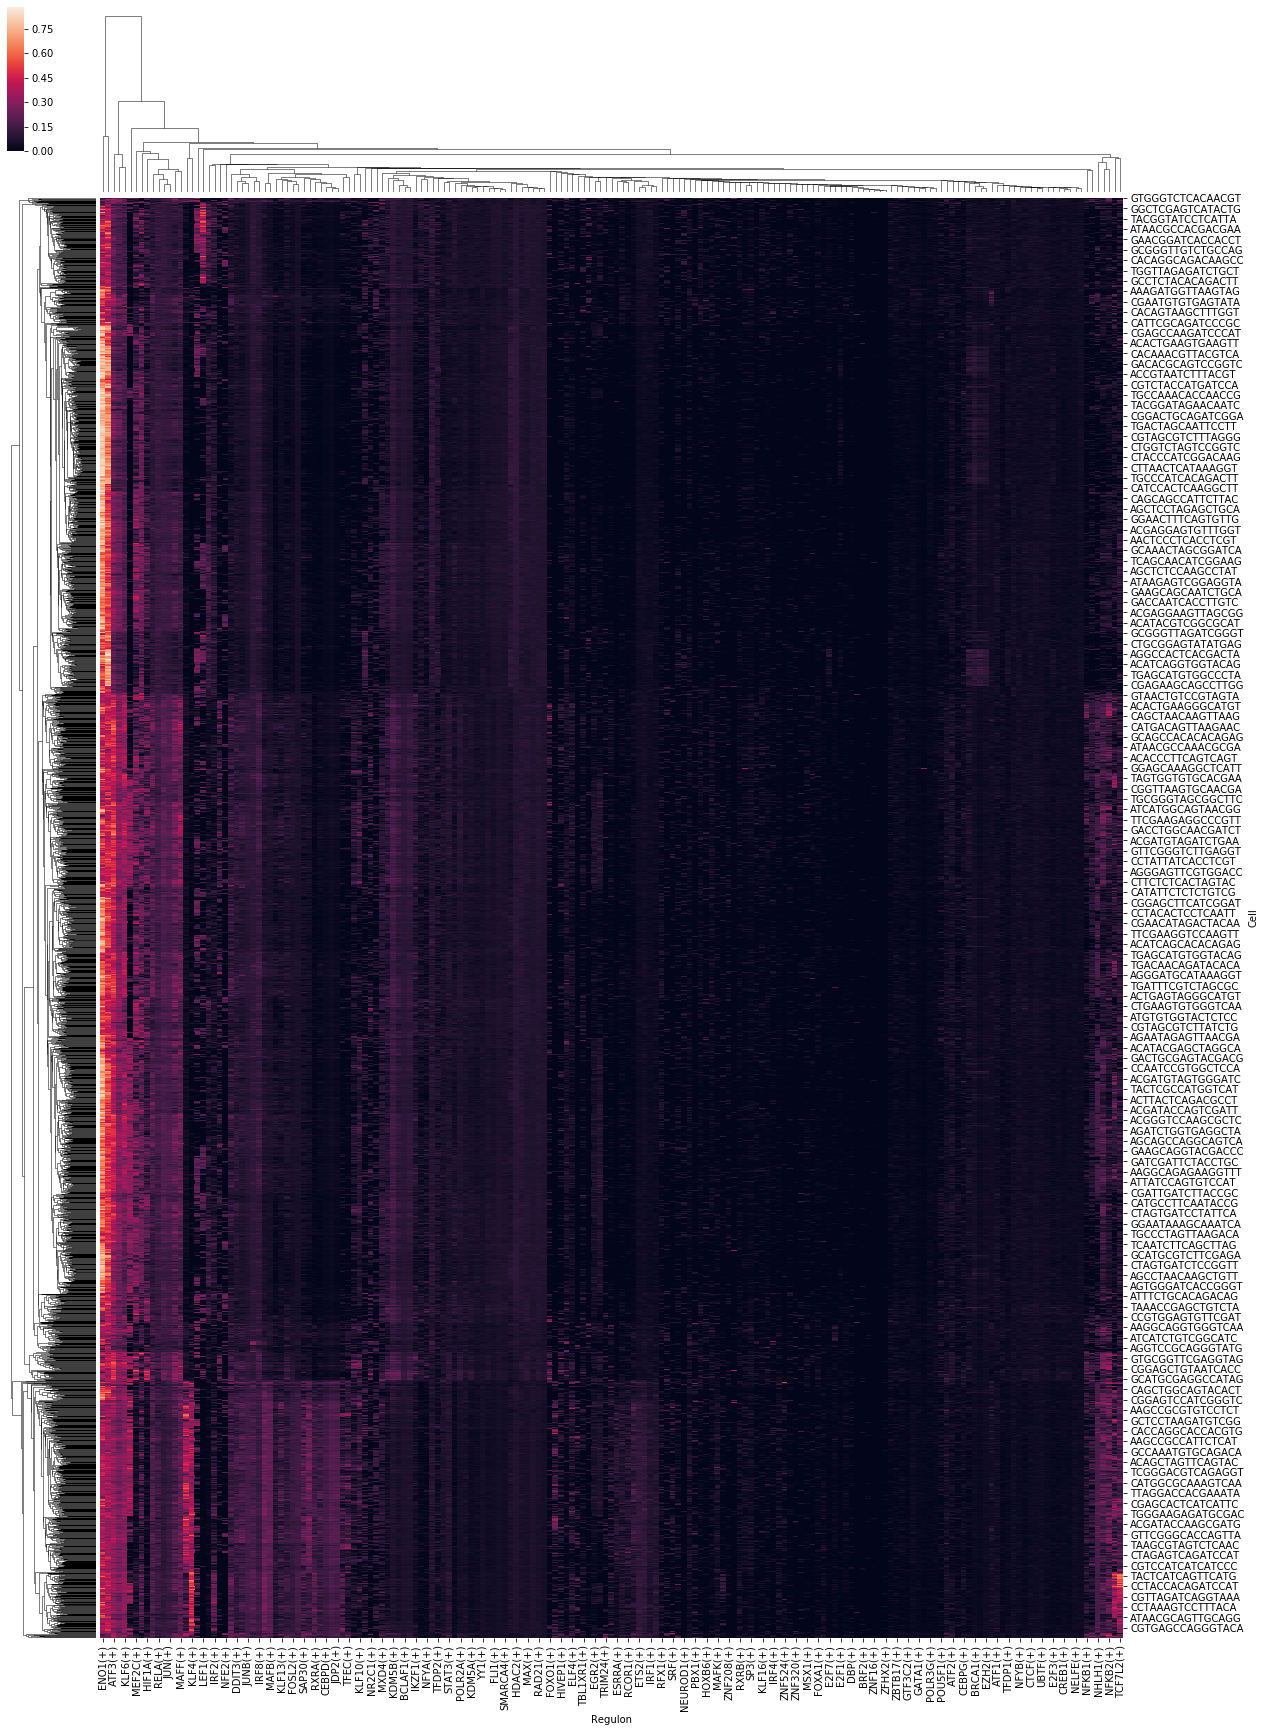

In [73]:
sns.clustermap(auc_mtx, figsize=(20,30))

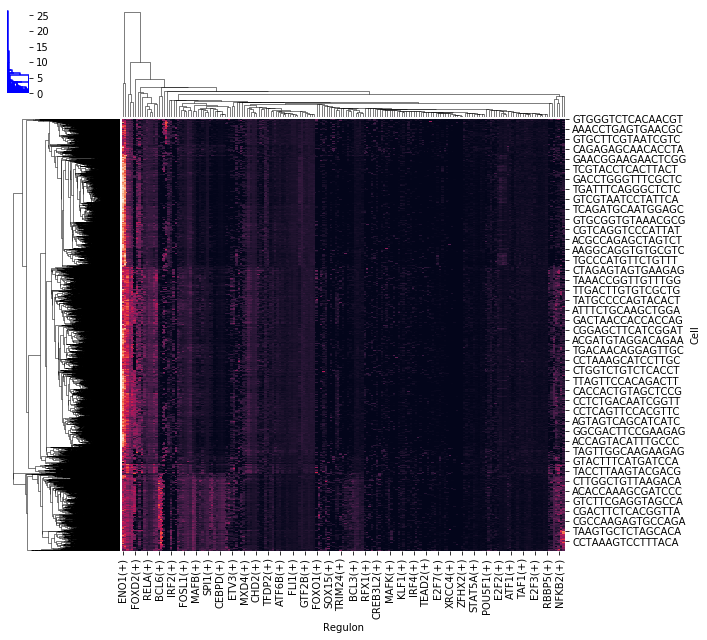

In [115]:
import scipy
g = sns.clustermap(auc_mtx,method='average')
den = scipy.cluster.hierarchy.dendrogram(g.dendrogram_col.linkage,
                                         labels = df.index,
                                         color_threshold=0.60)  
from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

clusters = get_cluster_classes(den)

cluster = []
for i in df.index:
    included=False
    for j in clusters.keys():
        if i in clusters[j]:
            cluster.append(j)
            included=True
    if not included:
        cluster.append(None)

In [117]:
clusters

{'b': [('SPI1', 'taipale__Spic_DBD_AAAAAGMGGAAGTA'),
  ('CEBPD', 'hocomoco__CEBPA_HUMAN.H11MO.0.A'),
  ('BCLAF1', 'dbcorrdb__TAF1__ENCSR000BHT_1__m1'),
  ('EOMES', 'transfac_pro__M01195'),
  ('SPI1', 'hocomoco__SPIB_HUMAN.H11MO.0.A'),
  ('SPI1', 'transfac_pro__M00658'),
  ('CEBPD', 'taipale__Cebpb_DBD_NTTRCGCAAY_repr'),
  ('SPI1', 'cisbp__M6222'),
  ('SPI1', 'taipale_cyt_meth__SPIB_RWWGRGGAAGTN_eDBD_meth'),
  ('BCLAF1', 'dbcorrdb__TAF1__ENCSR000BQF_1__m1'),
  ('EOMES', 'transfac_pro__M07901'),
  ('CEBPD', 'transfac_pro__M08910'),
  ('SPI1', 'hocomoco__SPIB_HUMAN.H11MO.0.A'),
  ('ERG', 'dbcorrdb__PHF8__ENCSR000AQH_1__m1'),
  ('SPI1', 'elemento__ACTTCCTC'),
  ('EOMES', 'taipale__EOMES_DBD_TCACACCTNNNNAGGTGTGA_repr'),
  ('SPI1', 'cisbp__M5863'),
  ('CEBPD', 'homer__ATTGCGCAAC_CEBP'),
  ('BCLAF1', 'dbcorrdb__POLR2A__ENCSR000BKI_1__m1'),
  ('CEBPD', 'taipale__CEBPD_DBD_NTTRCGCAAY'),
  ('SPI1', 'taipale_cyt_meth__SPIB_RAWWGMGGAAGTN_FL'),
  ('CEBPD', 'cisbp__M5317'),
  ('CEBPD', 'cisbp__M3036

In [59]:
import sys
sys.version

'3.7.3 (default, Mar 27 2019, 22:11:17) \n[GCC 7.3.0]'

In [83]:
type(regulons[74])

pyscenic.genesig.Regulon

In [87]:
regulons[74]

Regulon(name='JUN(+)', gene2weight=<frozendict {'VPS37B': 4.99112185106784, 'CREB5': 6.9190159599098795, 'ZNF593': 4.99112185106784, 'UBE2H': 15.197135616222234, 'RAD23A': 6.9190159599098795, 'HOMER1': 12.21294661869187, 'C12orf66': 4.99112185106784, 'ATF3': 56.67786258866968, 'DOK1': 5.663430015536963, 'SYT11': 15.570013494155454, 'DUSP1': 56.67786258866968, 'MLF2': 14.353084069483373, 'MCAM': 15.570013494155454, 'LETM2': 22.191735543894307, 'ACBD4': 15.197135616222234, 'HPS5': 22.191735543894307, 'GTPBP1': 17.048573909877806, 'ATP6V0C': 15.197135616222234, 'TMEM39A': 12.21294661869187, 'ABCE1': 4.99112185106784, 'NUP98': 22.191735543894307, 'NR4A3': 14.353084069483373, 'JUND': 19.23389696758188, 'CYCS': 51.72600759296184, 'AHCYL1': 15.197135616222234, 'BTG3': 15.197135616222234, 'BRD2': 22.191735543894307, 'LRRC57': 22.191735543894307, 'AP2B1': 15.197135616222234, 'ZNF711': 51.72600759296184, 'GNL1': 17.048573909877806, 'BAZ2B': 22.191735543894307, 'ARL4C': 51.72600759296184, 'FOSB':

In [97]:
modules[394]

Regulon(name='Regulon for JUN', gene2weight=<frozendict {'FOS': 87.25225104861086, 'KLF6': 84.03375515331904, 'H3F3B': 60.51868143047955, 'IER2': 56.7798147175841, 'BTG1': 56.67786258866968, 'Z93241.1': 56.555073157006525, 'ATF3': 51.72600759296184, 'WDR74': 50.205191645745636, 'RHOB': 50.07850000302461, 'DUSP1': 48.92838700247691, 'FOSB': 48.88068041971407, 'PPP1R15A': 46.56023727135695, 'CD69': 45.511858252423856, 'RASD1': 45.07600146970851, 'AC103591.3': 43.321439693171584, 'PMAIP1': 41.31865723212701, 'GADD45B': 41.233663293676734, 'C12orf57': 40.929017445304, 'AC245014.3': 38.93011307729308, 'ZFP36': 38.31295508513972, 'TSC22D3': 37.84107024915322, 'AC007952.4': 37.462491617102806, 'MALAT1': 36.69093195609766, 'STK17B': 35.805519411537034, 'CD82': 35.57968155930025, 'TUBA1A': 35.52296924713107, 'ZFP36L2': 34.783718073265675, 'WSB1': 34.22424206574188, 'SLC2A3': 33.40002187303273, 'HIST2H2BE': 32.35220268860493, 'PPP1R10': 32.1129079331614, 'KLF2': 30.979231864986055, 'PTCH2': 30.5